In [1]:
import numpy as np
import itertools
import random
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from jenga.cleaning.ppp import PipelineWithPPP
from jenga.cleaning.autoclean import AutoClean
from jenga.cleaning.outlier_removal import SKLearnIsolationForest
from jenga.cleaning.imputation import SimpleImputation

from jenga.corruptions.categorical import SwapValues
from jenga.corruptions.numeric import SwappedValues, Outliers, Scaling
from jenga.corruptions.text import BrokenCharacters
from jenga.corruptions.missing import ( MissingValuesHighEntropy, 
                                  MissingValuesLowEntropy, 
                                  MissingValues
                                )

%load_ext autoreload
%autoreload 2


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Titanic Example

In [2]:

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features),
        ('categorical_features', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.790


In [4]:
perturbation = Scaling(0.2, ['age','fare'])
# perturbation = SwappedValues(0.4, ['age','fare'])
# perturbation = MissingValues(0.7, 'fare',0,'MAR')
X_corrupted = perturbation(X_test.copy())

ac = AutoClean(X_train, 
               y_train, 
               clf,
               numeric_columns=numeric_features,
               categorical_columns=categorical_features,
               verbose=True
              )

X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': predicted_score_no_cleaning,
        'ppp_score_cleaned': np.array(cleaner_results_ppp).max()
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_015201/
2020-03-28 02:52:01,380 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_015201/
Beginning AutoGluon training ...
2020-03-28 02:52:01,381 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_015201/
2020-03-28 02:52:01,382 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_015201/
Train Data Rows:    1047
2020-03-28 02:52:01,384 [INFO]  Train Data Rows:    1047
Train Data Columns: 13
2020-03-28 02:52:01,385 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 02:52:01,387 [INFO]  Preprocessing data ...
2020-03-28 02:52:01,395 [Level 25]  Warning: Some classes in the training set have fewer than 10 examples. AutoGluon will only keep 3 out of 4 classes for training and will not try to predict the rare classes. To keep more classes, increase the number of datapoints from these rar

2020-03-28 02:52:31,730 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 02:52:31,732 [INFO]  Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
2020-03-28 02:52:31,747 [INFO]  Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Feature Generator processed 1047 data points with 54 features
2020-03-28 02:52:32,416 [INFO]  Feature Generator processed 1047 data points with 54 features
Original Features:
2020-03-28 02:52:32,417 [INFO]  Original Features:
	float features: 6
2020-03-28 02:52:32,418 [INFO]  	float features: 6
	object features: 6
2020-03-28 02:52:32,420 [INFO]  	object features: 6
Generated Features:
2020-03-28 02:52:32,421 [INFO]  Generated Features:
	int features: 42
2020-03-28 02:52:32,422 [INFO]  	int features: 42
All Features:
2020-03-28 02:52:32,424 [INFO]  All Features:
	float features: 6
2020-03-28 02:52:32,425 [INFO]  	float features: 6
	object features: 6
2020-03-28 02:52:32,426 [INFO]  	object features: 6
	in

AutoGluon will early stop models using evaluation metric: accuracy
2020-03-28 02:53:07,757 [Level 25]  AutoGluon will early stop models using evaluation metric: accuracy
Fitting model: RandomForestClassifierGini ...
2020-03-28 02:53:07,773 [INFO]  Fitting model: RandomForestClassifierGini ...
	0.9714	 = Validation accuracy score
2020-03-28 02:53:08,604 [INFO]  	0.9714	 = Validation accuracy score
	0.68s	 = Training runtime
2020-03-28 02:53:08,606 [INFO]  	0.68s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:53:08,608 [INFO]  	0.13s	 = Validation runtime
Fitting model: RandomForestClassifierEntr ...
2020-03-28 02:53:08,612 [INFO]  Fitting model: RandomForestClassifierEntr ...
	0.9619	 = Validation accuracy score
2020-03-28 02:53:09,440 [INFO]  	0.9619	 = Validation accuracy score
	0.68s	 = Training runtime
2020-03-28 02:53:09,442 [INFO]  	0.68s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:53:09,443 [INFO]  	0.13s	 = Validation runtime
Fitting model: Ext

2020-03-28 02:53:34,452 [INFO]  	-12.8175	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 02:53:34,454 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:53:34,456 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 02:53:34,459 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-12.858	 = Validation root_mean_squared_error score
2020-03-28 02:53:34,614 [INFO]  	-12.858	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 02:53:34,617 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:53:34,619 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 02:53:34,623 [INFO]  Fitting model: LightGBMRegressor ...
	-10.5012	 = Validation root_mean_squared_error score
2020-03-28 02:53:34,974 [INFO]  	-10.5012	 = Validation root_mean_squared_error score
	0.32s	 = Training runtime
2020-03-28 02:53:34,975 [INFO]  	

	11.14s	 = Training runtime
2020-03-28 02:54:05,021 [INFO]  	11.14s	 = Training runtime
	0.2s	 = Validation runtime
2020-03-28 02:54:05,022 [INFO]  	0.2s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 02:54:05,026 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-42.5708	 = Validation root_mean_squared_error score
2020-03-28 02:54:06,086 [INFO]  	-42.5708	 = Validation root_mean_squared_error score
	1.0s	 = Training runtime
2020-03-28 02:54:06,087 [INFO]  	1.0s	 = Training runtime
	0.02s	 = Validation runtime
2020-03-28 02:54:06,088 [INFO]  	0.02s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 02:54:07,095 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-35.3749	 = Validation root_mean_squared_error score
2020-03-28 02:54:07,639 [INFO]  	-35.3749	 = Validation root_mean_squared_error score
	0.53s	 = Training runtime
2020-03-28 02:54:07,640 [INFO]  	0.53s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 02:54:07,

Generating perturbed training data on 1047 rows ...
	... perturbation 0/3750: swapped, col ('age', 'fare'), fraction: 0.1
	... perturbation 1/3750: swapped, col ('embarked', 'pclass'), fraction: 0.1
	... perturbation 2/3750: scaling, col ['age'], fraction: 0.1
	... perturbation 3/3750: outlier, col ['age'], fraction: 0.1
	... perturbation 4/3750: missing_MCAR, col age, fraction: 0.1
	... perturbation 5/3750: missing_MAR, col age, fraction: 0.1
	... perturbation 6/3750: missing_MNAR, col age, fraction: 0.1
	... perturbation 7/3750: missing_high_entropy, col [], fraction: 0.1
	... perturbation 8/3750: missing_low_entropy, col [], fraction: 0.1
	... perturbation 9/3750: swap_categorical_values, col sex, fraction: 0.1
	... perturbation 10/3750: missing_MCAR, col sex, fraction: 0.1
	... perturbation 11/3750: missing_MAR, col sex, fraction: 0.1
	... perturbation 12/3750: missing_MNAR, col sex, fraction: 0.1
	... perturbation 13/3750: missing_high_entropy, col ['sex'], fraction: 0.1
	... pert

	... perturbation 123/3750: outlier, col ['age'], fraction: 0.7
	... perturbation 124/3750: missing_MCAR, col age, fraction: 0.7
	... perturbation 125/3750: missing_MAR, col age, fraction: 0.7
	... perturbation 126/3750: missing_MNAR, col age, fraction: 0.7
	... perturbation 127/3750: missing_high_entropy, col [], fraction: 0.7
	... perturbation 128/3750: missing_low_entropy, col [], fraction: 0.7
	... perturbation 129/3750: swap_categorical_values, col pclass, fraction: 0.7
	... perturbation 130/3750: missing_MCAR, col pclass, fraction: 0.7
	... perturbation 131/3750: missing_MAR, col pclass, fraction: 0.7
	... perturbation 132/3750: missing_MNAR, col pclass, fraction: 0.7
	... perturbation 133/3750: missing_high_entropy, col ['pclass'], fraction: 0.7
	... perturbation 134/3750: missing_low_entropy, col ['pclass'], fraction: 0.7
	... perturbation 135/3750: swapped, col ('age', 'fare'), fraction: 0.9
	... perturbation 136/3750: swapped, col ('embarked', 'pclass'), fraction: 0.9
	... pe

	... perturbation 246/3750: missing_MNAR, col age, fraction: 0.2
	... perturbation 247/3750: missing_high_entropy, col [], fraction: 0.2
	... perturbation 248/3750: missing_low_entropy, col [], fraction: 0.2
	... perturbation 249/3750: swap_categorical_values, col pclass, fraction: 0.2
	... perturbation 250/3750: missing_MCAR, col pclass, fraction: 0.2
	... perturbation 251/3750: missing_MAR, col pclass, fraction: 0.2
	... perturbation 252/3750: missing_MNAR, col pclass, fraction: 0.2
	... perturbation 253/3750: missing_high_entropy, col ['embarked'], fraction: 0.2
	... perturbation 254/3750: missing_low_entropy, col ['pclass'], fraction: 0.2
	... perturbation 255/3750: swapped, col ('age', 'fare'), fraction: 0.5
	... perturbation 256/3750: swapped, col ('embarked', 'pclass'), fraction: 0.5
	... perturbation 257/3750: scaling, col ['age'], fraction: 0.5
	... perturbation 258/3750: outlier, col ['age'], fraction: 0.5
	... perturbation 259/3750: missing_MCAR, col age, fraction: 0.5
	... 

	... perturbation 371/3750: missing_MAR, col embarked, fraction: 0.9
	... perturbation 372/3750: missing_MNAR, col embarked, fraction: 0.9
	... perturbation 373/3750: missing_high_entropy, col ['pclass'], fraction: 0.9
	... perturbation 374/3750: missing_low_entropy, col ['pclass'], fraction: 0.9
	... perturbation 375/3750: swapped, col ('age', 'fare'), fraction: 0.1
	... perturbation 376/3750: swapped, col ('embarked', 'pclass'), fraction: 0.1
	... perturbation 377/3750: scaling, col ['age'], fraction: 0.1
	... perturbation 378/3750: outlier, col ['age'], fraction: 0.1
	... perturbation 379/3750: missing_MCAR, col age, fraction: 0.1
	... perturbation 380/3750: missing_MAR, col age, fraction: 0.1
	... perturbation 381/3750: missing_MNAR, col age, fraction: 0.1
	... perturbation 382/3750: missing_high_entropy, col [], fraction: 0.1
	... perturbation 383/3750: missing_low_entropy, col [], fraction: 0.1
	... perturbation 384/3750: swap_categorical_values, col pclass, fraction: 0.1
	... pe

	... perturbation 491/3750: missing_MAR, col embarked, fraction: 0.5
	... perturbation 492/3750: missing_MNAR, col embarked, fraction: 0.5
	... perturbation 493/3750: missing_high_entropy, col ['sex'], fraction: 0.5
	... perturbation 494/3750: missing_low_entropy, col ['pclass'], fraction: 0.5
	... perturbation 495/3750: swapped, col ('age', 'fare'), fraction: 0.7
	... perturbation 496/3750: swapped, col ('embarked', 'pclass'), fraction: 0.7
	... perturbation 497/3750: scaling, col ['age'], fraction: 0.7
	... perturbation 498/3750: outlier, col ['age'], fraction: 0.7
	... perturbation 499/3750: missing_MCAR, col age, fraction: 0.7
	... perturbation 500/3750: missing_MAR, col age, fraction: 0.7
	... perturbation 501/3750: missing_MNAR, col age, fraction: 0.7
	... perturbation 502/3750: missing_high_entropy, col [], fraction: 0.7
	... perturbation 503/3750: missing_low_entropy, col [], fraction: 0.7
	... perturbation 504/3750: swap_categorical_values, col pclass, fraction: 0.7
	... pertu

	... perturbation 611/3750: missing_MAR, col embarked, fraction: 0.1
	... perturbation 612/3750: missing_MNAR, col embarked, fraction: 0.1
	... perturbation 613/3750: missing_high_entropy, col ['sex'], fraction: 0.1
	... perturbation 614/3750: missing_low_entropy, col ['embarked'], fraction: 0.1
	... perturbation 615/3750: swapped, col ('age', 'fare'), fraction: 0.2
	... perturbation 616/3750: swapped, col ('sex', 'pclass'), fraction: 0.2
	... perturbation 617/3750: scaling, col ['fare'], fraction: 0.2
	... perturbation 618/3750: outlier, col ['fare'], fraction: 0.2
	... perturbation 619/3750: missing_MCAR, col fare, fraction: 0.2
	... perturbation 620/3750: missing_MAR, col fare, fraction: 0.2
	... perturbation 621/3750: missing_MNAR, col fare, fraction: 0.2
	... perturbation 622/3750: missing_high_entropy, col [], fraction: 0.2
	... perturbation 623/3750: missing_low_entropy, col [], fraction: 0.2
	... perturbation 624/3750: swap_categorical_values, col pclass, fraction: 0.2
	... per

	... perturbation 730/3750: missing_MCAR, col embarked, fraction: 0.7
	... perturbation 731/3750: missing_MAR, col embarked, fraction: 0.7
	... perturbation 732/3750: missing_MNAR, col embarked, fraction: 0.7
	... perturbation 733/3750: missing_high_entropy, col ['sex'], fraction: 0.7
	... perturbation 734/3750: missing_low_entropy, col ['embarked'], fraction: 0.7
	... perturbation 735/3750: swapped, col ('age', 'fare'), fraction: 0.9
	... perturbation 736/3750: swapped, col ('sex', 'pclass'), fraction: 0.9
	... perturbation 737/3750: scaling, col ['age'], fraction: 0.9
	... perturbation 738/3750: outlier, col ['age'], fraction: 0.9
	... perturbation 739/3750: missing_MCAR, col age, fraction: 0.9
	... perturbation 740/3750: missing_MAR, col age, fraction: 0.9
	... perturbation 741/3750: missing_MNAR, col age, fraction: 0.9
	... perturbation 742/3750: missing_high_entropy, col [], fraction: 0.9
	... perturbation 743/3750: missing_low_entropy, col [], fraction: 0.9
	... perturbation 744/

	... perturbation 848/3750: missing_low_entropy, col [], fraction: 0.2
	... perturbation 849/3750: swap_categorical_values, col embarked, fraction: 0.2
	... perturbation 850/3750: missing_MCAR, col embarked, fraction: 0.2
	... perturbation 851/3750: missing_MAR, col embarked, fraction: 0.2
	... perturbation 852/3750: missing_MNAR, col embarked, fraction: 0.2
	... perturbation 853/3750: missing_high_entropy, col ['embarked'], fraction: 0.2
	... perturbation 854/3750: missing_low_entropy, col ['embarked'], fraction: 0.2
	... perturbation 855/3750: swapped, col ('age', 'fare'), fraction: 0.5
	... perturbation 856/3750: swapped, col ('embarked', 'sex'), fraction: 0.5
	... perturbation 857/3750: scaling, col ['fare'], fraction: 0.5
	... perturbation 858/3750: outlier, col ['fare'], fraction: 0.5
	... perturbation 859/3750: missing_MCAR, col fare, fraction: 0.5
	... perturbation 860/3750: missing_MAR, col fare, fraction: 0.5
	... perturbation 861/3750: missing_MNAR, col fare, fraction: 0.5
	

	... perturbation 969/3750: swap_categorical_values, col embarked, fraction: 0.9
	... perturbation 970/3750: missing_MCAR, col embarked, fraction: 0.9
	... perturbation 971/3750: missing_MAR, col embarked, fraction: 0.9
	... perturbation 972/3750: missing_MNAR, col embarked, fraction: 0.9
	... perturbation 973/3750: missing_high_entropy, col ['pclass'], fraction: 0.9
	... perturbation 974/3750: missing_low_entropy, col ['sex'], fraction: 0.9
	... perturbation 975/3750: swapped, col ('age', 'fare'), fraction: 0.1
	... perturbation 976/3750: swapped, col ('embarked', 'pclass'), fraction: 0.1
	... perturbation 977/3750: scaling, col ['age'], fraction: 0.1
	... perturbation 978/3750: outlier, col ['age'], fraction: 0.1
	... perturbation 979/3750: missing_MCAR, col age, fraction: 0.1
	... perturbation 980/3750: missing_MAR, col age, fraction: 0.1
	... perturbation 981/3750: missing_MNAR, col age, fraction: 0.1
	... perturbation 982/3750: missing_high_entropy, col [], fraction: 0.1
	... pert

	... perturbation 1092/3750: missing_MNAR, col embarked, fraction: 0.5
	... perturbation 1093/3750: missing_high_entropy, col ['sex'], fraction: 0.5
	... perturbation 1094/3750: missing_low_entropy, col ['embarked'], fraction: 0.5
	... perturbation 1095/3750: swapped, col ('age', 'fare'), fraction: 0.7
	... perturbation 1096/3750: swapped, col ('embarked', 'pclass'), fraction: 0.7
	... perturbation 1097/3750: scaling, col ['fare'], fraction: 0.7
	... perturbation 1098/3750: outlier, col ['fare'], fraction: 0.7
	... perturbation 1099/3750: missing_MCAR, col fare, fraction: 0.7
	... perturbation 1100/3750: missing_MAR, col fare, fraction: 0.7
	... perturbation 1101/3750: missing_MNAR, col fare, fraction: 0.7
	... perturbation 1102/3750: missing_high_entropy, col [], fraction: 0.7
	... perturbation 1103/3750: missing_low_entropy, col [], fraction: 0.7
	... perturbation 1104/3750: swap_categorical_values, col sex, fraction: 0.7
	... perturbation 1105/3750: missing_MCAR, col sex, fraction: 

	... perturbation 1214/3750: missing_low_entropy, col ['pclass'], fraction: 0.1
	... perturbation 1215/3750: swapped, col ('age', 'fare'), fraction: 0.2
	... perturbation 1216/3750: swapped, col ('embarked', 'sex'), fraction: 0.2
	... perturbation 1217/3750: scaling, col ['age'], fraction: 0.2
	... perturbation 1218/3750: outlier, col ['age'], fraction: 0.2
	... perturbation 1219/3750: missing_MCAR, col age, fraction: 0.2
	... perturbation 1220/3750: missing_MAR, col age, fraction: 0.2
	... perturbation 1221/3750: missing_MNAR, col age, fraction: 0.2
	... perturbation 1222/3750: missing_high_entropy, col [], fraction: 0.2
	... perturbation 1223/3750: missing_low_entropy, col [], fraction: 0.2
	... perturbation 1224/3750: swap_categorical_values, col sex, fraction: 0.2
	... perturbation 1225/3750: missing_MCAR, col sex, fraction: 0.2
	... perturbation 1226/3750: missing_MAR, col sex, fraction: 0.2
	... perturbation 1227/3750: missing_MNAR, col sex, fraction: 0.2
	... perturbation 1228/3

	... perturbation 1336/3750: swapped, col ('embarked', 'pclass'), fraction: 0.9
	... perturbation 1337/3750: scaling, col ['age'], fraction: 0.9
	... perturbation 1338/3750: outlier, col ['age'], fraction: 0.9
	... perturbation 1339/3750: missing_MCAR, col age, fraction: 0.9
	... perturbation 1340/3750: missing_MAR, col age, fraction: 0.9
	... perturbation 1341/3750: missing_MNAR, col age, fraction: 0.9
	... perturbation 1342/3750: missing_high_entropy, col [], fraction: 0.9
	... perturbation 1343/3750: missing_low_entropy, col [], fraction: 0.9
	... perturbation 1344/3750: swap_categorical_values, col pclass, fraction: 0.9
	... perturbation 1345/3750: missing_MCAR, col pclass, fraction: 0.9
	... perturbation 1346/3750: missing_MAR, col pclass, fraction: 0.9
	... perturbation 1347/3750: missing_MNAR, col pclass, fraction: 0.9
	... perturbation 1348/3750: missing_high_entropy, col ['sex'], fraction: 0.9
	... perturbation 1349/3750: missing_low_entropy, col ['pclass'], fraction: 0.9
	...

	... perturbation 1461/3750: missing_MNAR, col fare, fraction: 0.5
	... perturbation 1462/3750: missing_high_entropy, col [], fraction: 0.5
	... perturbation 1463/3750: missing_low_entropy, col [], fraction: 0.5
	... perturbation 1464/3750: swap_categorical_values, col embarked, fraction: 0.5
	... perturbation 1465/3750: missing_MCAR, col embarked, fraction: 0.5
	... perturbation 1466/3750: missing_MAR, col embarked, fraction: 0.5
	... perturbation 1467/3750: missing_MNAR, col embarked, fraction: 0.5
	... perturbation 1468/3750: missing_high_entropy, col ['embarked'], fraction: 0.5
	... perturbation 1469/3750: missing_low_entropy, col ['pclass'], fraction: 0.5
	... perturbation 1470/3750: swapped, col ('age', 'fare'), fraction: 0.7
	... perturbation 1471/3750: swapped, col ('embarked', 'pclass'), fraction: 0.7
	... perturbation 1472/3750: scaling, col ['fare'], fraction: 0.7
	... perturbation 1473/3750: outlier, col ['fare'], fraction: 0.7
	... perturbation 1474/3750: missing_MCAR, col

	... perturbation 1584/3750: swap_categorical_values, col embarked, fraction: 0.1
	... perturbation 1585/3750: missing_MCAR, col embarked, fraction: 0.1
	... perturbation 1586/3750: missing_MAR, col embarked, fraction: 0.1
	... perturbation 1587/3750: missing_MNAR, col embarked, fraction: 0.1
	... perturbation 1588/3750: missing_high_entropy, col ['embarked'], fraction: 0.1
	... perturbation 1589/3750: missing_low_entropy, col ['embarked'], fraction: 0.1
	... perturbation 1590/3750: swapped, col ('age', 'fare'), fraction: 0.2
	... perturbation 1591/3750: swapped, col ('embarked', 'pclass'), fraction: 0.2
	... perturbation 1592/3750: scaling, col ['fare'], fraction: 0.2
	... perturbation 1593/3750: outlier, col ['fare'], fraction: 0.2
	... perturbation 1594/3750: missing_MCAR, col fare, fraction: 0.2
	... perturbation 1595/3750: missing_MAR, col fare, fraction: 0.2
	... perturbation 1596/3750: missing_MNAR, col fare, fraction: 0.2
	... perturbation 1597/3750: missing_high_entropy, col [

	... perturbation 1705/3750: missing_MCAR, col sex, fraction: 0.7
	... perturbation 1706/3750: missing_MAR, col sex, fraction: 0.7
	... perturbation 1707/3750: missing_MNAR, col sex, fraction: 0.7
	... perturbation 1708/3750: missing_high_entropy, col ['pclass'], fraction: 0.7
	... perturbation 1709/3750: missing_low_entropy, col ['embarked'], fraction: 0.7
	... perturbation 1710/3750: swapped, col ('age', 'fare'), fraction: 0.9
	... perturbation 1711/3750: swapped, col ('embarked', 'pclass'), fraction: 0.9
	... perturbation 1712/3750: scaling, col ['fare'], fraction: 0.9
	... perturbation 1713/3750: outlier, col ['fare'], fraction: 0.9
	... perturbation 1714/3750: missing_MCAR, col fare, fraction: 0.9
	... perturbation 1715/3750: missing_MAR, col fare, fraction: 0.9
	... perturbation 1716/3750: missing_MNAR, col fare, fraction: 0.9
	... perturbation 1717/3750: missing_high_entropy, col [], fraction: 0.9
	... perturbation 1718/3750: missing_low_entropy, col [], fraction: 0.9
	... pertu

	... perturbation 1827/3750: missing_MNAR, col embarked, fraction: 0.2
	... perturbation 1828/3750: missing_high_entropy, col ['pclass'], fraction: 0.2
	... perturbation 1829/3750: missing_low_entropy, col ['sex'], fraction: 0.2
	... perturbation 1830/3750: swapped, col ('age', 'fare'), fraction: 0.5
	... perturbation 1831/3750: swapped, col ('sex', 'pclass'), fraction: 0.5
	... perturbation 1832/3750: scaling, col ['fare'], fraction: 0.5
	... perturbation 1833/3750: outlier, col ['fare'], fraction: 0.5
	... perturbation 1834/3750: missing_MCAR, col fare, fraction: 0.5
	... perturbation 1835/3750: missing_MAR, col fare, fraction: 0.5
	... perturbation 1836/3750: missing_MNAR, col fare, fraction: 0.5
	... perturbation 1837/3750: missing_high_entropy, col [], fraction: 0.5
	... perturbation 1838/3750: missing_low_entropy, col [], fraction: 0.5
	... perturbation 1839/3750: swap_categorical_values, col pclass, fraction: 0.5
	... perturbation 1840/3750: missing_MCAR, col pclass, fraction: 0

	... perturbation 1949/3750: missing_low_entropy, col ['embarked'], fraction: 0.9
	... perturbation 1950/3750: swapped, col ('age', 'fare'), fraction: 0.1
	... perturbation 1951/3750: swapped, col ('embarked', 'pclass'), fraction: 0.1
	... perturbation 1952/3750: scaling, col ['fare'], fraction: 0.1
	... perturbation 1953/3750: outlier, col ['fare'], fraction: 0.1
	... perturbation 1954/3750: missing_MCAR, col fare, fraction: 0.1
	... perturbation 1955/3750: missing_MAR, col fare, fraction: 0.1
	... perturbation 1956/3750: missing_MNAR, col fare, fraction: 0.1
	... perturbation 1957/3750: missing_high_entropy, col [], fraction: 0.1
	... perturbation 1958/3750: missing_low_entropy, col [], fraction: 0.1
	... perturbation 1959/3750: swap_categorical_values, col embarked, fraction: 0.1
	... perturbation 1960/3750: missing_MCAR, col embarked, fraction: 0.1
	... perturbation 1961/3750: missing_MAR, col embarked, fraction: 0.1
	... perturbation 1962/3750: missing_MNAR, col embarked, fraction

	... perturbation 2071/3750: swapped, col ('embarked', 'pclass'), fraction: 0.7
	... perturbation 2072/3750: scaling, col ['fare'], fraction: 0.7
	... perturbation 2073/3750: outlier, col ['fare'], fraction: 0.7
	... perturbation 2074/3750: missing_MCAR, col fare, fraction: 0.7
	... perturbation 2075/3750: missing_MAR, col fare, fraction: 0.7
	... perturbation 2076/3750: missing_MNAR, col fare, fraction: 0.7
	... perturbation 2077/3750: missing_high_entropy, col [], fraction: 0.7
	... perturbation 2078/3750: missing_low_entropy, col [], fraction: 0.7
	... perturbation 2079/3750: swap_categorical_values, col sex, fraction: 0.7
	... perturbation 2080/3750: missing_MCAR, col sex, fraction: 0.7
	... perturbation 2081/3750: missing_MAR, col sex, fraction: 0.7
	... perturbation 2082/3750: missing_MNAR, col sex, fraction: 0.7
	... perturbation 2083/3750: missing_high_entropy, col ['sex'], fraction: 0.7
	... perturbation 2084/3750: missing_low_entropy, col ['embarked'], fraction: 0.7
	... pert

	... perturbation 2197/3750: missing_high_entropy, col [], fraction: 0.2
	... perturbation 2198/3750: missing_low_entropy, col [], fraction: 0.2
	... perturbation 2199/3750: swap_categorical_values, col pclass, fraction: 0.2
	... perturbation 2200/3750: missing_MCAR, col pclass, fraction: 0.2
	... perturbation 2201/3750: missing_MAR, col pclass, fraction: 0.2
	... perturbation 2202/3750: missing_MNAR, col pclass, fraction: 0.2
	... perturbation 2203/3750: missing_high_entropy, col ['sex'], fraction: 0.2
	... perturbation 2204/3750: missing_low_entropy, col ['pclass'], fraction: 0.2
	... perturbation 2205/3750: swapped, col ('age', 'fare'), fraction: 0.5
	... perturbation 2206/3750: swapped, col ('embarked', 'sex'), fraction: 0.5
	... perturbation 2207/3750: scaling, col ['fare'], fraction: 0.5
	... perturbation 2208/3750: outlier, col ['fare'], fraction: 0.5
	... perturbation 2209/3750: missing_MCAR, col fare, fraction: 0.5
	... perturbation 2210/3750: missing_MAR, col fare, fraction: 

	... perturbation 2319/3750: swap_categorical_values, col sex, fraction: 0.9
	... perturbation 2320/3750: missing_MCAR, col sex, fraction: 0.9
	... perturbation 2321/3750: missing_MAR, col sex, fraction: 0.9
	... perturbation 2322/3750: missing_MNAR, col sex, fraction: 0.9
	... perturbation 2323/3750: missing_high_entropy, col ['embarked'], fraction: 0.9
	... perturbation 2324/3750: missing_low_entropy, col ['pclass'], fraction: 0.9
	... perturbation 2325/3750: swapped, col ('age', 'fare'), fraction: 0.1
	... perturbation 2326/3750: swapped, col ('embarked', 'sex'), fraction: 0.1
	... perturbation 2327/3750: scaling, col ['age'], fraction: 0.1
	... perturbation 2328/3750: outlier, col ['age'], fraction: 0.1
	... perturbation 2329/3750: missing_MCAR, col age, fraction: 0.1
	... perturbation 2330/3750: missing_MAR, col age, fraction: 0.1
	... perturbation 2331/3750: missing_MNAR, col age, fraction: 0.1
	... perturbation 2332/3750: missing_high_entropy, col [], fraction: 0.1
	... perturba

	... perturbation 2442/3750: missing_MNAR, col sex, fraction: 0.5
	... perturbation 2443/3750: missing_high_entropy, col ['sex'], fraction: 0.5
	... perturbation 2444/3750: missing_low_entropy, col ['pclass'], fraction: 0.5
	... perturbation 2445/3750: swapped, col ('age', 'fare'), fraction: 0.7
	... perturbation 2446/3750: swapped, col ('embarked', 'sex'), fraction: 0.7
	... perturbation 2447/3750: scaling, col ['fare'], fraction: 0.7
	... perturbation 2448/3750: outlier, col ['fare'], fraction: 0.7
	... perturbation 2449/3750: missing_MCAR, col fare, fraction: 0.7
	... perturbation 2450/3750: missing_MAR, col fare, fraction: 0.7
	... perturbation 2451/3750: missing_MNAR, col fare, fraction: 0.7
	... perturbation 2452/3750: missing_high_entropy, col [], fraction: 0.7
	... perturbation 2453/3750: missing_low_entropy, col [], fraction: 0.7
	... perturbation 2454/3750: swap_categorical_values, col embarked, fraction: 0.7
	... perturbation 2455/3750: missing_MCAR, col embarked, fraction: 

	... perturbation 2563/3750: missing_high_entropy, col ['pclass'], fraction: 0.1
	... perturbation 2564/3750: missing_low_entropy, col ['embarked'], fraction: 0.1
	... perturbation 2565/3750: swapped, col ('age', 'fare'), fraction: 0.2
	... perturbation 2566/3750: swapped, col ('sex', 'pclass'), fraction: 0.2
	... perturbation 2567/3750: scaling, col ['age'], fraction: 0.2
	... perturbation 2568/3750: outlier, col ['age'], fraction: 0.2
	... perturbation 2569/3750: missing_MCAR, col age, fraction: 0.2
	... perturbation 2570/3750: missing_MAR, col age, fraction: 0.2
	... perturbation 2571/3750: missing_MNAR, col age, fraction: 0.2
	... perturbation 2572/3750: missing_high_entropy, col [], fraction: 0.2
	... perturbation 2573/3750: missing_low_entropy, col [], fraction: 0.2
	... perturbation 2574/3750: swap_categorical_values, col sex, fraction: 0.2
	... perturbation 2575/3750: missing_MCAR, col sex, fraction: 0.2
	... perturbation 2576/3750: missing_MAR, col sex, fraction: 0.2
	... pert

	... perturbation 2683/3750: missing_high_entropy, col ['embarked'], fraction: 0.7
	... perturbation 2684/3750: missing_low_entropy, col ['pclass'], fraction: 0.7
	... perturbation 2685/3750: swapped, col ('age', 'fare'), fraction: 0.9
	... perturbation 2686/3750: swapped, col ('embarked', 'pclass'), fraction: 0.9
	... perturbation 2687/3750: scaling, col ['age'], fraction: 0.9
	... perturbation 2688/3750: outlier, col ['age'], fraction: 0.9
	... perturbation 2689/3750: missing_MCAR, col age, fraction: 0.9
	... perturbation 2690/3750: missing_MAR, col age, fraction: 0.9
	... perturbation 2691/3750: missing_MNAR, col age, fraction: 0.9
	... perturbation 2692/3750: missing_high_entropy, col [], fraction: 0.9
	... perturbation 2693/3750: missing_low_entropy, col [], fraction: 0.9
	... perturbation 2694/3750: swap_categorical_values, col embarked, fraction: 0.9
	... perturbation 2695/3750: missing_MCAR, col embarked, fraction: 0.9
	... perturbation 2696/3750: missing_MAR, col embarked, fra

	... perturbation 2803/3750: missing_high_entropy, col ['pclass'], fraction: 0.2
	... perturbation 2804/3750: missing_low_entropy, col ['pclass'], fraction: 0.2
	... perturbation 2805/3750: swapped, col ('age', 'fare'), fraction: 0.5
	... perturbation 2806/3750: swapped, col ('sex', 'pclass'), fraction: 0.5
	... perturbation 2807/3750: scaling, col ['fare'], fraction: 0.5
	... perturbation 2808/3750: outlier, col ['fare'], fraction: 0.5
	... perturbation 2809/3750: missing_MCAR, col fare, fraction: 0.5
	... perturbation 2810/3750: missing_MAR, col fare, fraction: 0.5
	... perturbation 2811/3750: missing_MNAR, col fare, fraction: 0.5
	... perturbation 2812/3750: missing_high_entropy, col [], fraction: 0.5
	... perturbation 2813/3750: missing_low_entropy, col [], fraction: 0.5
	... perturbation 2814/3750: swap_categorical_values, col pclass, fraction: 0.5
	... perturbation 2815/3750: missing_MCAR, col pclass, fraction: 0.5
	... perturbation 2816/3750: missing_MAR, col pclass, fraction: 0

	... perturbation 2924/3750: missing_low_entropy, col ['sex'], fraction: 0.9
	... perturbation 2925/3750: swapped, col ('age', 'fare'), fraction: 0.1
	... perturbation 2926/3750: swapped, col ('embarked', 'pclass'), fraction: 0.1
	... perturbation 2927/3750: scaling, col ['fare'], fraction: 0.1
	... perturbation 2928/3750: outlier, col ['fare'], fraction: 0.1
	... perturbation 2929/3750: missing_MCAR, col fare, fraction: 0.1
	... perturbation 2930/3750: missing_MAR, col fare, fraction: 0.1
	... perturbation 2931/3750: missing_MNAR, col fare, fraction: 0.1
	... perturbation 2932/3750: missing_high_entropy, col [], fraction: 0.1
	... perturbation 2933/3750: missing_low_entropy, col [], fraction: 0.1
	... perturbation 2934/3750: swap_categorical_values, col embarked, fraction: 0.1
	... perturbation 2935/3750: missing_MCAR, col embarked, fraction: 0.1
	... perturbation 2936/3750: missing_MAR, col embarked, fraction: 0.1
	... perturbation 2937/3750: missing_MNAR, col embarked, fraction: 0.1

	... perturbation 3043/3750: missing_high_entropy, col ['pclass'], fraction: 0.5
	... perturbation 3044/3750: missing_low_entropy, col ['pclass'], fraction: 0.5
	... perturbation 3045/3750: swapped, col ('age', 'fare'), fraction: 0.7
	... perturbation 3046/3750: swapped, col ('embarked', 'pclass'), fraction: 0.7
	... perturbation 3047/3750: scaling, col ['fare'], fraction: 0.7
	... perturbation 3048/3750: outlier, col ['fare'], fraction: 0.7
	... perturbation 3049/3750: missing_MCAR, col fare, fraction: 0.7
	... perturbation 3050/3750: missing_MAR, col fare, fraction: 0.7
	... perturbation 3051/3750: missing_MNAR, col fare, fraction: 0.7
	... perturbation 3052/3750: missing_high_entropy, col [], fraction: 0.7
	... perturbation 3053/3750: missing_low_entropy, col [], fraction: 0.7
	... perturbation 3054/3750: swap_categorical_values, col pclass, fraction: 0.7
	... perturbation 3055/3750: missing_MCAR, col pclass, fraction: 0.7
	... perturbation 3056/3750: missing_MAR, col pclass, fracti

	... perturbation 3164/3750: missing_low_entropy, col ['embarked'], fraction: 0.1
	... perturbation 3165/3750: swapped, col ('age', 'fare'), fraction: 0.2
	... perturbation 3166/3750: swapped, col ('embarked', 'sex'), fraction: 0.2
	... perturbation 3167/3750: scaling, col ['age'], fraction: 0.2
	... perturbation 3168/3750: outlier, col ['age'], fraction: 0.2
	... perturbation 3169/3750: missing_MCAR, col age, fraction: 0.2
	... perturbation 3170/3750: missing_MAR, col age, fraction: 0.2
	... perturbation 3171/3750: missing_MNAR, col age, fraction: 0.2
	... perturbation 3172/3750: missing_high_entropy, col [], fraction: 0.2
	... perturbation 3173/3750: missing_low_entropy, col [], fraction: 0.2
	... perturbation 3174/3750: swap_categorical_values, col sex, fraction: 0.2
	... perturbation 3175/3750: missing_MCAR, col sex, fraction: 0.2
	... perturbation 3176/3750: missing_MAR, col sex, fraction: 0.2
	... perturbation 3177/3750: missing_MNAR, col sex, fraction: 0.2
	... perturbation 3178

	... perturbation 3285/3750: swapped, col ('age', 'fare'), fraction: 0.9
	... perturbation 3286/3750: swapped, col ('embarked', 'sex'), fraction: 0.9
	... perturbation 3287/3750: scaling, col ['fare'], fraction: 0.9
	... perturbation 3288/3750: outlier, col ['fare'], fraction: 0.9
	... perturbation 3289/3750: missing_MCAR, col fare, fraction: 0.9
	... perturbation 3290/3750: missing_MAR, col fare, fraction: 0.9
	... perturbation 3291/3750: missing_MNAR, col fare, fraction: 0.9
	... perturbation 3292/3750: missing_high_entropy, col [], fraction: 0.9
	... perturbation 3293/3750: missing_low_entropy, col [], fraction: 0.9
	... perturbation 3294/3750: swap_categorical_values, col embarked, fraction: 0.9
	... perturbation 3295/3750: missing_MCAR, col embarked, fraction: 0.9
	... perturbation 3296/3750: missing_MAR, col embarked, fraction: 0.9
	... perturbation 3297/3750: missing_MNAR, col embarked, fraction: 0.9
	... perturbation 3298/3750: missing_high_entropy, col ['embarked'], fraction: 

	... perturbation 3404/3750: missing_low_entropy, col ['embarked'], fraction: 0.2
	... perturbation 3405/3750: swapped, col ('age', 'fare'), fraction: 0.5
	... perturbation 3406/3750: swapped, col ('sex', 'pclass'), fraction: 0.5
	... perturbation 3407/3750: scaling, col ['fare'], fraction: 0.5
	... perturbation 3408/3750: outlier, col ['fare'], fraction: 0.5
	... perturbation 3409/3750: missing_MCAR, col fare, fraction: 0.5
	... perturbation 3410/3750: missing_MAR, col fare, fraction: 0.5
	... perturbation 3411/3750: missing_MNAR, col fare, fraction: 0.5
	... perturbation 3412/3750: missing_high_entropy, col [], fraction: 0.5
	... perturbation 3413/3750: missing_low_entropy, col [], fraction: 0.5
	... perturbation 3414/3750: swap_categorical_values, col pclass, fraction: 0.5
	... perturbation 3415/3750: missing_MCAR, col pclass, fraction: 0.5
	... perturbation 3416/3750: missing_MAR, col pclass, fraction: 0.5
	... perturbation 3417/3750: missing_MNAR, col pclass, fraction: 0.5
	... pe

	... perturbation 3520/3750: missing_MCAR, col pclass, fraction: 0.9
	... perturbation 3521/3750: missing_MAR, col pclass, fraction: 0.9
	... perturbation 3522/3750: missing_MNAR, col pclass, fraction: 0.9
	... perturbation 3523/3750: missing_high_entropy, col ['sex'], fraction: 0.9
	... perturbation 3524/3750: missing_low_entropy, col ['embarked'], fraction: 0.9
	... perturbation 3525/3750: swapped, col ('age', 'fare'), fraction: 0.1
	... perturbation 3526/3750: swapped, col ('embarked', 'sex'), fraction: 0.1
	... perturbation 3527/3750: scaling, col ['fare'], fraction: 0.1
	... perturbation 3528/3750: outlier, col ['fare'], fraction: 0.1
	... perturbation 3529/3750: missing_MCAR, col fare, fraction: 0.1
	... perturbation 3530/3750: missing_MAR, col fare, fraction: 0.1
	... perturbation 3531/3750: missing_MNAR, col fare, fraction: 0.1
	... perturbation 3532/3750: missing_high_entropy, col [], fraction: 0.1
	... perturbation 3533/3750: missing_low_entropy, col [], fraction: 0.1
	... pe

	... perturbation 3636/3750: missing_MNAR, col fare, fraction: 0.5
	... perturbation 3637/3750: missing_high_entropy, col [], fraction: 0.5
	... perturbation 3638/3750: missing_low_entropy, col [], fraction: 0.5
	... perturbation 3639/3750: swap_categorical_values, col pclass, fraction: 0.5
	... perturbation 3640/3750: missing_MCAR, col pclass, fraction: 0.5
	... perturbation 3641/3750: missing_MAR, col pclass, fraction: 0.5
	... perturbation 3642/3750: missing_MNAR, col pclass, fraction: 0.5
	... perturbation 3643/3750: missing_high_entropy, col ['sex'], fraction: 0.5
	... perturbation 3644/3750: missing_low_entropy, col ['embarked'], fraction: 0.5
	... perturbation 3645/3750: swapped, col ('age', 'fare'), fraction: 0.7
	... perturbation 3646/3750: swapped, col ('embarked', 'pclass'), fraction: 0.7
	... perturbation 3647/3750: scaling, col ['age'], fraction: 0.7
	... perturbation 3648/3750: outlier, col ['age'], fraction: 0.7
	... perturbation 3649/3750: missing_MCAR, col age, fractio

PPP score no cleaning 0.7206622094874243
PPP score with cleaning Cleaner: OutlierRemoval: NoOutlierRemoval, Imputation : NoImputation: 0.721
True score with cleaning Cleaner: OutlierRemoval: NoOutlierRemoval, Imputation : NoImputation: 0.718
PPP score with cleaning Cleaner: OutlierRemoval: SKLearnIsolationForest, Imputation : NoImputation: 0.751
True score with cleaning Cleaner: OutlierRemoval: SKLearnIsolationForest, Imputation : NoImputation: 0.718
PPP score with cleaning Cleaner: OutlierRemoval: NoOutlierRemoval, Imputation : SimpleImputation: 0.719
True score with cleaning Cleaner: OutlierRemoval: NoOutlierRemoval, Imputation : SimpleImputation: 0.718
PPP score with cleaning Cleaner: OutlierRemoval: SKLearnIsolationForest, Imputation : SimpleImputation: 0.706
True score with cleaning Cleaner: OutlierRemoval: SKLearnIsolationForest, Imputation : SimpleImputation: 0.706


Evaluation: accuracy on test data: 0.8129770992366412
2020-03-28 03:00:48,782 [INFO]  Evaluation: accuracy on test data: 0.8129770992366412
Evaluations on test data:
2020-03-28 03:00:48,788 [INFO]  Evaluations on test data:
{
    "accuracy": 0.8129770992366412,
    "accuracy_score": 0.8129770992366412,
    "balanced_accuracy_score": 0.6741490478332585,
    "matthews_corrcoef": 0.6038613974273715
}
2020-03-28 03:00:48,789 [INFO]  {
    "accuracy": 0.8129770992366412,
    "accuracy_score": 0.8129770992366412,
    "balanced_accuracy_score": 0.6741490478332585,
    "matthews_corrcoef": 0.6038613974273715
}
Detailed (per-class) classification report:
2020-03-28 03:00:48,801 [INFO]  Detailed (per-class) classification report:
{
    "C": {
        "precision": 0.8409090909090909,
        "recall": 0.5692307692307692,
        "f1-score": 0.6788990825688073,
        "support": 65
    },
    "Q": {
        "precision": 0.9285714285714286,
        "recall": 0.5,
        "f1-score": 0.65,
        

Evaluation: root_mean_squared_error on test data: 18839.915420484147
2020-03-28 03:00:51,102 [INFO]  Evaluation: root_mean_squared_error on test data: 18839.915420484147
Evaluations on test data:
2020-03-28 03:00:51,108 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 18839.915420484147,
    "mean_absolute_error": 5412.280610593269,
    "explained_variance_score": 0.000769333680115003,
    "r2_score": -0.08835161465558339,
    "pearson_correlation": 0.17422142475026792,
    "mean_squared_error": 354942413.05099636,
    "median_absolute_error": 10.982859151914889
}
2020-03-28 03:00:51,109 [INFO]  {
    "root_mean_squared_error": 18839.915420484147,
    "mean_absolute_error": 5412.280610593269,
    "explained_variance_score": 0.000769333680115003,
    "r2_score": -0.08835161465558339,
    "pearson_correlation": 0.17422142475026792,
    "mean_squared_error": 354942413.05099636,
    "median_absolute_error": 10.982859151914889
}


PPP score with cleaning Cleaner: OutlierRemoval: AutoGluonCleaner, Imputation : NoImputation: 0.756
True score with cleaning Cleaner: OutlierRemoval: AutoGluonCleaner, Imputation : NoImputation: 0.779


Evaluation: accuracy on test data: 0.8129770992366412
2020-03-28 03:00:51,490 [INFO]  Evaluation: accuracy on test data: 0.8129770992366412
Evaluations on test data:
2020-03-28 03:00:51,496 [INFO]  Evaluations on test data:
{
    "accuracy": 0.8129770992366412,
    "accuracy_score": 0.8129770992366412,
    "balanced_accuracy_score": 0.6741490478332585,
    "matthews_corrcoef": 0.6038613974273715
}
2020-03-28 03:00:51,498 [INFO]  {
    "accuracy": 0.8129770992366412,
    "accuracy_score": 0.8129770992366412,
    "balanced_accuracy_score": 0.6741490478332585,
    "matthews_corrcoef": 0.6038613974273715
}
Detailed (per-class) classification report:
2020-03-28 03:00:51,510 [INFO]  Detailed (per-class) classification report:
{
    "C": {
        "precision": 0.8409090909090909,
        "recall": 0.5692307692307692,
        "f1-score": 0.6788990825688073,
        "support": 65
    },
    "Q": {
        "precision": 0.9285714285714286,
        "recall": 0.5,
        "f1-score": 0.65,
        

Evaluation: root_mean_squared_error on test data: 18839.915420484147
2020-03-28 03:00:53,817 [INFO]  Evaluation: root_mean_squared_error on test data: 18839.915420484147
Evaluations on test data:
2020-03-28 03:00:53,823 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 18839.915420484147,
    "mean_absolute_error": 5412.280610593269,
    "explained_variance_score": 0.000769333680115003,
    "r2_score": -0.08835161465558339,
    "pearson_correlation": 0.1742214247502679,
    "mean_squared_error": 354942413.05099636,
    "median_absolute_error": 10.982859151914887
}
2020-03-28 03:00:53,825 [INFO]  {
    "root_mean_squared_error": 18839.915420484147,
    "mean_absolute_error": 5412.280610593269,
    "explained_variance_score": 0.000769333680115003,
    "r2_score": -0.08835161465558339,
    "pearson_correlation": 0.1742214247502679,
    "mean_squared_error": 354942413.05099636,
    "median_absolute_error": 10.982859151914887
}


Best outlier removal Cleaner: OutlierRemoval: AutoGluonCleaner, Imputation : NoImputation: 0.756
perturbation:Scaling: {'fraction': 0.2, 'columns': ['age', 'fare']}
clean_data_test_score:0.7900763358778626
corrupted_data_test_score:0.7175572519083969
cleaned_data_test_score:0.7786259541984732
ppp_score_corrupted:0.7206622094874243
ppp_score_cleaned:0.7564469914040115


In [6]:
# debug
X_train

pclass                                     name     sex      age  sibsp  \
1118     3.0          Peltomaki, Mr. Nikolai Johannes    male  25.0000    0.0   
44       1.0          Burns, Miss. Elizabeth Margaret  female  41.0000    0.0   
1072     3.0                 O'Connell, Mr. Patrick D    male      NaN    0.0   
1130     3.0          Pettersson, Miss. Ellen Natalia  female  18.0000    0.0   
574      2.0          Turpin, Mr. William John Robert    male  29.0000    1.0   
...      ...                                      ...     ...      ...    ...   
763      3.0  Dean, Miss. Elizabeth Gladys 'Millvina'  female   0.1667    1.0   
835      3.0                        Guest, Mr. Robert    male      NaN    0.0   
1216     3.0                       Smyth, Miss. Julia  female      NaN    0.0   
559      2.0                     Sincock, Miss. Maude  female  20.0000    0.0   
684      3.0            Bourke, Mrs. John (Catherine)  female  32.0000    1.0   

      parch             ticket      fare cabin embarked  boat  body  \
1118    0.0  STON/O 2. 3101291    7.9250  None        S  None   NaN   
44      0.0              16966  134.5000   E40        C     3   NaN   
1072    0.0             334912    7.7333  None        Q  None   NaN   
1130    0.0             347087    7.7750  None        S  None   NaN   
574     0.0              11668   21.0000  None        S  None   NaN   
...     ...                ...       ...   ...      ...   ...   ...   
763     2.0          C.A. 2315   20.5750  None        S    10   NaN   
835     0.0             376563    8.0500  None        S  None   NaN   
1216    0.0             335432    7.7333  None        Q    13   NaN   
559     0.0         C.A. 33112   36.7500  None        S    11   NaN   
684     1.0             364849   15.5000  None        Q  None   NaN   

                       home.dest  
1118                        None  
44                          None  
1072                        None  
1130                        None  
574            Plymouth, England  
...                          ...  
763   Devon, England Wichita, KS  
835                         None  
1216                        None  
559       Cornwall / Hancock, MI  
684          Ireland Chicago, IL  

[1047 rows x 13 columns]

In [5]:
cleaner_results_ppp, cleaner_results_true

([0.7206622094874243,
  0.7512257242916268,
  0.7193250557147405,
  0.7059853549824896,
  0.7564469914040115],
 [0.7175572519083969,
  0.7175572519083969,
  0.7175572519083969,
  0.7061068702290076,
  0.7786259541984732])

# Toy Data Example

(-1.8774763389668039, 4.73916889797604, -1.7047546030348233, 6.633577833428513)

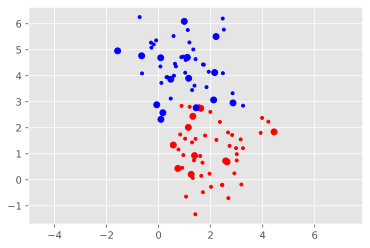

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_test.loc[y_test>0,0],X_test.loc[y_test>0,1],'ro',
         X_test.loc[y_test<=0,0],X_test.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

(-1.8774763389668039, 4.73916889797604, -2.6982524435588995, 7.594105043476921)

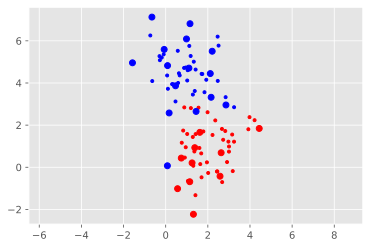

In [6]:
perturbation = Outliers(0.5, [1])
X_corrupted = perturbation(X_test.copy())

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_corrupted.loc[y_test>0,0],X_corrupted.loc[y_test>0,1],'ro',
         X_corrupted.loc[y_test<=0,0],X_corrupted.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

In [7]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = [0,1]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
clf = clf.fit(X_train, y_train)
print(f'Clean Test Score {clf.score(X_test, y_test)}')
print(f'Corrupted Test Score {clf.score(X_corrupted, y_test)}')

Clean Test Score 0.88
Corrupted Test Score 0.88


In [8]:
from jenga.cleaning.ppp import PipelineWithPPP
ppp = PipelineWithPPP(clf, 
                      numeric_columns=numeric_features, 
                      categorical_columns=[],
                      num_repetitions=5,
                      perturbation_fractions=[.1,.3, .5, .6, .75, .9, .99]
                     )

ppp.fit_ppp(X_train, y_train)
print(f'Predicted clean score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')
print(f'Predicted corrupted score: {ppp.predict_ppp(X_corrupted):.4f}, true score {clf.score(X_corrupted, y_test):.4f}')


Predicted clean score: 0.8782, true score 0.8800
Predicted corrupted score: 0.9138, true score 0.8800


In [9]:
ac = AutoClean(X_train, 
               y_train, 
               clf, 
               numeric_columns=[0,1], 
               categorical_columns=[]
              )
X_cleaned, predicted_score, cleaner_results_ppp, cleaner_results_true  = ac(X_corrupted.copy(deep=True), y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
        'ppp_score_cleaned': ppp.predict_ppp(X_cleaned)
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

perturbation:Outliers: {'fraction': 0.5, 'columns': [1]}
clean_data_test_score:0.88
corrupted_data_test_score:0.88
cleaned_data_test_score:0.88
ppp_score_corrupted:0.9137777777777778
ppp_score_cleaned:0.9137777777777778


In [10]:
cleaner_results_ppp, cleaner_results_true

([0.8711111111111112,
  0.8497777777777779,
  0.8711111111111112,
  0.8497777777777779],
 [0.88, 0.8, 0.88, 0.8])

# OpenML Example

In [3]:
corruptions = {
    'numeric':[Outliers, Scaling],
    'categorical':[SwapValues],
    'missing': [MissingValuesHighEntropy, 
                MissingValuesLowEntropy, 
                MissingValues]
}

def get_random_perturbation(numerical_columns, 
                            categorical_columns, 
                            fractions=[.2, .5, .7, .9]):
    '''
    Returns a random perturbation, chosen from either a numeric (swapping, outlier, scaling)
    or missingness
    '''
    
    if len(numerical_columns)>0 and len(categorical_columns)>0:
        perturbation_type = random.choice(list(corruptions.keys()))
    elif len(numerical_columns)>0:
        perturbation_type = 'numeric'
    elif len(categorical_columns)>0:
        perturbation_type = 'categorical'
    else:
        print("need at least one categorical or numeric column")
        
    random_fraction = random.choice(fractions)
    if perturbation_type is 'missing':
        missingness = random.choice(['MCAR', 'MAR', 'MNAR'])
        rand_column = random.choice(categorical_columns + numerical_columns)
        if rand_column in numerical_columns:
            missing_value = 0
        else:
            missing_value = ''
        return MissingValues(random_fraction, rand_column, missing_value, missingness)
    elif perturbation_type is 'numeric':
        perturbation = random.choice(corruptions[perturbation_type])
        rand_column = random.choice(numerical_columns)
        return perturbation(random_fraction, [rand_column])
    elif perturbation_type is 'categorical':
        rand_column = random.choice(categorical_columns)
        return SwapValues(random_fraction, rand_column)

# https://www.openml.org/search?q=qualities.NumberOfClasses%3A2%2520qualities.NumberOfInstances%3A100..10000%2520qualities.NumberOfFeatures%3A10..100&type=data
experiments = [
    'ionosphere',
    'sonar',
    'heart-statlog',
    'parkinsons',
    'KnuggetChase3',
    'Satellite',
    'fertility',
    'steel-plates-fault',
    'profb',
    'sick',
    'credit-g',
    'churn',
#     'bank-marketing',
    'cleve',
    'mushroom',
    'colic',
    'soybean'
 ]


In [4]:
def run_experiment(exp_id, n_perturbations=3):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    n_perturb = np.random.randint(1,n_perturbations)
    print(f'Applying {n_perturb} perturbations')
    X_corrupted = X_test.copy()
    for _ in range(n_perturb):
        perturbation = get_random_perturbation(numeric_features, categorical_features)
        print(perturbation)
        X_corrupted = perturbation(X_corrupted)

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numeric_columns=numeric_features, 
                   categorical_columns=categorical_features
                  )
    
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': predicted_score_no_cleaning,
            'ppp_score_cleaned': np.array(cleaner_results_ppp).max(),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result

In [5]:
results = []
for _ in range(20):
    results.append(run_experiment(random.choice(experiments)))

********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.754
Applying 2 perturbations
SwapValues: {'fraction': 0.2, 'column': 'Number_of_vessels_colored'}
MissingValues: {'column': 'Oldpeak', 'fraction': 0.9, 'na_value': 0, 'missingness': 'MAR'}
perturbation:MissingValues: {'column': 'Oldpeak', 'fraction': 0.9, 'na_value': 0, 'missingness': 'MAR'}
clean_data_test_score:0.7540983606557377
corrupted_data_test_score:0.7704918032786885
cleaned_data_test_score:0.7377049180327869
ppp_score_corrupted:0.8606060606060606
ppp_score_cleaned:0.8831955922865014
cleaner_results_ppp:[0.8606060606060606, 0.8785123966942148, 0.8606060606060606, 0.8831955922865014, 0.8630853994490358]
cleaner_results_true:[0.7704918032786885, 0.7377049180327869, 0.7704918032786885, 0.7377049180327869, 0.7704918032786885]
********************************************************************************
Fetching dataset

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9051094890510949
corrupted_data_test_score:0.8905109489051095
cleaned_data_test_score:0.7372262773722628
ppp_score_corrupted:0.9747252747252747
ppp_score_cleaned:0.9754578754578754
cleaner_results_ppp:[0.9747252747252747, 0.9748473748473748, 0.9754578754578754, 0.9731379731379731, 0.974969474969475]
cleaner_results_true:[0.8905109489051095, 0.8102189781021898, 0.7372262773722628, 0.7299270072992701, 0.8540145985401459]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9597069597069597]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9597069597069597]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9604395604395605]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8686131386861314]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9597069597069597]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9604395604395605]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9597069597069597]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9604395604395605]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9597069597069597]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.852
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Chest_pain_type'}
Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['Trestbps']}
clean_data_test_score:0.8524590163934426
corrupted_data_test_score:0.8524590163934426
cleaned_data_test_score:0.819

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

Traceback (most recent call last):
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 260, in train_and_save
    model = self.train_single(X_train, y_train, X_test, y_test, model, kfolds=kfolds, k_fold_start=k_fold_start, k_fold_end=k_fold_end, n_repeats=n_repeats, n_repeat_start=n_repeat_start, level=level, time_limit=time_limit)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/trainer/abstract_trainer.py", line 245, in train_single
    model.fit(X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, time_limit=time_limit, **model_fit_kwargs)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/models/knn/knn_model.py", line 58, in fit
    self.model = model.fit(X_train, Y_train)
  File "/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/neighbors/_base.py", line 1130, in fit
    X, y = check_X_

perturbation:SwapValues: {'fraction': 0.9, 'column': 'stem-cankers'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9713064713064713
ppp_score_cleaned:0.9713064713064713
cleaner_results_ppp:[0.9713064713064713, 0.971062271062271, 0.9544566544566545, 0.9581196581196582, 0.9597069597069597]
cleaner_results_true:[0.9562043795620438, 0.8759124087591241, 0.7956204379562044, 0.7591240875912408, 0.8759124087591241]


In [8]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')

In [9]:
cleaner_ppp = list(itertools.chain(*df_results['cleaner_results_ppp']))
cleaner_true = list(itertools.chain(*df_results['cleaner_results_true']))

In [7]:
def run_experiment_nonlinear(exp_id, n_perturbations=3):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])

    
    param_grid = {
            'n_estimators': np.arange(5, 100, 10)
        }

    classifier = GridSearchCV(RandomForestClassifier(), param_grid)
        
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    n_perturb = np.random.randint(1,n_perturbations)
    print(f'Applying {n_perturb} perturbations')
    X_corrupted = X_test.copy()
    for _ in range(n_perturb):
        perturbation = get_random_perturbation(numeric_features, categorical_features)
        print(perturbation)
        X_corrupted = perturbation(X_corrupted)

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numeric_columns=numeric_features, 
                   categorical_columns=categorical_features
                  )
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': predicted_score_no_cleaning,
            'ppp_score_cleaned': np.array(cleaner_results_ppp).max(),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result
    

In [57]:
df_results_nonlinear = pd.read_csv('results_nonlinear.csv')
df_results_nonlinear['cleaner_results_ppp'] = df_results_nonlinear['cleaner_results_ppp'].apply(lambda x: [float(y.strip()) for y in x[2:-3].split(',')])
df_results_nonlinear['cleaner_results_true'] = df_results_nonlinear['cleaner_results_true'].apply(lambda x: [float(y.strip()) for y in x[2:-3].split(',')])

In [8]:
results_nonlinear = []
for _ in range(30):
    results_nonlinear.append(run_experiment_nonlinear(random.choice(experiments)))

df_results_nonlinear = pd.DataFrame(results_nonlinear)
df_results_nonlinear.to_csv('results_nonlinear.csv')

********************************************************************************
Fetching dataset steel-plates-fault
Found 0 categorical and 33 numeric features
model score: 1.000
Applying 1 perturbations
Outliers: {'fraction': 0.9, 'columns': ['V5']}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_020314/
2020-03-28 03:03:14,696 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_020314/
Beginning AutoGluon training ...
2020-03-28 03:03:14,697 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_020314/
2020-03-28 03:03:14,698 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_020314/
Train Data Rows:    1552
2020-03-28 03:03:14,700 [INFO]  Train Data Rows:    1552
Train Data Columns: 33
2020-03-28 03:03:14,701 [INFO]  Train Data Columns: 33
Preprocessing data ...
2020-03-28 03:03:14,704 [INFO]  Preprocessing data ...
Feature Generator processed 1552 data points with 32 features
2020-03-28 03:03:14,785 [INFO]  Feature Generator processed 1552 data points with 32 features
Original Features:
2020-03-28 03:03:14,787 [INFO]  Original Features:
	float features: 32
2020-03-28 03:03:14,788 [INFO]  	f

2020-03-28 03:03:43,272 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-30.3491	 = Validation root_mean_squared_error score
2020-03-28 03:03:44,506 [INFO]  	-30.3491	 = Validation root_mean_squared_error score
	1.04s	 = Training runtime
2020-03-28 03:03:44,508 [INFO]  	1.04s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:03:44,509 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:03:44,515 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-15.8762	 = Validation root_mean_squared_error score
2020-03-28 03:03:45,491 [INFO]  	-15.8762	 = Validation root_mean_squared_error score
	0.75s	 = Training runtime
2020-03-28 03:03:45,493 [INFO]  	0.75s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:03:45,494 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:03:45,503 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-495.2325	 = Validation root_mean_squared_error score
202

[1000]	train_set's l2: 1.03963e+08	train_set's root_mean_squared_error: -10196.2	valid_set's l2: 1.57342e+10	valid_set's root_mean_squared_error: -125436
[2000]	train_set's l2: 3.77613e+06	train_set's root_mean_squared_error: -1943.23	valid_set's l2: 1.43931e+10	valid_set's root_mean_squared_error: -119971
[3000]	train_set's l2: 151278	train_set's root_mean_squared_error: -388.956	valid_set's l2: 1.42225e+10	valid_set's root_mean_squared_error: -119258
[4000]	train_set's l2: 5967.48	train_set's root_mean_squared_error: -77.2435	valid_set's l2: 1.42074e+10	valid_set's root_mean_squared_error: -119195


	-119189.6038	 = Validation root_mean_squared_error score
2020-03-28 03:04:20,215 [INFO]  	-119189.6038	 = Validation root_mean_squared_error score
	10.57s	 = Training runtime
2020-03-28 03:04:20,216 [INFO]  	10.57s	 = Training runtime
	0.05s	 = Validation runtime
2020-03-28 03:04:20,218 [INFO]  	0.05s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:04:20,232 [INFO]  Fitting model: CatboostRegressor ...
	-101149.8056	 = Validation root_mean_squared_error score
2020-03-28 03:04:22,588 [INFO]  	-101149.8056	 = Validation root_mean_squared_error score
	2.35s	 = Training runtime
2020-03-28 03:04:22,589 [INFO]  	2.35s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:04:22,591 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:04:22,597 [INFO]  Fitting model: NeuralNetRegressor ...
	-169315.1932	 = Validation root_mean_squared_error score
2020-03-28 03:04:34,859 [INFO]  	-169315.1932	 = Validation root_mean_squared_

[1000]	train_set's l2: 1.12879e+08	train_set's root_mean_squared_error: -10624.4	valid_set's l2: 1.59153e+10	valid_set's root_mean_squared_error: -126156
[2000]	train_set's l2: 3.42765e+06	train_set's root_mean_squared_error: -1851.39	valid_set's l2: 1.45334e+10	valid_set's root_mean_squared_error: -120554
[3000]	train_set's l2: 121074	train_set's root_mean_squared_error: -347.968	valid_set's l2: 1.43738e+10	valid_set's root_mean_squared_error: -119891
[4000]	train_set's l2: 4839.75	train_set's root_mean_squared_error: -69.5678	valid_set's l2: 1.43606e+10	valid_set's root_mean_squared_error: -119836


	-119833.9685	 = Validation root_mean_squared_error score
2020-03-28 03:04:52,039 [INFO]  	-119833.9685	 = Validation root_mean_squared_error score
	9.22s	 = Training runtime
2020-03-28 03:04:52,041 [INFO]  	9.22s	 = Training runtime
	0.05s	 = Validation runtime
2020-03-28 03:04:52,042 [INFO]  	0.05s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:04:52,054 [INFO]  Fitting model: CatboostRegressor ...
	-94498.6532	 = Validation root_mean_squared_error score
2020-03-28 03:04:54,142 [INFO]  	-94498.6532	 = Validation root_mean_squared_error score
	2.07s	 = Training runtime
2020-03-28 03:04:54,144 [INFO]  	2.07s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:04:54,148 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:04:54,155 [INFO]  Fitting model: NeuralNetRegressor ...
	-220975.8808	 = Validation root_mean_squared_error score
2020-03-28 03:05:08,771 [INFO]  	-220975.8808	 = Validation root_mean_squared_erro

2020-03-28 03:05:38,926 [INFO]  AutoGluon training complete, total runtime = 25.65s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_020538/
2020-03-28 03:05:38,929 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_020538/
Beginning AutoGluon training ...
2020-03-28 03:05:38,931 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_020538/
2020-03-28 03:05:38,933 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_020538/
Train Data Rows:    1552
2020-03-28 03:05:38,934 [INFO]  Train Data Rows:    1552
Train Data Columns: 33
2020-03-28 03:05:38,936 [INFO]  Train Data Columns: 33
Preprocessing data ...
2020-03-28 03:05:38,938 [INFO]  Preprocessing data ...
Feature Generator processed 1552 data points with 32 features
2020-03-28 03:05:39,008 [INFO]  Feature Generator processed 1552 data points with 32 features
Original Features:
2020-03-28 03:05:

Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:06:00,585 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-13.6684	 = Validation root_mean_squared_error score
2020-03-28 03:06:01,708 [INFO]  	-13.6684	 = Validation root_mean_squared_error score
	0.95s	 = Training runtime
2020-03-28 03:06:01,710 [INFO]  	0.95s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:06:01,711 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:06:01,717 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-12.9215	 = Validation root_mean_squared_error score
2020-03-28 03:06:02,568 [INFO]  	-12.9215	 = Validation root_mean_squared_error score
	0.63s	 = Training runtime
2020-03-28 03:06:02,570 [INFO]  	0.63s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:06:02,571 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:06:02,578 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-38.2438	 = V

	0.01s	 = Validation runtime
2020-03-28 03:06:30,396 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:06:30,399 [INFO]  Fitting model: CatboostRegressor ...
	-42891.095	 = Validation root_mean_squared_error score
2020-03-28 03:06:33,467 [INFO]  	-42891.095	 = Validation root_mean_squared_error score
	3.06s	 = Training runtime
2020-03-28 03:06:33,468 [INFO]  	3.06s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:06:33,469 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:06:33,474 [INFO]  Fitting model: NeuralNetRegressor ...
	-26431.1879	 = Validation root_mean_squared_error score
2020-03-28 03:06:45,325 [INFO]  	-26431.1879	 = Validation root_mean_squared_error score
	11.65s	 = Training runtime
2020-03-28 03:06:45,328 [INFO]  	11.65s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 03:06:45,329 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-2

Beginning AutoGluon training ...
2020-03-28 03:07:08,271 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_020708/
2020-03-28 03:07:08,272 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_020708/
Train Data Rows:    1552
2020-03-28 03:07:08,274 [INFO]  Train Data Rows:    1552
Train Data Columns: 33
2020-03-28 03:07:08,275 [INFO]  Train Data Columns: 33
Preprocessing data ...
2020-03-28 03:07:08,277 [INFO]  Preprocessing data ...
Feature Generator processed 1552 data points with 32 features
2020-03-28 03:07:08,351 [INFO]  Feature Generator processed 1552 data points with 32 features
Original Features:
2020-03-28 03:07:08,352 [INFO]  Original Features:
	float features: 32
2020-03-28 03:07:08,353 [INFO]  	float features: 32
Generated Features:
2020-03-28 03:07:08,355 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:07:08,356 [INFO]  	int features: 0
All Features:
2020-03-28 03:07:08,357 [INFO]  All Features:
	flo

	1.15s	 = Training runtime
2020-03-28 03:07:32,622 [INFO]  	1.15s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:07:32,623 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:07:32,629 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-72.5354	 = Validation root_mean_squared_error score
2020-03-28 03:07:33,376 [INFO]  	-72.5354	 = Validation root_mean_squared_error score
	0.53s	 = Training runtime
2020-03-28 03:07:33,377 [INFO]  	0.53s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:07:33,378 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:07:33,385 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-143.7382	 = Validation root_mean_squared_error score
2020-03-28 03:07:33,534 [INFO]  	-143.7382	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:07:33,536 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:07:

	3.21s	 = Training runtime
2020-03-28 03:08:01,801 [INFO]  	3.21s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:08:01,802 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:08:01,806 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.0026	 = Validation root_mean_squared_error score
2020-03-28 03:08:18,959 [INFO]  	-0.0026	 = Validation root_mean_squared_error score
	16.94s	 = Training runtime
2020-03-28 03:08:18,962 [INFO]  	16.94s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 03:08:18,963 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:08:18,966 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.3726	 = Validation root_mean_squared_error score
2020-03-28 03:08:20,151 [INFO]  	-0.3726	 = Validation root_mean_squared_error score
	1.17s	 = Training runtime
2020-03-28 03:08:20,153 [INFO]  	1.17s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:08:20,154 [INFO

Train Data Columns: 33
2020-03-28 03:08:41,958 [INFO]  Train Data Columns: 33
Preprocessing data ...
2020-03-28 03:08:41,960 [INFO]  Preprocessing data ...
Feature Generator processed 1552 data points with 32 features
2020-03-28 03:08:42,029 [INFO]  Feature Generator processed 1552 data points with 32 features
Original Features:
2020-03-28 03:08:42,030 [INFO]  Original Features:
	float features: 32
2020-03-28 03:08:42,032 [INFO]  	float features: 32
Generated Features:
2020-03-28 03:08:42,036 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:08:42,038 [INFO]  	int features: 0
All Features:
2020-03-28 03:08:42,039 [INFO]  All Features:
	float features: 32
2020-03-28 03:08:42,041 [INFO]  	float features: 32
	int features: 0
2020-03-28 03:08:42,042 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.08s ...
2020-03-28 03:08:42,044 [INFO]  	Data preprocessing and feature engineering runtime = 0.08s ...
AutoGluon will gauge predictive performance using 

2020-03-28 03:09:00,373 [INFO]  	-0.0141	 = Validation root_mean_squared_error score
	0.64s	 = Training runtime
2020-03-28 03:09:00,374 [INFO]  	0.64s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:09:00,376 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:09:00,383 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.2899	 = Validation root_mean_squared_error score
2020-03-28 03:09:00,529 [INFO]  	-0.2899	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:09:00,531 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:09:00,533 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:09:00,536 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.289	 = Validation root_mean_squared_error score
2020-03-28 03:09:00,688 [INFO]  	-0.289	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:09:00,691 [I

2020-03-28 03:10:14,866 [INFO]  	-0.0331	 = Validation root_mean_squared_error score
	36.02s	 = Training runtime
2020-03-28 03:10:14,869 [INFO]  	36.02s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 03:10:14,869 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:10:14,873 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.0665	 = Validation root_mean_squared_error score
2020-03-28 03:10:17,272 [INFO]  	-0.0665	 = Validation root_mean_squared_error score
	2.33s	 = Training runtime
2020-03-28 03:10:17,274 [INFO]  	2.33s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:10:17,276 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:10:18,283 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.033	 = Validation root_mean_squared_error score
2020-03-28 03:10:18,816 [INFO]  	-0.033	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 03:10:18,818 

Original Features:
2020-03-28 03:10:49,738 [INFO]  Original Features:
	float features: 32
2020-03-28 03:10:49,740 [INFO]  	float features: 32
Generated Features:
2020-03-28 03:10:49,741 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:10:49,743 [INFO]  	int features: 0
All Features:
2020-03-28 03:10:49,744 [INFO]  All Features:
	float features: 32
2020-03-28 03:10:49,745 [INFO]  	float features: 32
	int features: 0
2020-03-28 03:10:49,746 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.08s ...
2020-03-28 03:10:49,747 [INFO]  	Data preprocessing and feature engineering runtime = 0.08s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:10:49,748 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:10:49,749 [INFO]  To change this, specify the eval_metric argument o

	-0.2184	 = Validation root_mean_squared_error score
2020-03-28 03:11:06,330 [INFO]  	-0.2184	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 03:11:06,333 [INFO]  	0.03s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:11:06,334 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:11:06,340 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.2241	 = Validation root_mean_squared_error score
2020-03-28 03:11:06,491 [INFO]  	-0.2241	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:11:06,493 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:11:06,495 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 03:11:06,498 [INFO]  Fitting model: LightGBMRegressor ...
	-0.0513	 = Validation root_mean_squared_error score
2020-03-28 03:11:07,462 [INFO]  	-0.0513	 = Validation root_mean_squared_error score
	0.94s	 = 

	-0.0726	 = Validation root_mean_squared_error score
2020-03-28 03:12:00,974 [INFO]  	-0.0726	 = Validation root_mean_squared_error score
	1.6s	 = Training runtime
2020-03-28 03:12:00,976 [INFO]  	1.6s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:12:00,977 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:12:01,905 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.043	 = Validation root_mean_squared_error score
2020-03-28 03:12:02,446 [INFO]  	-0.043	 = Validation root_mean_squared_error score
	0.53s	 = Training runtime
2020-03-28 03:12:02,448 [INFO]  	0.53s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:12:02,449 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 23.1s ...
2020-03-28 03:12:02,453 [INFO]  AutoGluon training complete, total runtime = 23.1s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_021202/
2020-03-28 03:12:02,456 [L

2020-03-28 03:12:23,300 [INFO]  	float features: 32
	int features: 0
2020-03-28 03:12:23,302 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.09s ...
2020-03-28 03:12:23,303 [INFO]  	Data preprocessing and feature engineering runtime = 0.09s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:12:23,305 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:12:23,307 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 03:12:23,308 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:12:23,316 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0059	 = Validation root_mean

Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:13:03,194 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.221	 = Validation root_mean_squared_error score
2020-03-28 03:13:03,346 [INFO]  	-0.221	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:13:03,348 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:13:03,350 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 03:13:03,353 [INFO]  Fitting model: LightGBMRegressor ...
	-0.0234	 = Validation root_mean_squared_error score
2020-03-28 03:13:03,860 [INFO]  	-0.0234	 = Validation root_mean_squared_error score
	0.5s	 = Training runtime
2020-03-28 03:13:03,861 [INFO]  	0.5s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:13:03,863 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:13:03,865 [INFO]  Fitting model: CatboostRegressor ...
	-0.0164	 = Validation root_mean_squared_error

Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:14:07,798 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.0165	 = Validation root_mean_squared_error score
2020-03-28 03:14:08,328 [INFO]  	-0.0165	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 03:14:08,330 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:14:08,331 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 29.37s ...
2020-03-28 03:14:08,335 [INFO]  AutoGluon training complete, total runtime = 29.37s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_021408/
2020-03-28 03:14:08,338 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_021408/
Beginning AutoGluon training ...
2020-03-28 03:14:08,340 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_021408/
2020-03-28 03:14:08,342 [INFO]  AutoGluon 

2020-03-28 03:14:38,048 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:14:38,049 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 03:14:38,051 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:14:38,059 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0384	 = Validation root_mean_squared_error score
2020-03-28 03:14:39,327 [INFO]  	-0.0384	 = Validation root_mean_squared_error score
	1.06s	 = Training runtime
2020-03-28 03:14:39,328 [INFO]  	1.06s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:14:39,330 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:14:39,336 [INFO]  Fitting model: 

	0.12s	 = Validation runtime
2020-03-28 03:14:59,344 [INFO]  	0.12s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 03:14:59,347 [INFO]  Fitting model: LightGBMRegressor ...
	-0.024	 = Validation root_mean_squared_error score
2020-03-28 03:14:59,841 [INFO]  	-0.024	 = Validation root_mean_squared_error score
	0.48s	 = Training runtime
2020-03-28 03:14:59,843 [INFO]  	0.48s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:14:59,845 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:14:59,847 [INFO]  Fitting model: CatboostRegressor ...
	-0.0193	 = Validation root_mean_squared_error score
2020-03-28 03:15:04,004 [INFO]  	-0.0193	 = Validation root_mean_squared_error score
	4.15s	 = Training runtime
2020-03-28 03:15:04,005 [INFO]  	4.15s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:15:04,007 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:15:04,012 [INFO]  Fi

	0.0s	 = Validation runtime
2020-03-28 03:15:31,594 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 13.18s ...
2020-03-28 03:15:31,599 [INFO]  AutoGluon training complete, total runtime = 13.18s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_021531/
2020-03-28 03:15:31,602 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_021531/
Beginning AutoGluon training ...
2020-03-28 03:15:31,604 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_021531/
2020-03-28 03:15:31,605 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_021531/
Train Data Rows:    1552
2020-03-28 03:15:31,607 [INFO]  Train Data Rows:    1552
Train Data Columns: 33
2020-03-28 03:15:31,609 [INFO]  Train Data Columns: 33
Preprocessing data ...
2020-03-28 03:15:31,612 [INFO]  Preprocessing data ...
Feature Generator processed 1552 data points wit

AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 03:15:51,004 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:15:51,012 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.1438	 = Validation root_mean_squared_error score
2020-03-28 03:15:51,793 [INFO]  	-0.1438	 = Validation root_mean_squared_error score
	0.64s	 = Training runtime
2020-03-28 03:15:51,795 [INFO]  	0.64s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:15:51,796 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:15:51,799 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.1219	 = Validation root_mean_squared_error score
2020-03-28 03:15:52,276 [INFO]  	-0.1219	 = Validation root_mean_squared_error score
	0.34s	 = Training runtime
2020-03-28 03:15:52,278 [INFO]  	0.34s	 = Training runtime
	0.12s	 = Validation runti

	0.57s	 = Training runtime
2020-03-28 03:16:16,397 [INFO]  	0.57s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:16:16,398 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:16:16,401 [INFO]  Fitting model: CatboostRegressor ...
	-0.0547	 = Validation root_mean_squared_error score
2020-03-28 03:16:18,924 [INFO]  	-0.0547	 = Validation root_mean_squared_error score
	2.51s	 = Training runtime
2020-03-28 03:16:18,926 [INFO]  	2.51s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:16:18,928 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:16:18,931 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.0074	 = Validation root_mean_squared_error score
2020-03-28 03:16:29,995 [INFO]  	-0.0074	 = Validation root_mean_squared_error score
	10.86s	 = Training runtime
2020-03-28 03:16:29,998 [INFO]  	10.86s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 03:16:29,999 [INFO]  	0.18s	 =

Beginning AutoGluon training ...
2020-03-28 03:16:46,865 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_021646/
2020-03-28 03:16:46,867 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_021646/
Train Data Rows:    1552
2020-03-28 03:16:46,868 [INFO]  Train Data Rows:    1552
Train Data Columns: 33
2020-03-28 03:16:46,870 [INFO]  Train Data Columns: 33
Preprocessing data ...
2020-03-28 03:16:46,872 [INFO]  Preprocessing data ...
Feature Generator processed 1552 data points with 32 features
2020-03-28 03:16:46,946 [INFO]  Feature Generator processed 1552 data points with 32 features
Original Features:
2020-03-28 03:16:46,947 [INFO]  Original Features:
	float features: 32
2020-03-28 03:16:46,949 [INFO]  	float features: 32
Generated Features:
2020-03-28 03:16:46,951 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:16:46,953 [INFO]  	int features: 0
All Features:
2020-03-28 03:16:46,954 [INFO]  All Features:
	flo

2020-03-28 03:19:40,054 [INFO]  {
    "root_mean_squared_error": 12460.963411717788,
    "mean_absolute_error": 6127.947668347989,
    "explained_variance_score": 0.9999270969715657,
    "r2_score": 0.9999221299213213,
    "pearson_correlation": 0.9999638007656226,
    "mean_squared_error": 155275609.14816943,
    "median_absolute_error": 2797.567109374999
}
Evaluation: root_mean_squared_error on test data: 17846.42014622719
2020-03-28 03:19:40,294 [INFO]  Evaluation: root_mean_squared_error on test data: 17846.42014622719
Evaluations on test data:
2020-03-28 03:19:40,299 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 17846.42014622719,
    "mean_absolute_error": 5653.1670179948605,
    "explained_variance_score": 0.9998432799178294,
    "r2_score": 0.9998402952154345,
    "pearson_correlation": 0.9999221199137958,
    "mean_squared_error": 318494712.0356637,
    "median_absolute_error": 1012.75
}
2020-03-28 03:19:40,300 [INFO]  {
    "root_mean_squared_error": 1784

2020-03-28 03:19:43,497 [INFO]  {
    "root_mean_squared_error": 0.0,
    "mean_absolute_error": 0.0,
    "explained_variance_score": 1.0,
    "r2_score": 1.0,
    "pearson_correlation": 1.0,
    "mean_squared_error": 0.0,
    "median_absolute_error": 0.0
}
Evaluation: root_mean_squared_error on test data: 0.0
2020-03-28 03:19:43,656 [INFO]  Evaluation: root_mean_squared_error on test data: 0.0
Evaluations on test data:
2020-03-28 03:19:43,661 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.0,
    "mean_absolute_error": 0.0,
    "explained_variance_score": 1.0,
    "r2_score": 1.0,
    "pearson_correlation": 1.0,
    "mean_squared_error": 0.0,
    "median_absolute_error": 0.0
}
2020-03-28 03:19:43,663 [INFO]  {
    "root_mean_squared_error": 0.0,
    "mean_absolute_error": 0.0,
    "explained_variance_score": 1.0,
    "r2_score": 1.0,
    "pearson_correlation": 1.0,
    "mean_squared_error": 0.0,
    "median_absolute_error": 0.0
}
Evaluation: root_mean_squared_erro

2020-03-28 03:19:46,517 [INFO]  {
    "root_mean_squared_error": 0.020287141824153452,
    "mean_absolute_error": 0.002082262210796915,
    "explained_variance_score": 0.9982622905539663,
    "r2_score": 0.9982447006101943,
    "pearson_correlation": 0.9991327761795656,
    "mean_squared_error": 0.00041156812339331625,
    "median_absolute_error": 0.0
}
Evaluation: root_mean_squared_error on test data: 1.0290346039791445
2020-03-28 03:19:47,167 [INFO]  Evaluation: root_mean_squared_error on test data: 1.0290346039791445
Evaluations on test data:
2020-03-28 03:19:47,173 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 1.0290346039791445,
    "mean_absolute_error": 0.7083512993223411,
    "explained_variance_score": -0.6613196044169589,
    "r2_score": -0.6629647490040769,
    "pearson_correlation": 0.4583612580504984,
    "mean_squared_error": 1.0589122161865145,
    "median_absolute_error": 0.5945944840709649
}
2020-03-28 03:19:47,174 [INFO]  {
    "root_mean_squared_

Evaluations on test data:
2020-03-28 03:19:50,900 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.17661065097970255,
    "mean_absolute_error": 0.06569564173926958,
    "explained_variance_score": 0.8054685109997365,
    "r2_score": 0.8035338810216746,
    "pearson_correlation": 0.8986465498173591,
    "mean_squared_error": 0.031191322039474306,
    "median_absolute_error": 0.009402908759596741
}
2020-03-28 03:19:50,901 [INFO]  {
    "root_mean_squared_error": 0.17661065097970255,
    "mean_absolute_error": 0.06569564173926958,
    "explained_variance_score": 0.8054685109997365,
    "r2_score": 0.8035338810216746,
    "pearson_correlation": 0.8986465498173591,
    "mean_squared_error": 0.031191322039474306,
    "median_absolute_error": 0.009402908759596741
}
Evaluation: root_mean_squared_error on test data: 0.21304093411069713
2020-03-28 03:19:51,154 [INFO]  Evaluation: root_mean_squared_error on test data: 0.21304093411069713
Evaluations on test data:
2020-03-28 0

perturbation:Outliers: {'fraction': 0.9, 'columns': ['V5']}
clean_data_test_score:1.0
corrupted_data_test_score:1.0
cleaned_data_test_score:1.0
ppp_score_corrupted:0.9891752577319591
ppp_score_cleaned:0.9891752577319591
cleaner_results_ppp:[0.9891752577319591, 0.937414089347079, 0.9891752577319591, 0.9128865979381442, 0.9125859106529208]
cleaner_results_true:[1.0, 0.9665809768637532, 1.0, 0.9331619537275064, 0.7480719794344473]
********************************************************************************
Fetching dataset churn
Found 4 categorical and 16 numeric features
model score: 0.953
Applying 1 perturbations
Scaling: {'fraction': 0.9, 'columns': ['state']}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_022008/
2020-03-28 03:20:08,881 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_022008/
Beginning AutoGluon training ...
2020-03-28 03:20:08,883 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_022008/
2020-03-28 03:20:08,884 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_022008/
Train Data Rows:    4000
2020-03-28 03:20:08,885 [INFO]  Train Data Rows:    4000
Train Data Columns: 20
2020-03-28 03:20:08,886 [INFO]  Train Data Columns: 20
Preprocessing data ...
2020-03-28 03:20:08,887 [INFO]  Preprocessing data ...
Feature Generator processed 4000 data points with 19 features
2020-03-28 03:20:08,962 [INFO]  Feature Generator processed 4000 data points with 19 features
Original Features:
2020-03-28 03:20:08,963 [INFO]  Original Features:
	float features: 16
2020-03-28 03:20:08,965 [INFO]  	f

Feature Generator processed 3997 data points with 19 features
2020-03-28 03:20:28,422 [INFO]  Feature Generator processed 3997 data points with 19 features
Original Features:
2020-03-28 03:20:28,423 [INFO]  Original Features:
	float features: 16
2020-03-28 03:20:28,424 [INFO]  	float features: 16
	object features: 3
2020-03-28 03:20:28,426 [INFO]  	object features: 3
Generated Features:
2020-03-28 03:20:28,428 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:20:28,429 [INFO]  	int features: 0
All Features:
2020-03-28 03:20:28,431 [INFO]  All Features:
	float features: 16
2020-03-28 03:20:28,432 [INFO]  	float features: 16
	object features: 3
2020-03-28 03:20:28,433 [INFO]  	object features: 3
	int features: 0
2020-03-28 03:20:28,435 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.09s ...
2020-03-28 03:20:28,437 [INFO]  	Data preprocessing and feature engineering runtime = 0.09s ...
AutoGluon will gauge predictive performance using evaluation m

Fitting model: RandomForestClassifierGini ...
2020-03-28 03:20:55,517 [INFO]  Fitting model: RandomForestClassifierGini ...
	1.0	 = Validation accuracy score
2020-03-28 03:20:56,311 [INFO]  	1.0	 = Validation accuracy score
	0.65s	 = Training runtime
2020-03-28 03:20:56,312 [INFO]  	0.65s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:20:56,313 [INFO]  	0.12s	 = Validation runtime
Fitting model: RandomForestClassifierEntr ...
2020-03-28 03:20:56,316 [INFO]  Fitting model: RandomForestClassifierEntr ...
	1.0	 = Validation accuracy score
2020-03-28 03:20:57,113 [INFO]  	1.0	 = Validation accuracy score
	0.65s	 = Training runtime
2020-03-28 03:20:57,114 [INFO]  	0.65s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:20:57,115 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesClassifierGini ...
2020-03-28 03:20:57,118 [INFO]  Fitting model: ExtraTreesClassifierGini ...
	1.0	 = Validation accuracy score
2020-03-28 03:20:57,720 [INFO]  	1.0	 = Valida

	0.54s	 = Training runtime
2020-03-28 03:22:40,044 [INFO]  	0.54s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:22:40,046 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsClassifierUnif ...
2020-03-28 03:22:40,053 [INFO]  Fitting model: KNeighborsClassifierUnif ...
	0.9	 = Validation accuracy score
2020-03-28 03:22:40,194 [INFO]  	0.9	 = Validation accuracy score
	0.02s	 = Training runtime
2020-03-28 03:22:40,196 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:22:40,197 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsClassifierDist ...
2020-03-28 03:22:40,201 [INFO]  Fitting model: KNeighborsClassifierDist ...
	0.9	 = Validation accuracy score
2020-03-28 03:22:40,339 [INFO]  	0.9	 = Validation accuracy score
	0.02s	 = Training runtime
2020-03-28 03:22:40,341 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:22:40,344 [INFO]  	0.12s	 = Validation runtime
Fitting model: LightGBMClassifie

	0.17s	 = Validation runtime
2020-03-28 03:23:02,922 [INFO]  	0.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:23:02,925 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-14.5184	 = Validation root_mean_squared_error score
2020-03-28 03:23:03,990 [INFO]  	-14.5184	 = Validation root_mean_squared_error score
	1.05s	 = Training runtime
2020-03-28 03:23:03,991 [INFO]  	1.05s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:23:03,993 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:23:05,223 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-14.4597	 = Validation root_mean_squared_error score
2020-03-28 03:23:05,738 [INFO]  	-14.4597	 = Validation root_mean_squared_error score
	0.5s	 = Training runtime
2020-03-28 03:23:05,739 [INFO]  	0.5s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:23:05,741 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1

Original Features:
2020-03-28 03:23:19,007 [INFO]  Original Features:
	float features: 15
2020-03-28 03:23:19,009 [INFO]  	float features: 15
	object features: 4
2020-03-28 03:23:19,010 [INFO]  	object features: 4
Generated Features:
2020-03-28 03:23:19,011 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:23:19,012 [INFO]  	int features: 0
All Features:
2020-03-28 03:23:19,014 [INFO]  All Features:
	float features: 15
2020-03-28 03:23:19,015 [INFO]  	float features: 15
	object features: 4
2020-03-28 03:23:19,016 [INFO]  	object features: 4
	int features: 0
2020-03-28 03:23:19,017 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.08s ...
2020-03-28 03:23:19,019 [INFO]  	Data preprocessing and feature engineering runtime = 0.08s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:23:19,020 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_er

2020-03-28 03:23:34,601 [INFO]  	-4.3289	 = Validation root_mean_squared_error score
	0.53s	 = Training runtime
2020-03-28 03:23:34,602 [INFO]  	0.53s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:23:34,603 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:23:34,609 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-15.5128	 = Validation root_mean_squared_error score
2020-03-28 03:23:34,752 [INFO]  	-15.5128	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:23:34,753 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:23:34,755 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:23:34,757 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-15.5525	 = Validation root_mean_squared_error score
2020-03-28 03:23:34,891 [INFO]  	-15.5525	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:23:34,

Fitting model: NeuralNetRegressor ...
2020-03-28 03:24:01,593 [INFO]  Fitting model: NeuralNetRegressor ...
	-1.6244	 = Validation root_mean_squared_error score
2020-03-28 03:24:50,492 [INFO]  	-1.6244	 = Validation root_mean_squared_error score
	48.71s	 = Training runtime
2020-03-28 03:24:50,494 [INFO]  	48.71s	 = Training runtime
	0.17s	 = Validation runtime
2020-03-28 03:24:50,496 [INFO]  	0.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:24:50,499 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-3.181	 = Validation root_mean_squared_error score
2020-03-28 03:24:54,689 [INFO]  	-3.181	 = Validation root_mean_squared_error score
	4.05s	 = Training runtime
2020-03-28 03:24:54,690 [INFO]  	4.05s	 = Training runtime
	0.02s	 = Validation runtime
2020-03-28 03:24:54,692 [INFO]  	0.02s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:24:55,819 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.2591	 = Validation root_

Train Data Columns: 20
2020-03-28 03:25:09,775 [INFO]  Train Data Columns: 20
Preprocessing data ...
2020-03-28 03:25:09,776 [INFO]  Preprocessing data ...
Feature Generator processed 4000 data points with 19 features
2020-03-28 03:25:09,837 [INFO]  Feature Generator processed 4000 data points with 19 features
Original Features:
2020-03-28 03:25:09,839 [INFO]  Original Features:
	float features: 15
2020-03-28 03:25:09,841 [INFO]  	float features: 15
	object features: 4
2020-03-28 03:25:09,842 [INFO]  	object features: 4
Generated Features:
2020-03-28 03:25:09,844 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:25:09,845 [INFO]  	int features: 0
All Features:
2020-03-28 03:25:09,846 [INFO]  All Features:
	float features: 15
2020-03-28 03:25:09,848 [INFO]  	float features: 15
	object features: 4
2020-03-28 03:25:09,850 [INFO]  	object features: 4
	int features: 0
2020-03-28 03:25:09,851 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.08s ...
20

	0.13s	 = Validation runtime
2020-03-28 03:26:09,937 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:26:09,946 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.3017	 = Validation root_mean_squared_error score
2020-03-28 03:26:11,062 [INFO]  	-0.3017	 = Validation root_mean_squared_error score
	0.85s	 = Training runtime
2020-03-28 03:26:11,063 [INFO]  	0.85s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:26:11,064 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:26:11,073 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-54.6499	 = Validation root_mean_squared_error score
2020-03-28 03:26:11,210 [INFO]  	-54.6499	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:26:11,211 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:26:11,212 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
202

2020-03-28 03:27:29,838 [INFO]  	-19.2154	 = Validation root_mean_squared_error score
	1.03s	 = Training runtime
2020-03-28 03:27:29,840 [INFO]  	1.03s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:27:29,841 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:27:29,844 [INFO]  Fitting model: NeuralNetRegressor ...
	-19.736	 = Validation root_mean_squared_error score
2020-03-28 03:27:34,953 [INFO]  	-19.736	 = Validation root_mean_squared_error score
	4.92s	 = Training runtime
2020-03-28 03:27:34,955 [INFO]  	4.92s	 = Training runtime
	0.17s	 = Validation runtime
2020-03-28 03:27:34,956 [INFO]  	0.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:27:34,959 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-19.235	 = Validation root_mean_squared_error score
2020-03-28 03:27:35,978 [INFO]  	-19.235	 = Validation root_mean_squared_error score
	1.0s	 = Training runtime
2020-03-28 03:27:35,979 [INFO]  	1

AutoGluon will save models to AutogluonModels/ag-20200328_022853/
2020-03-28 03:28:53,604 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_022853/
Train Data Rows:    4000
2020-03-28 03:28:53,606 [INFO]  Train Data Rows:    4000
Train Data Columns: 20
2020-03-28 03:28:53,607 [INFO]  Train Data Columns: 20
Preprocessing data ...
2020-03-28 03:28:53,608 [INFO]  Preprocessing data ...
Feature Generator processed 4000 data points with 19 features
2020-03-28 03:28:53,675 [INFO]  Feature Generator processed 4000 data points with 19 features
Original Features:
2020-03-28 03:28:53,677 [INFO]  Original Features:
	float features: 15
2020-03-28 03:28:53,678 [INFO]  	float features: 15
	object features: 4
2020-03-28 03:28:53,680 [INFO]  	object features: 4
Generated Features:
2020-03-28 03:28:53,681 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:28:53,683 [INFO]  	int features: 0
All Features:
2020-03-28 03:28:53,684 [INFO]  All Features:
	float features: 15
2020-03-28

	-19.0545	 = Validation root_mean_squared_error score
2020-03-28 03:30:19,943 [INFO]  	-19.0545	 = Validation root_mean_squared_error score
	2.45s	 = Training runtime
2020-03-28 03:30:19,944 [INFO]  	2.45s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:30:19,946 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:30:19,959 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-19.1829	 = Validation root_mean_squared_error score
2020-03-28 03:30:21,593 [INFO]  	-19.1829	 = Validation root_mean_squared_error score
	1.17s	 = Training runtime
2020-03-28 03:30:21,595 [INFO]  	1.17s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:30:21,596 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:30:21,615 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-20.5302	 = Validation root_mean_squared_error score
2020-03-28 03:30:21,756 [INFO]  	-20.5302	 = Validation root_mean_squared_error 

2020-03-28 03:30:34,591 [INFO]  	0.02s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:30:34,594 [INFO]  Fitting model: CatboostRegressor ...
	-0.0705	 = Validation root_mean_squared_error score
2020-03-28 03:30:43,317 [INFO]  	-0.0705	 = Validation root_mean_squared_error score
	8.71s	 = Training runtime
2020-03-28 03:30:43,318 [INFO]  	8.71s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:30:43,320 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:30:43,327 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.0429	 = Validation root_mean_squared_error score
2020-03-28 03:31:46,515 [INFO]  	-0.0429	 = Validation root_mean_squared_error score
	63.0s	 = Training runtime
2020-03-28 03:31:46,517 [INFO]  	63.0s	 = Training runtime
	0.17s	 = Validation runtime
2020-03-28 03:31:46,519 [INFO]  	0.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:31:46,522 [INFO]  Fitting model: LightGB

2020-03-28 03:33:00,395 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_023300/
Beginning AutoGluon training ...
2020-03-28 03:33:00,397 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_023300/
2020-03-28 03:33:00,398 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_023300/
Train Data Rows:    4000
2020-03-28 03:33:00,400 [INFO]  Train Data Rows:    4000
Train Data Columns: 20
2020-03-28 03:33:00,400 [INFO]  Train Data Columns: 20
Preprocessing data ...
2020-03-28 03:33:00,402 [INFO]  Preprocessing data ...
Feature Generator processed 4000 data points with 19 features
2020-03-28 03:33:00,463 [INFO]  Feature Generator processed 4000 data points with 19 features
Original Features:
2020-03-28 03:33:00,465 [INFO]  Original Features:
	float features: 15
2020-03-28 03:33:00,466 [INFO]  	float features: 15
	object features: 4
2020-03-28 03:33:00,468 [INFO]  	object features: 4
Ge

2020-03-28 03:33:14,308 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:33:14,319 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0016	 = Validation root_mean_squared_error score
2020-03-28 03:33:15,542 [INFO]  	-0.0016	 = Validation root_mean_squared_error score
	1.07s	 = Training runtime
2020-03-28 03:33:15,544 [INFO]  	1.07s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:33:15,545 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:33:15,548 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.001	 = Validation root_mean_squared_error score
2020-03-28 03:33:16,249 [INFO]  	-0.001	 = Validation root_mean_squared_error score
	0.55s	 = Training runtime
2020-03-28 03:33:16,252 [INFO]  	0.55s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:33:16,254 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeig

2020-03-28 03:44:53,046 [INFO]  {
    "0": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 189
    },
    "1": {
        "precision": 0.37349397590361444,
        "recall": 0.9973190348525469,
        "f1-score": 0.5434623813002192,
        "support": 373
    },
    "2": {
        "precision": 0.3333333333333333,
        "recall": 0.004651162790697674,
        "f1-score": 0.009174311926605505,
        "support": 215
    },
    "3": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 150
    },
    "4": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 51
    },
    "5": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 16
    },
    "6": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 2
    },
    "7": {
        "precision": 0.0,
        "recall": 0.0,
        "f

Evaluation: root_mean_squared_error on test data: 4.249574128711677
2020-03-28 03:44:54,988 [INFO]  Evaluation: root_mean_squared_error on test data: 4.249574128711677
Evaluations on test data:
2020-03-28 03:44:54,995 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 4.249574128711677,
    "mean_absolute_error": 1.8522763203665433,
    "explained_variance_score": 0.897366489651824,
    "r2_score": 0.8972253379003875,
    "pearson_correlation": 0.9472967662573264,
    "mean_squared_error": 18.05888027541561,
    "median_absolute_error": 0.2573791938872926
}
2020-03-28 03:44:54,996 [INFO]  {
    "root_mean_squared_error": 4.249574128711677,
    "mean_absolute_error": 1.8522763203665433,
    "explained_variance_score": 0.897366489651824,
    "r2_score": 0.8972253379003875,
    "pearson_correlation": 0.9472967662573264,
    "mean_squared_error": 18.05888027541561,
    "median_absolute_error": 0.2573791938872926
}
Evaluation: root_mean_squared_error on test data: 0.21962522

2020-03-28 03:44:58,409 [INFO]  {
    "root_mean_squared_error": 20.247149103179567,
    "mean_absolute_error": 16.271514856928327,
    "explained_variance_score": -0.007427776255036989,
    "r2_score": -0.010455413147938852,
    "pearson_correlation": -0.0335309083229967,
    "mean_squared_error": 409.94704680638506,
    "median_absolute_error": 14.29220962841876
}
Evaluation: root_mean_squared_error on test data: 0.46729167076554284
2020-03-28 03:44:59,110 [INFO]  Evaluation: root_mean_squared_error on test data: 0.46729167076554284
Evaluations on test data:
2020-03-28 03:44:59,115 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.46729167076554284,
    "mean_absolute_error": 0.2939234631217871,
    "explained_variance_score": 0.9754363988747375,
    "r2_score": 0.9602501095719714,
    "pearson_correlation": 0.9878283533676273,
    "mean_squared_error": 0.2183615055668525,
    "median_absolute_error": 0.005939560345316064
}
2020-03-28 03:44:59,117 [INFO]  {
    "ro

perturbation:Scaling: {'fraction': 0.9, 'columns': ['state']}
clean_data_test_score:0.953
corrupted_data_test_score:0.953
cleaned_data_test_score:0.953
ppp_score_corrupted:0.9493833333333332
ppp_score_cleaned:0.9493833333333332
cleaner_results_ppp:[0.9493833333333332, 0.9484333333333334, 0.9493833333333332, 0.9375999999999999, 0.94185]
cleaner_results_true:[0.953, 0.89, 0.953, 0.93, 0.948]
********************************************************************************
Fetching dataset fertility
Found 0 categorical and 9 numeric features
model score: 0.950
Applying 1 perturbations
Scaling: {'fraction': 0.2, 'columns': ['V2']}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_024504/
2020-03-28 03:45:04,192 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_024504/
Beginning AutoGluon training ...
2020-03-28 03:45:04,195 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_024504/
2020-03-28 03:45:04,196 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_024504/
Train Data Rows:    80
2020-03-28 03:45:04,198 [INFO]  Train Data Rows:    80
Train Data Columns: 9
2020-03-28 03:45:04,199 [INFO]  Train Data Columns: 9
Preprocessing data ...
2020-03-28 03:45:04,200 [INFO]  Preprocessing data ...
Feature Generator processed 80 data points with 8 features
2020-03-28 03:45:04,222 [INFO]  Feature Generator processed 80 data points with 8 features
Original Features:
2020-03-28 03:45:04,224 [INFO]  Original Features:
	float features: 8
2020-03-28 03:45:04,225 [INFO]  	float features

	-0.1034	 = Validation root_mean_squared_error score
2020-03-28 03:45:08,790 [INFO]  	-0.1034	 = Validation root_mean_squared_error score
	0.44s	 = Training runtime
2020-03-28 03:45:08,791 [INFO]  	0.44s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:45:08,792 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:45:08,795 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.1112	 = Validation root_mean_squared_error score
2020-03-28 03:45:09,250 [INFO]  	-0.1112	 = Validation root_mean_squared_error score
	0.32s	 = Training runtime
2020-03-28 03:45:09,251 [INFO]  	0.32s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:45:09,252 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:45:09,255 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.1314	 = Validation root_mean_squared_error score
2020-03-28 03:45:09,383 [INFO]  	-0.1314	 = Validation root_mean_squared_error score


2020-03-28 03:45:14,533 [INFO]  	-0.2011	 = Validation root_mean_squared_error score
	0.23s	 = Training runtime
2020-03-28 03:45:14,535 [INFO]  	0.23s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:45:14,535 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:45:14,538 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.3548	 = Validation root_mean_squared_error score
2020-03-28 03:45:15,836 [INFO]  	-0.3548	 = Validation root_mean_squared_error score
	1.12s	 = Training runtime
2020-03-28 03:45:15,838 [INFO]  	1.12s	 = Training runtime
	0.16s	 = Validation runtime
2020-03-28 03:45:15,839 [INFO]  	0.16s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:45:15,843 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.2473	 = Validation root_mean_squared_error score
2020-03-28 03:45:16,075 [INFO]  	-0.2473	 = Validation root_mean_squared_error score
	0.23s	 = Training runtime
2020-03-28 03:45:16,077 [INFO]  	0

Train Data Rows:    80
2020-03-28 03:45:21,825 [INFO]  Train Data Rows:    80
Train Data Columns: 9
2020-03-28 03:45:21,826 [INFO]  Train Data Columns: 9
Preprocessing data ...
2020-03-28 03:45:21,828 [INFO]  Preprocessing data ...
Feature Generator processed 80 data points with 8 features
2020-03-28 03:45:21,850 [INFO]  Feature Generator processed 80 data points with 8 features
Original Features:
2020-03-28 03:45:21,852 [INFO]  Original Features:
	float features: 8
2020-03-28 03:45:21,854 [INFO]  	float features: 8
Generated Features:
2020-03-28 03:45:21,855 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:45:21,857 [INFO]  	int features: 0
All Features:
2020-03-28 03:45:21,858 [INFO]  All Features:
	float features: 8
2020-03-28 03:45:21,859 [INFO]  	float features: 8
	int features: 0
2020-03-28 03:45:21,861 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.03s ...
2020-03-28 03:45:21,862 [INFO]  	Data preprocessing and feature engineering runt

2020-03-28 03:45:27,239 [INFO]  	-0.6689	 = Validation root_mean_squared_error score
	0.34s	 = Training runtime
2020-03-28 03:45:27,240 [INFO]  	0.34s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:45:27,241 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:45:27,244 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.6325	 = Validation root_mean_squared_error score
2020-03-28 03:45:27,372 [INFO]  	-0.6325	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 03:45:27,374 [INFO]  	0.01s	 = Training runtime
	0.11s	 = Validation runtime
2020-03-28 03:45:27,376 [INFO]  	0.11s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:45:27,379 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.6159	 = Validation root_mean_squared_error score
2020-03-28 03:45:27,509 [INFO]  	-0.6159	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 03:45:27,512 

	1.44s	 = Training runtime
2020-03-28 03:45:33,631 [INFO]  	1.44s	 = Training runtime
	0.17s	 = Validation runtime
2020-03-28 03:45:33,631 [INFO]  	0.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:45:33,635 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.2271	 = Validation root_mean_squared_error score
2020-03-28 03:45:33,848 [INFO]  	-0.2271	 = Validation root_mean_squared_error score
	0.21s	 = Training runtime
2020-03-28 03:45:33,849 [INFO]  	0.21s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:45:33,850 [INFO]  	0.0s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:45:34,556 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.2011	 = Validation root_mean_squared_error score
2020-03-28 03:45:35,086 [INFO]  	-0.2011	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 03:45:35,087 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:45:35,089 

Generated Features:
2020-03-28 03:45:39,132 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:45:39,133 [INFO]  	int features: 0
All Features:
2020-03-28 03:45:39,135 [INFO]  All Features:
	float features: 8
2020-03-28 03:45:39,136 [INFO]  	float features: 8
	int features: 0
2020-03-28 03:45:39,138 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.03s ...
2020-03-28 03:45:39,139 [INFO]  	Data preprocessing and feature engineering runtime = 0.03s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:45:39,140 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:45:39,141 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 03:45:39,143 [Level 25]  AutoGluon will ear

2020-03-28 03:46:34,714 [INFO]  {
    "root_mean_squared_error": 0.47392934584099333,
    "mean_absolute_error": 0.39469161348227927,
    "explained_variance_score": -0.09912517628427842,
    "r2_score": -0.19791479919611654,
    "pearson_correlation": 0.21581545494855728,
    "mean_squared_error": 0.22460902484927187,
    "median_absolute_error": 0.3574285505683825
}
Evaluation: root_mean_squared_error on test data: 0.4901284032963063
2020-03-28 03:46:34,995 [INFO]  Evaluation: root_mean_squared_error on test data: 0.4901284032963063
Evaluations on test data:
2020-03-28 03:46:34,999 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.4901284032963063,
    "mean_absolute_error": 0.46494594916257376,
    "explained_variance_score": 0.04112635776129836,
    "r2_score": 0.039096593128853385,
    "pearson_correlation": 0.22271713537789314,
    "mean_squared_error": 0.24022585171778665,
    "median_absolute_error": 0.4405069490735727
}
2020-03-28 03:46:35,001 [INFO]  {
    

perturbation:Scaling: {'fraction': 0.2, 'columns': ['V2']}
clean_data_test_score:0.95
corrupted_data_test_score:0.9
cleaned_data_test_score:0.9
ppp_score_corrupted:0.93625
ppp_score_cleaned:0.93625
cleaner_results_ppp:[0.93625, 0.8975, 0.93625, 0.8975, 0.85875]
cleaner_results_true:[0.9, 0.95, 0.9, 0.95, 0.95]
********************************************************************************
Fetching dataset heart-statlog
Found 0 categorical and 13 numeric features
model score: 0.852
Applying 1 perturbations
Outliers: {'fraction': 0.9, 'columns': ['age']}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_024640/
2020-03-28 03:46:40,282 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_024640/
Beginning AutoGluon training ...
2020-03-28 03:46:40,284 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_024640/
2020-03-28 03:46:40,285 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_024640/
Train Data Rows:    216
2020-03-28 03:46:40,286 [INFO]  Train Data Rows:    216
Train Data Columns: 13
2020-03-28 03:46:40,288 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 03:46:40,290 [INFO]  Preprocessing data ...
Feature Generator processed 216 data points with 12 features
2020-03-28 03:46:40,325 [INFO]  Feature Generator processed 216 data points with 12 features
Original Features:
2020-03-28 03:46:40,327 [INFO]  Original Features:
	float features: 12
2020-03-28 03:46:40,329 [INFO]  	float

2020-03-28 03:46:45,482 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.4279	 = Validation root_mean_squared_error score
2020-03-28 03:46:46,065 [INFO]  	-0.4279	 = Validation root_mean_squared_error score
	0.44s	 = Training runtime
2020-03-28 03:46:46,066 [INFO]  	0.44s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:46:46,067 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:46:46,070 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.4851	 = Validation root_mean_squared_error score
2020-03-28 03:46:46,516 [INFO]  	-0.4851	 = Validation root_mean_squared_error score
	0.32s	 = Training runtime
2020-03-28 03:46:46,517 [INFO]  	0.32s	 = Training runtime
	0.11s	 = Validation runtime
2020-03-28 03:46:46,518 [INFO]  	0.11s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:46:46,521 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.4671	 = Validation root_mean_squared_error score
2020-03-2

2020-03-28 03:46:51,867 [INFO]  Fitting model: CatboostRegressor ...
	-0.8701	 = Validation root_mean_squared_error score
2020-03-28 03:46:52,133 [INFO]  	-0.8701	 = Validation root_mean_squared_error score
	0.26s	 = Training runtime
2020-03-28 03:46:52,135 [INFO]  	0.26s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:46:52,138 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:46:52,140 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.8764	 = Validation root_mean_squared_error score
2020-03-28 03:46:53,939 [INFO]  	-0.8764	 = Validation root_mean_squared_error score
	1.61s	 = Training runtime
2020-03-28 03:46:53,941 [INFO]  	1.61s	 = Training runtime
	0.17s	 = Validation runtime
2020-03-28 03:46:53,942 [INFO]  	0.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:46:53,945 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.9169	 = Validation root_mean_squared_error score
2020-03-28 03:46:54,293 

AutoGluon will save models to AutogluonModels/ag-20200328_024700/
2020-03-28 03:47:00,436 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_024700/
Train Data Rows:    216
2020-03-28 03:47:00,437 [INFO]  Train Data Rows:    216
Train Data Columns: 13
2020-03-28 03:47:00,438 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 03:47:00,439 [INFO]  Preprocessing data ...
Feature Generator processed 216 data points with 12 features
2020-03-28 03:47:00,468 [INFO]  Feature Generator processed 216 data points with 12 features
Original Features:
2020-03-28 03:47:00,469 [INFO]  Original Features:
	float features: 12
2020-03-28 03:47:00,471 [INFO]  	float features: 12
Generated Features:
2020-03-28 03:47:00,472 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:47:00,474 [INFO]  	int features: 0
All Features:
2020-03-28 03:47:00,475 [INFO]  All Features:
	float features: 12
2020-03-28 03:47:00,476 [INFO]  	float features: 12
	int features: 0
2020-03-28 03:47:

	0.12s	 = Validation runtime
2020-03-28 03:47:06,040 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:47:06,042 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.4294	 = Validation root_mean_squared_error score
2020-03-28 03:47:06,523 [INFO]  	-0.4294	 = Validation root_mean_squared_error score
	0.35s	 = Training runtime
2020-03-28 03:47:06,524 [INFO]  	0.35s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:47:06,525 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:47:06,528 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.4189	 = Validation root_mean_squared_error score
2020-03-28 03:47:06,657 [INFO]  	-0.4189	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 03:47:06,660 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:47:06,662 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-

	0.01s	 = Validation runtime
2020-03-28 03:47:12,116 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:47:12,119 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.9859	 = Validation root_mean_squared_error score
2020-03-28 03:47:12,960 [INFO]  	-0.9859	 = Validation root_mean_squared_error score
	0.64s	 = Training runtime
2020-03-28 03:47:12,963 [INFO]  	0.64s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 03:47:12,964 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:47:12,968 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.9854	 = Validation root_mean_squared_error score
2020-03-28 03:47:13,252 [INFO]  	-0.9854	 = Validation root_mean_squared_error score
	0.28s	 = Training runtime
2020-03-28 03:47:13,253 [INFO]  	0.28s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:47:13,255 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03

2020-03-28 03:47:19,854 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 03:47:19,856 [INFO]  Preprocessing data ...
Feature Generator processed 216 data points with 12 features
2020-03-28 03:47:19,885 [INFO]  Feature Generator processed 216 data points with 12 features
Original Features:
2020-03-28 03:47:19,887 [INFO]  Original Features:
	float features: 12
2020-03-28 03:47:19,888 [INFO]  	float features: 12
Generated Features:
2020-03-28 03:47:19,889 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:47:19,890 [INFO]  	int features: 0
All Features:
2020-03-28 03:47:19,891 [INFO]  All Features:
	float features: 12
2020-03-28 03:47:19,893 [INFO]  	float features: 12
	int features: 0
2020-03-28 03:47:19,894 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.04s ...
2020-03-28 03:47:19,895 [INFO]  	Data preprocessing and feature engineering runtime = 0.04s ...
AutoGluon will gauge predictive performance using evaluation metric: root_m

	0.33s	 = Training runtime
2020-03-28 03:47:25,715 [INFO]  	0.33s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:47:25,716 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:47:25,720 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-1.1368	 = Validation root_mean_squared_error score
2020-03-28 03:47:25,852 [INFO]  	-1.1368	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 03:47:25,855 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:47:25,858 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:47:25,861 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-1.1468	 = Validation root_mean_squared_error score
2020-03-28 03:47:25,997 [INFO]  	-1.1468	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 03:47:26,000 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:47:26,0

	1.36s	 = Training runtime
2020-03-28 03:47:33,416 [INFO]  	1.36s	 = Training runtime
	0.17s	 = Validation runtime
2020-03-28 03:47:33,417 [INFO]  	0.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:47:33,421 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.4768	 = Validation root_mean_squared_error score
2020-03-28 03:47:33,730 [INFO]  	-0.4768	 = Validation root_mean_squared_error score
	0.3s	 = Training runtime
2020-03-28 03:47:33,731 [INFO]  	0.3s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:47:33,733 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:47:34,476 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.4014	 = Validation root_mean_squared_error score
2020-03-28 03:47:34,996 [INFO]  	-0.4014	 = Validation root_mean_squared_error score
	0.51s	 = Training runtime
2020-03-28 03:47:34,998 [INFO]  	0.51s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:47:34,999 

2020-03-28 03:47:40,111 [INFO]  	float features: 12
Generated Features:
2020-03-28 03:47:40,113 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:47:40,114 [INFO]  	int features: 0
All Features:
2020-03-28 03:47:40,115 [INFO]  All Features:
	float features: 12
2020-03-28 03:47:40,117 [INFO]  	float features: 12
	int features: 0
2020-03-28 03:47:40,118 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.04s ...
2020-03-28 03:47:40,119 [INFO]  	Data preprocessing and feature engineering runtime = 0.04s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:47:40,121 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:47:40,122 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error


{
    "root_mean_squared_error": 17.173443108488872,
    "mean_absolute_error": 13.550614122250748,
    "explained_variance_score": -0.03355627771507441,
    "r2_score": -0.03356728301908296,
    "pearson_correlation": 0.1307634802238651,
    "mean_squared_error": 294.92714820050395,
    "median_absolute_error": 11.007163086791799
}
2020-03-28 03:49:20,719 [INFO]  {
    "root_mean_squared_error": 17.173443108488872,
    "mean_absolute_error": 13.550614122250748,
    "explained_variance_score": -0.03355627771507441,
    "r2_score": -0.03356728301908296,
    "pearson_correlation": 0.1307634802238651,
    "mean_squared_error": 294.92714820050395,
    "median_absolute_error": 11.007163086791799
}
Evaluation: root_mean_squared_error on test data: 42.716615943358356
2020-03-28 03:49:21,002 [INFO]  Evaluation: root_mean_squared_error on test data: 42.716615943358356
Evaluations on test data:
2020-03-28 03:49:21,007 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 42.71661594

Evaluation: root_mean_squared_error on test data: 1.7753161760364389
2020-03-28 03:49:23,145 [INFO]  Evaluation: root_mean_squared_error on test data: 1.7753161760364389
Evaluations on test data:
2020-03-28 03:49:23,153 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 1.7753161760364389,
    "mean_absolute_error": 1.557073195390734,
    "explained_variance_score": 0.18573174448928675,
    "r2_score": 0.10047021800933587,
    "pearson_correlation": 0.4329683559826092,
    "mean_squared_error": 3.151747524896644,
    "median_absolute_error": 1.6182780516202735
}
2020-03-28 03:49:23,155 [INFO]  {
    "root_mean_squared_error": 1.7753161760364389,
    "mean_absolute_error": 1.557073195390734,
    "explained_variance_score": 0.18573174448928675,
    "r2_score": 0.10047021800933587,
    "pearson_correlation": 0.4329683559826092,
    "mean_squared_error": 3.151747524896644,
    "median_absolute_error": 1.6182780516202735
}
Evaluation: root_mean_squared_error on test data: 26

2020-03-28 03:49:25,207 [INFO]  {
    "root_mean_squared_error": 22.654540608601305,
    "mean_absolute_error": 17.15623036902653,
    "explained_variance_score": 0.4014240454850002,
    "r2_score": 0.33290803457358875,
    "pearson_correlation": 0.653553075025993,
    "mean_squared_error": 513.2282101867656,
    "median_absolute_error": 14.92718303602119
}
Evaluation: root_mean_squared_error on test data: 0.41813801813393076
2020-03-28 03:49:25,372 [INFO]  Evaluation: root_mean_squared_error on test data: 0.41813801813393076
Evaluations on test data:
2020-03-28 03:49:25,375 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.41813801813393076,
    "mean_absolute_error": 0.3486260441046892,
    "explained_variance_score": 0.253004468150303,
    "r2_score": 0.2333357942235179,
    "pearson_correlation": 0.5303100805568118,
    "mean_squared_error": 0.17483940220897143,
    "median_absolute_error": 0.25695294306473154
}
2020-03-28 03:49:25,377 [INFO]  {
    "root_mean_sq

perturbation:Outliers: {'fraction': 0.9, 'columns': ['age']}
clean_data_test_score:0.8518518518518519
corrupted_data_test_score:0.8703703703703703
cleaned_data_test_score:0.7407407407407407
ppp_score_corrupted:0.9453703703703703
ppp_score_cleaned:0.9660493827160492
cleaner_results_ppp:[0.9453703703703703, 0.9259259259259259, 0.9453703703703703, 0.9259259259259259, 0.9660493827160492]
cleaner_results_true:[0.8703703703703703, 0.7962962962962963, 0.8703703703703703, 0.7962962962962963, 0.7407407407407407]
********************************************************************************
Fetching dataset Satellite
Found 0 categorical and 36 numeric features
model score: 0.992
Applying 1 perturbations
Outliers: {'fraction': 0.9, 'columns': ['V22']}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_024938/
2020-03-28 03:49:38,511 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_024938/
Beginning AutoGluon training ...
2020-03-28 03:49:38,513 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_024938/
2020-03-28 03:49:38,514 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_024938/
Train Data Rows:    4080
2020-03-28 03:49:38,515 [INFO]  Train Data Rows:    4080
Train Data Columns: 36
2020-03-28 03:49:38,517 [INFO]  Train Data Columns: 36
Preprocessing data ...
2020-03-28 03:49:38,518 [INFO]  Preprocessing data ...
Feature Generator processed 4080 data points with 35 features
2020-03-28 03:49:38,613 [INFO]  Feature Generator processed 4080 data points with 35 features
Original Features:
2020-03-28 03:49:38,615 [INFO]  Original Features:
	float features: 35
2020-03-28 03:49:38,616 [INFO]  	f

2020-03-28 03:50:04,700 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-3.5632	 = Validation root_mean_squared_error score
2020-03-28 03:50:07,504 [INFO]  	-3.5632	 = Validation root_mean_squared_error score
	2.56s	 = Training runtime
2020-03-28 03:50:07,506 [INFO]  	2.56s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:50:07,507 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:50:07,516 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-3.5045	 = Validation root_mean_squared_error score
2020-03-28 03:50:09,348 [INFO]  	-3.5045	 = Validation root_mean_squared_error score
	1.49s	 = Training runtime
2020-03-28 03:50:09,350 [INFO]  	1.49s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:50:09,351 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:50:09,366 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-4.6507	 = Validation root_mean_squared_error score
2020-03-2

2020-03-28 03:50:48,256 [INFO]  Fitting model: CatboostRegressor ...
	-3.1884	 = Validation root_mean_squared_error score
2020-03-28 03:50:50,587 [INFO]  	-3.1884	 = Validation root_mean_squared_error score
	2.32s	 = Training runtime
2020-03-28 03:50:50,588 [INFO]  	2.32s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:50:50,589 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:50:50,594 [INFO]  Fitting model: NeuralNetRegressor ...
	-3.2245	 = Validation root_mean_squared_error score
2020-03-28 03:50:59,044 [INFO]  	-3.2245	 = Validation root_mean_squared_error score
	8.27s	 = Training runtime
2020-03-28 03:50:59,047 [INFO]  	8.27s	 = Training runtime
	0.16s	 = Validation runtime
2020-03-28 03:50:59,048 [INFO]  	0.16s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:50:59,051 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-3.4161	 = Validation root_mean_squared_error score
2020-03-28 03:51:00,515 

AutoGluon will save models to AutogluonModels/ag-20200328_025127/
2020-03-28 03:51:27,571 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_025127/
Train Data Rows:    4080
2020-03-28 03:51:27,573 [INFO]  Train Data Rows:    4080
Train Data Columns: 36
2020-03-28 03:51:27,574 [INFO]  Train Data Columns: 36
Preprocessing data ...
2020-03-28 03:51:27,575 [INFO]  Preprocessing data ...
Feature Generator processed 4080 data points with 35 features
2020-03-28 03:51:27,656 [INFO]  Feature Generator processed 4080 data points with 35 features
Original Features:
2020-03-28 03:51:27,657 [INFO]  Original Features:
	float features: 35
2020-03-28 03:51:27,658 [INFO]  	float features: 35
Generated Features:
2020-03-28 03:51:27,660 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:51:27,662 [INFO]  	int features: 0
All Features:
2020-03-28 03:51:27,663 [INFO]  All Features:
	float features: 35
2020-03-28 03:51:27,664 [INFO]  	float features: 35
	int features: 0
2020-03-28 03

2020-03-28 03:51:53,638 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:51:53,645 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-3.1127	 = Validation root_mean_squared_error score
2020-03-28 03:51:55,283 [INFO]  	-3.1127	 = Validation root_mean_squared_error score
	1.29s	 = Training runtime
2020-03-28 03:51:55,285 [INFO]  	1.29s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:51:55,286 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:51:55,301 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-3.8685	 = Validation root_mean_squared_error score
2020-03-28 03:51:55,458 [INFO]  	-3.8685	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 03:51:55,460 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:51:55,462 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:51:55,465 [INFO]  Fi

2020-03-28 03:52:35,522 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:52:35,526 [INFO]  Fitting model: NeuralNetRegressor ...
	-3.0493	 = Validation root_mean_squared_error score
2020-03-28 03:52:45,465 [INFO]  	-3.0493	 = Validation root_mean_squared_error score
	9.76s	 = Training runtime
2020-03-28 03:52:45,469 [INFO]  	9.76s	 = Training runtime
	0.16s	 = Validation runtime
2020-03-28 03:52:45,470 [INFO]  	0.16s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:52:45,474 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-3.1247	 = Validation root_mean_squared_error score
2020-03-28 03:52:47,144 [INFO]  	-3.1247	 = Validation root_mean_squared_error score
	1.62s	 = Training runtime
2020-03-28 03:52:47,147 [INFO]  	1.62s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:52:47,148 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:52:48,248 [INFO]  Fitting mo

Preprocessing data ...
2020-03-28 03:53:12,204 [INFO]  Preprocessing data ...
Feature Generator processed 4080 data points with 35 features
2020-03-28 03:53:12,284 [INFO]  Feature Generator processed 4080 data points with 35 features
Original Features:
2020-03-28 03:53:12,286 [INFO]  Original Features:
	float features: 35
2020-03-28 03:53:12,287 [INFO]  	float features: 35
Generated Features:
2020-03-28 03:53:12,289 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:53:12,290 [INFO]  	int features: 0
All Features:
2020-03-28 03:53:12,291 [INFO]  All Features:
	float features: 35
2020-03-28 03:53:12,292 [INFO]  	float features: 35
	int features: 0
2020-03-28 03:53:12,293 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.09s ...
2020-03-28 03:53:12,295 [INFO]  	Data preprocessing and feature engineering runtime = 0.09s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:53:12,296 [Level 25] 

	1.41s	 = Training runtime
2020-03-28 03:53:40,700 [INFO]  	1.41s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:53:40,701 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 03:53:40,716 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-5.1104	 = Validation root_mean_squared_error score
2020-03-28 03:53:40,868 [INFO]  	-5.1104	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:53:40,869 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:53:40,871 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:53:40,874 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-4.9774	 = Validation root_mean_squared_error score
2020-03-28 03:53:41,024 [INFO]  	-4.9774	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:53:41,025 [INFO]  	0.02s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:53:41,0

	8.61s	 = Training runtime
2020-03-28 03:54:15,835 [INFO]  	8.61s	 = Training runtime
	0.16s	 = Validation runtime
2020-03-28 03:54:15,835 [INFO]  	0.16s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 03:54:15,840 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-3.3238	 = Validation root_mean_squared_error score
2020-03-28 03:54:17,218 [INFO]  	-3.3238	 = Validation root_mean_squared_error score
	1.34s	 = Training runtime
2020-03-28 03:54:17,219 [INFO]  	1.34s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:54:17,220 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:54:18,312 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-3.1345	 = Validation root_mean_squared_error score
2020-03-28 03:54:18,833 [INFO]  	-3.1345	 = Validation root_mean_squared_error score
	0.51s	 = Training runtime
2020-03-28 03:54:18,834 [INFO]  	0.51s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:54:18,83

	float features: 35
2020-03-28 03:54:44,326 [INFO]  	float features: 35
Generated Features:
2020-03-28 03:54:44,328 [INFO]  Generated Features:
	int features: 0
2020-03-28 03:54:44,329 [INFO]  	int features: 0
All Features:
2020-03-28 03:54:44,331 [INFO]  All Features:
	float features: 35
2020-03-28 03:54:44,333 [INFO]  	float features: 35
	int features: 0
2020-03-28 03:54:44,335 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.11s ...
2020-03-28 03:54:44,336 [INFO]  	Data preprocessing and feature engineering runtime = 0.11s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:54:44,338 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:54:44,339 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root

	-4.0783	 = Validation root_mean_squared_error score
2020-03-28 03:55:13,560 [INFO]  	-4.0783	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:55:13,562 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:55:13,563 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:55:13,566 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-4.038	 = Validation root_mean_squared_error score
2020-03-28 03:55:13,725 [INFO]  	-4.038	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 03:55:13,727 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:55:13,729 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 03:55:13,732 [INFO]  Fitting model: LightGBMRegressor ...
	-3.0211	 = Validation root_mean_squared_error score
2020-03-28 03:55:14,413 [INFO]  	-3.0211	 = Validation root_mean_squared_error score
	0.67s	 = Tr

	-3.1583	 = Validation root_mean_squared_error score
2020-03-28 03:56:03,385 [INFO]  	-3.1583	 = Validation root_mean_squared_error score
	1.84s	 = Training runtime
2020-03-28 03:56:03,386 [INFO]  	1.84s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:56:03,387 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:56:04,485 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-2.9695	 = Validation root_mean_squared_error score
2020-03-28 03:56:05,017 [INFO]  	-2.9695	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 03:56:05,019 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:56:05,020 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 20.99s ...
2020-03-28 03:56:05,025 [INFO]  AutoGluon training complete, total runtime = 20.99s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_025605/
2020-03-28 03:56:05,

2020-03-28 03:56:33,727 [INFO]  	float features: 35
	int features: 0
2020-03-28 03:56:33,728 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.09s ...
2020-03-28 03:56:33,730 [INFO]  	Data preprocessing and feature engineering runtime = 0.09s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 03:56:33,732 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:56:33,733 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 03:56:33,734 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:56:33,743 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-2.3253	 = Validation root_mean

Fitting model: KNeighborsRegressorDist ...
2020-03-28 03:57:00,022 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-3.4419	 = Validation root_mean_squared_error score
2020-03-28 03:57:00,174 [INFO]  	-3.4419	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 03:57:00,176 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:57:00,178 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 03:57:00,180 [INFO]  Fitting model: LightGBMRegressor ...
	-2.7477	 = Validation root_mean_squared_error score
2020-03-28 03:57:00,706 [INFO]  	-2.7477	 = Validation root_mean_squared_error score
	0.51s	 = Training runtime
2020-03-28 03:57:00,707 [INFO]  	0.51s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:57:00,709 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:57:00,712 [INFO]  Fitting model: CatboostRegressor ...
	-2.7536	 = Validation root_mean_squared_e

Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 03:57:36,746 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-2.919	 = Validation root_mean_squared_error score
2020-03-28 03:57:37,265 [INFO]  	-2.919	 = Validation root_mean_squared_error score
	0.51s	 = Training runtime
2020-03-28 03:57:37,267 [INFO]  	0.51s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 03:57:37,268 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 18.92s ...
2020-03-28 03:57:37,272 [INFO]  AutoGluon training complete, total runtime = 18.92s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_025737/
2020-03-28 03:57:37,275 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_025737/
Beginning AutoGluon training ...
2020-03-28 03:57:37,277 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_025737/
2020-03-28 03:57:37,278 [INFO]  AutoGluon wi

2020-03-28 03:57:59,148 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 03:57:59,151 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 03:57:59,152 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:57:59,159 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-2.5329	 = Validation root_mean_squared_error score
2020-03-28 03:58:01,589 [INFO]  	-2.5329	 = Validation root_mean_squared_error score
	2.21s	 = Training runtime
2020-03-28 03:58:01,591 [INFO]  	2.21s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 03:58:01,592 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:58:01,599 [INFO]  Fitting model: 

	0.12s	 = Validation runtime
2020-03-28 03:58:27,295 [INFO]  	0.12s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 03:58:27,297 [INFO]  Fitting model: LightGBMRegressor ...
	-3.0866	 = Validation root_mean_squared_error score
2020-03-28 03:58:27,855 [INFO]  	-3.0866	 = Validation root_mean_squared_error score
	0.54s	 = Training runtime
2020-03-28 03:58:27,856 [INFO]  	0.54s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:58:27,857 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 03:58:27,860 [INFO]  Fitting model: CatboostRegressor ...
	-2.9882	 = Validation root_mean_squared_error score
2020-03-28 03:58:30,768 [INFO]  	-2.9882	 = Validation root_mean_squared_error score
	2.9s	 = Training runtime
2020-03-28 03:58:30,769 [INFO]  	2.9s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 03:58:30,770 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 03:58:30,774 [INFO]  Fi

	0.0s	 = Validation runtime
2020-03-28 03:59:17,583 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 23.94s ...
2020-03-28 03:59:17,588 [INFO]  AutoGluon training complete, total runtime = 23.94s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_025917/
2020-03-28 03:59:17,590 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_025917/
Beginning AutoGluon training ...
2020-03-28 03:59:17,592 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_025917/
2020-03-28 03:59:17,593 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_025917/
Train Data Rows:    4080
2020-03-28 03:59:17,594 [INFO]  Train Data Rows:    4080
Train Data Columns: 36
2020-03-28 03:59:17,595 [INFO]  Train Data Columns: 36
Preprocessing data ...
2020-03-28 03:59:17,596 [INFO]  Preprocessing data ...
Feature Generator processed 4080 data points wit

AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 03:59:43,678 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 03:59:43,687 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-2.8775	 = Validation root_mean_squared_error score
2020-03-28 03:59:46,158 [INFO]  	-2.8775	 = Validation root_mean_squared_error score
	2.25s	 = Training runtime
2020-03-28 03:59:46,160 [INFO]  	2.25s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 03:59:46,160 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 03:59:46,168 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-2.8354	 = Validation root_mean_squared_error score
2020-03-28 03:59:47,758 [INFO]  	-2.8354	 = Validation root_mean_squared_error score
	1.27s	 = Training runtime
2020-03-28 03:59:47,759 [INFO]  	1.27s	 = Training runtime
	0.13s	 = Validation runti

	0.59s	 = Training runtime
2020-03-28 04:00:20,907 [INFO]  	0.59s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:00:20,909 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 04:00:20,911 [INFO]  Fitting model: CatboostRegressor ...
	-3.0425	 = Validation root_mean_squared_error score
2020-03-28 04:00:23,066 [INFO]  	-3.0425	 = Validation root_mean_squared_error score
	2.14s	 = Training runtime
2020-03-28 04:00:23,068 [INFO]  	2.14s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:00:23,069 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:00:23,074 [INFO]  Fitting model: NeuralNetRegressor ...
	-3.0101	 = Validation root_mean_squared_error score
2020-03-28 04:00:37,948 [INFO]  	-3.0101	 = Validation root_mean_squared_error score
	14.68s	 = Training runtime
2020-03-28 04:00:37,950 [INFO]  	14.68s	 = Training runtime
	0.17s	 = Validation runtime
2020-03-28 04:00:37,951 [INFO]  	0.17s	 =

2020-03-28 04:01:02,581 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_030102/
Beginning AutoGluon training ...
2020-03-28 04:01:02,584 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_030102/
2020-03-28 04:01:02,586 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_030102/
Train Data Rows:    4080
2020-03-28 04:01:02,587 [INFO]  Train Data Rows:    4080
Train Data Columns: 36
2020-03-28 04:01:02,588 [INFO]  Train Data Columns: 36
Preprocessing data ...
2020-03-28 04:01:02,589 [INFO]  Preprocessing data ...
Feature Generator processed 4080 data points with 35 features
2020-03-28 04:01:02,669 [INFO]  Feature Generator processed 4080 data points with 35 features
Original Features:
2020-03-28 04:01:02,670 [INFO]  Original Features:
	float features: 35
2020-03-28 04:01:02,672 [INFO]  	float features: 35
Generated Features:
2020-03-28 04:01:02,673 [INFO]  Generated Features:
	i

2020-03-28 04:01:44,017 [INFO]  	-2.4109	 = Validation root_mean_squared_error score
	2.21s	 = Training runtime
2020-03-28 04:01:44,019 [INFO]  	2.21s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:01:44,020 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:01:44,027 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-2.4389	 = Validation root_mean_squared_error score
2020-03-28 04:01:45,595 [INFO]  	-2.4389	 = Validation root_mean_squared_error score
	1.27s	 = Training runtime
2020-03-28 04:01:45,596 [INFO]  	1.27s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:01:45,597 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:01:45,608 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-3.0106	 = Validation root_mean_squared_error score
2020-03-28 04:01:45,761 [INFO]  	-3.0106	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:01:45,763 [I

2020-03-28 04:02:10,233 [INFO]  	-3.0078	 = Validation root_mean_squared_error score
	2.87s	 = Training runtime
2020-03-28 04:02:10,235 [INFO]  	2.87s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:02:10,236 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:02:10,240 [INFO]  Fitting model: NeuralNetRegressor ...
	-2.8506	 = Validation root_mean_squared_error score
2020-03-28 04:02:26,826 [INFO]  	-2.8506	 = Validation root_mean_squared_error score
	16.4s	 = Training runtime
2020-03-28 04:02:26,830 [INFO]  	16.4s	 = Training runtime
	0.16s	 = Validation runtime
2020-03-28 04:02:26,831 [INFO]  	0.16s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:02:26,835 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-3.1914	 = Validation root_mean_squared_error score
2020-03-28 04:02:28,660 [INFO]  	-3.1914	 = Validation root_mean_squared_error score
	1.75s	 = Training runtime
2020-03-28 04:02:28,662 [INFO]  	1

Train Data Rows:    4080
2020-03-28 04:02:51,340 [INFO]  Train Data Rows:    4080
Train Data Columns: 36
2020-03-28 04:02:51,342 [INFO]  Train Data Columns: 36
Preprocessing data ...
2020-03-28 04:02:51,343 [INFO]  Preprocessing data ...
Feature Generator processed 4080 data points with 35 features
2020-03-28 04:02:51,422 [INFO]  Feature Generator processed 4080 data points with 35 features
Original Features:
2020-03-28 04:02:51,424 [INFO]  Original Features:
	float features: 35
2020-03-28 04:02:51,425 [INFO]  	float features: 35
Generated Features:
2020-03-28 04:02:51,426 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:02:51,428 [INFO]  	int features: 0
All Features:
2020-03-28 04:02:51,429 [INFO]  All Features:
	float features: 35
2020-03-28 04:02:51,430 [INFO]  	float features: 35
	int features: 0
2020-03-28 04:02:51,432 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.09s ...
2020-03-28 04:02:51,434 [INFO]  	Data preprocessing and feature 

	-2.6019	 = Validation root_mean_squared_error score
2020-03-28 04:03:22,143 [INFO]  	-2.6019	 = Validation root_mean_squared_error score
	1.26s	 = Training runtime
2020-03-28 04:03:22,144 [INFO]  	1.26s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:03:22,146 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:03:22,157 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-3.0987	 = Validation root_mean_squared_error score
2020-03-28 04:03:22,311 [INFO]  	-3.0987	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:03:22,312 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:03:22,313 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:03:22,316 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-3.0917	 = Validation root_mean_squared_error score
2020-03-28 04:03:22,466 [INFO]  	-3.0917	 = Validation root_mean_squared_error scor

	-3.3003	 = Validation root_mean_squared_error score
2020-03-28 04:04:08,627 [INFO]  	-3.3003	 = Validation root_mean_squared_error score
	14.63s	 = Training runtime
2020-03-28 04:04:08,630 [INFO]  	14.63s	 = Training runtime
	0.15s	 = Validation runtime
2020-03-28 04:04:08,632 [INFO]  	0.15s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:04:08,638 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-3.3377	 = Validation root_mean_squared_error score
2020-03-28 04:04:10,666 [INFO]  	-3.3377	 = Validation root_mean_squared_error score
	1.94s	 = Training runtime
2020-03-28 04:04:10,667 [INFO]  	1.94s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:04:10,669 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:04:11,749 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-3.1207	 = Validation root_mean_squared_error score
2020-03-28 04:04:12,267 [INFO]  	-3.1207	 = Validation root_mean_squared_error sc

Original Features:
2020-03-28 04:04:33,590 [INFO]  Original Features:
	float features: 35
2020-03-28 04:04:33,591 [INFO]  	float features: 35
Generated Features:
2020-03-28 04:04:33,593 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:04:33,594 [INFO]  	int features: 0
All Features:
2020-03-28 04:04:33,596 [INFO]  All Features:
	float features: 35
2020-03-28 04:04:33,597 [INFO]  	float features: 35
	int features: 0
2020-03-28 04:04:33,598 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.1s ...
2020-03-28 04:04:33,599 [INFO]  	Data preprocessing and feature engineering runtime = 0.1s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:04:33,600 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 04:04:33,601 [INFO]  To change this, specify the eval_metric argument of 

2020-03-28 04:07:41,081 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 2.6396987469289472,
    "mean_absolute_error": 2.040706392487779,
    "explained_variance_score": 0.9603703416961041,
    "r2_score": 0.9603233688059135,
    "pearson_correlation": 0.9800541459800776,
    "mean_squared_error": 6.968009474538255,
    "median_absolute_error": 1.669958699402038
}
2020-03-28 04:07:41,083 [INFO]  {
    "root_mean_squared_error": 2.6396987469289472,
    "mean_absolute_error": 2.040706392487779,
    "explained_variance_score": 0.9603703416961041,
    "r2_score": 0.9603233688059135,
    "pearson_correlation": 0.9800541459800776,
    "mean_squared_error": 6.968009474538255,
    "median_absolute_error": 1.669958699402038
}
Evaluation: root_mean_squared_error on test data: 2.4484496159162976
2020-03-28 04:07:41,364 [INFO]  Evaluation: root_mean_squared_error on test data: 2.4484496159162976
Evaluations on test data:
2020-03-28 04:07:41,370 [INFO]  Evaluations on test data:


Evaluation: root_mean_squared_error on test data: 2.654922827901865
2020-03-28 04:07:45,302 [INFO]  Evaluation: root_mean_squared_error on test data: 2.654922827901865
Evaluations on test data:
2020-03-28 04:07:45,308 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 2.654922827901865,
    "mean_absolute_error": 2.1227964169604814,
    "explained_variance_score": 0.9505552603371304,
    "r2_score": 0.9504503044041397,
    "pearson_correlation": 0.9751935310346915,
    "mean_squared_error": 7.048615222114436,
    "median_absolute_error": 1.8218207024590285
}
2020-03-28 04:07:45,309 [INFO]  {
    "root_mean_squared_error": 2.654922827901865,
    "mean_absolute_error": 2.1227964169604814,
    "explained_variance_score": 0.9505552603371304,
    "r2_score": 0.9504503044041397,
    "pearson_correlation": 0.9751935310346915,
    "mean_squared_error": 7.048615222114436,
    "median_absolute_error": 1.8218207024590285
}
Evaluation: root_mean_squared_error on test data: 3.720607

Evaluation: root_mean_squared_error on test data: 58.202738391946596
2020-03-28 04:07:49,203 [INFO]  Evaluation: root_mean_squared_error on test data: 58.202738391946596
Evaluations on test data:
2020-03-28 04:07:49,209 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 58.202738391946596,
    "mean_absolute_error": 44.596409481964244,
    "explained_variance_score": 0.21620870408137205,
    "r2_score": 0.2145481288056481,
    "pearson_correlation": 0.5700845016356263,
    "mean_squared_error": 3387.5587563213744,
    "median_absolute_error": 37.21986063179752
}
2020-03-28 04:07:49,211 [INFO]  {
    "root_mean_squared_error": 58.202738391946596,
    "mean_absolute_error": 44.596409481964244,
    "explained_variance_score": 0.21620870408137205,
    "r2_score": 0.2145481288056481,
    "pearson_correlation": 0.5700845016356263,
    "mean_squared_error": 3387.5587563213744,
    "median_absolute_error": 37.21986063179752
}
Evaluation: root_mean_squared_error on test data: 6.

Evaluation: root_mean_squared_error on test data: 3.0380334315714466
2020-03-28 04:07:53,605 [INFO]  Evaluation: root_mean_squared_error on test data: 3.0380334315714466
Evaluations on test data:
2020-03-28 04:07:53,609 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 3.0380334315714466,
    "mean_absolute_error": 2.435373843880955,
    "explained_variance_score": 0.9614642535622099,
    "r2_score": 0.9614289417750923,
    "pearson_correlation": 0.9806334510355221,
    "mean_squared_error": 9.229647131345779,
    "median_absolute_error": 2.0880892904079147
}
2020-03-28 04:07:53,611 [INFO]  {
    "root_mean_squared_error": 3.0380334315714466,
    "mean_absolute_error": 2.435373843880955,
    "explained_variance_score": 0.9614642535622099,
    "r2_score": 0.9614289417750923,
    "pearson_correlation": 0.9806334510355221,
    "mean_squared_error": 9.229647131345779,
    "median_absolute_error": 2.0880892904079147
}
Evaluation: root_mean_squared_error on test data: 2.5008

Evaluation: root_mean_squared_error on test data: 2.6396987469289472
2020-03-28 04:07:57,167 [INFO]  Evaluation: root_mean_squared_error on test data: 2.6396987469289472
Evaluations on test data:
2020-03-28 04:07:57,172 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 2.6396987469289472,
    "mean_absolute_error": 2.040706392487779,
    "explained_variance_score": 0.9603703416961041,
    "r2_score": 0.9603233688059135,
    "pearson_correlation": 0.9800541459800776,
    "mean_squared_error": 6.968009474538255,
    "median_absolute_error": 1.669958699402038
}
2020-03-28 04:07:57,173 [INFO]  {
    "root_mean_squared_error": 2.6396987469289472,
    "mean_absolute_error": 2.040706392487779,
    "explained_variance_score": 0.9603703416961041,
    "r2_score": 0.9603233688059135,
    "pearson_correlation": 0.9800541459800776,
    "mean_squared_error": 6.968009474538255,
    "median_absolute_error": 1.669958699402038
}
Evaluation: root_mean_squared_error on test data: 2.448449

Evaluation: root_mean_squared_error on test data: 2.654922827901865
2020-03-28 04:08:01,376 [INFO]  Evaluation: root_mean_squared_error on test data: 2.654922827901865
Evaluations on test data:
2020-03-28 04:08:01,381 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 2.654922827901865,
    "mean_absolute_error": 2.1227964169604814,
    "explained_variance_score": 0.9505552603371304,
    "r2_score": 0.9504503044041397,
    "pearson_correlation": 0.9751935310346915,
    "mean_squared_error": 7.048615222114436,
    "median_absolute_error": 1.8218207024590285
}
2020-03-28 04:08:01,383 [INFO]  {
    "root_mean_squared_error": 2.654922827901865,
    "mean_absolute_error": 2.1227964169604814,
    "explained_variance_score": 0.9505552603371304,
    "r2_score": 0.9504503044041397,
    "pearson_correlation": 0.9751935310346915,
    "mean_squared_error": 7.048615222114436,
    "median_absolute_error": 1.8218207024590285
}
Evaluation: root_mean_squared_error on test data: 3.720607

Evaluation: root_mean_squared_error on test data: 58.202738391946596
2020-03-28 04:08:05,280 [INFO]  Evaluation: root_mean_squared_error on test data: 58.202738391946596
Evaluations on test data:
2020-03-28 04:08:05,290 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 58.202738391946596,
    "mean_absolute_error": 44.596409481964244,
    "explained_variance_score": 0.21620870408137205,
    "r2_score": 0.2145481288056481,
    "pearson_correlation": 0.5700845016356263,
    "mean_squared_error": 3387.5587563213744,
    "median_absolute_error": 37.21986063179752
}
2020-03-28 04:08:05,291 [INFO]  {
    "root_mean_squared_error": 58.202738391946596,
    "mean_absolute_error": 44.596409481964244,
    "explained_variance_score": 0.21620870408137205,
    "r2_score": 0.2145481288056481,
    "pearson_correlation": 0.5700845016356263,
    "mean_squared_error": 3387.5587563213744,
    "median_absolute_error": 37.21986063179752
}
Evaluation: root_mean_squared_error on test data: 6.

Evaluation: root_mean_squared_error on test data: 3.0380334315714466
2020-03-28 04:08:09,664 [INFO]  Evaluation: root_mean_squared_error on test data: 3.0380334315714466
Evaluations on test data:
2020-03-28 04:08:09,668 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 3.0380334315714466,
    "mean_absolute_error": 2.435373843880955,
    "explained_variance_score": 0.9614642535622099,
    "r2_score": 0.9614289417750923,
    "pearson_correlation": 0.9806334510355221,
    "mean_squared_error": 9.229647131345779,
    "median_absolute_error": 2.0880892904079147
}
2020-03-28 04:08:09,670 [INFO]  {
    "root_mean_squared_error": 3.0380334315714466,
    "mean_absolute_error": 2.435373843880955,
    "explained_variance_score": 0.9614642535622099,
    "r2_score": 0.9614289417750923,
    "pearson_correlation": 0.9806334510355221,
    "mean_squared_error": 9.229647131345779,
    "median_absolute_error": 2.0880892904079147
}
Evaluation: root_mean_squared_error on test data: 2.5008

perturbation:Outliers: {'fraction': 0.9, 'columns': ['V22']}
clean_data_test_score:0.9921568627450981
corrupted_data_test_score:0.9921568627450981
cleaned_data_test_score:0.984313725490196
ppp_score_corrupted:0.9995343137254903
ppp_score_cleaned:0.9998529411764705
cleaner_results_ppp:[0.9995343137254903, 0.999656862745098, 0.9995343137254903, 0.9996568627450981, 0.9998529411764705]
cleaner_results_true:[0.9921568627450981, 0.907843137254902, 0.9921568627450981, 0.9823529411764705, 0.984313725490196]
********************************************************************************
Fetching dataset sonar
Found 0 categorical and 60 numeric features
model score: 0.643
Applying 2 perturbations
Scaling: {'fraction': 0.5, 'columns': ['attribute_10']}
Outliers: {'fraction': 0.2, 'columns': ['attribute_36']}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_030816/
2020-03-28 04:08:16,846 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_030816/
Beginning AutoGluon training ...
2020-03-28 04:08:16,848 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_030816/
2020-03-28 04:08:16,849 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_030816/
Train Data Rows:    166
2020-03-28 04:08:16,851 [INFO]  Train Data Rows:    166
Train Data Columns: 60
2020-03-28 04:08:16,853 [INFO]  Train Data Columns: 60
Preprocessing data ...
2020-03-28 04:08:16,854 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:08:16,956 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:08:16,957 [INFO]  Original Features:
	float features: 59
2020-03-28 04:08:16,959 [INFO]  	float

2020-03-28 04:08:22,525 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0268	 = Validation root_mean_squared_error score
2020-03-28 04:08:23,231 [INFO]  	-0.0268	 = Validation root_mean_squared_error score
	0.56s	 = Training runtime
2020-03-28 04:08:23,232 [INFO]  	0.56s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:08:23,233 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:08:23,236 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.0252	 = Validation root_mean_squared_error score
2020-03-28 04:08:23,714 [INFO]  	-0.0252	 = Validation root_mean_squared_error score
	0.32s	 = Training runtime
2020-03-28 04:08:23,716 [INFO]  	0.32s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:08:23,718 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:08:23,720 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.0389	 = Validation root_mean_squared_error score
2020-03-2

2020-03-28 04:08:31,224 [INFO]  Fitting model: CatboostRegressor ...
	-0.0236	 = Validation root_mean_squared_error score
2020-03-28 04:08:32,254 [INFO]  	-0.0236	 = Validation root_mean_squared_error score
	1.02s	 = Training runtime
2020-03-28 04:08:32,255 [INFO]  	1.02s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:08:32,257 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:08:32,260 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.0268	 = Validation root_mean_squared_error score
2020-03-28 04:08:33,876 [INFO]  	-0.0268	 = Validation root_mean_squared_error score
	1.4s	 = Training runtime
2020-03-28 04:08:33,879 [INFO]  	1.4s	 = Training runtime
	0.19s	 = Validation runtime
2020-03-28 04:08:33,880 [INFO]  	0.19s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:08:33,885 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.0368	 = Validation root_mean_squared_error score
2020-03-28 04:08:34,185 [I

AutoGluon will save models to AutogluonModels/ag-20200328_030841/
2020-03-28 04:08:41,180 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_030841/
Train Data Rows:    166
2020-03-28 04:08:41,182 [INFO]  Train Data Rows:    166
Train Data Columns: 60
2020-03-28 04:08:41,184 [INFO]  Train Data Columns: 60
Preprocessing data ...
2020-03-28 04:08:41,186 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:08:41,294 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:08:41,296 [INFO]  Original Features:
	float features: 59
2020-03-28 04:08:41,297 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:08:41,298 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:08:41,300 [INFO]  	int features: 0
All Features:
2020-03-28 04:08:41,301 [INFO]  All Features:
	float features: 59
2020-03-28 04:08:41,302 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:08:

2020-03-28 04:08:47,700 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:08:47,703 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.034	 = Validation root_mean_squared_error score
2020-03-28 04:08:48,188 [INFO]  	-0.034	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
2020-03-28 04:08:48,189 [INFO]  	0.33s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:08:48,191 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:08:48,193 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.0579	 = Validation root_mean_squared_error score
2020-03-28 04:08:48,352 [INFO]  	-0.0579	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:08:48,354 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:08:48,357 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:08:48,359 [INFO]  Fitt

2020-03-28 04:08:55,632 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:08:55,635 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.0468	 = Validation root_mean_squared_error score
2020-03-28 04:08:57,263 [INFO]  	-0.0468	 = Validation root_mean_squared_error score
	1.42s	 = Training runtime
2020-03-28 04:08:57,266 [INFO]  	1.42s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 04:08:57,267 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:08:57,271 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.0607	 = Validation root_mean_squared_error score
2020-03-28 04:08:57,544 [INFO]  	-0.0607	 = Validation root_mean_squared_error score
	0.26s	 = Training runtime
2020-03-28 04:08:57,548 [INFO]  	0.26s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:08:57,553 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:08:58,381 [INFO]  Fitting mo

Preprocessing data ...
2020-03-28 04:09:04,888 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:09:04,996 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:09:04,998 [INFO]  Original Features:
	float features: 59
2020-03-28 04:09:04,999 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:09:05,001 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:09:05,003 [INFO]  	int features: 0
All Features:
2020-03-28 04:09:05,004 [INFO]  All Features:
	float features: 59
2020-03-28 04:09:05,006 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:09:05,007 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:09:05,009 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:09:05,011 [Level 25]  A

	0.43s	 = Training runtime
2020-03-28 04:09:14,567 [INFO]  	0.43s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:09:14,569 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:09:14,573 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.0904	 = Validation root_mean_squared_error score
2020-03-28 04:09:14,739 [INFO]  	-0.0904	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 04:09:14,741 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:09:14,743 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:09:14,746 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.0848	 = Validation root_mean_squared_error score
2020-03-28 04:09:14,904 [INFO]  	-0.0848	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 04:09:14,906 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:09:14,9

	1.98s	 = Training runtime
2020-03-28 04:09:26,338 [INFO]  	1.98s	 = Training runtime
	0.19s	 = Validation runtime
2020-03-28 04:09:26,340 [INFO]  	0.19s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:09:26,343 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.1038	 = Validation root_mean_squared_error score
2020-03-28 04:09:26,641 [INFO]  	-0.1038	 = Validation root_mean_squared_error score
	0.28s	 = Training runtime
2020-03-28 04:09:26,642 [INFO]  	0.28s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:09:26,643 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:09:27,482 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.0414	 = Validation root_mean_squared_error score
2020-03-28 04:09:28,013 [INFO]  	-0.0414	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 04:09:28,014 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:09:28,01

	float features: 59
2020-03-28 04:09:34,018 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:09:34,019 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:09:34,020 [INFO]  	int features: 0
All Features:
2020-03-28 04:09:34,021 [INFO]  All Features:
	float features: 59
2020-03-28 04:09:34,023 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:09:34,024 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:09:34,026 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:09:34,027 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 04:09:34,029 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root

2020-03-28 04:09:41,698 [INFO]  	-0.092	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:09:41,700 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:09:41,702 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:09:41,705 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.0908	 = Validation root_mean_squared_error score
2020-03-28 04:09:41,856 [INFO]  	-0.0908	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:09:41,859 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:09:41,861 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 04:09:41,864 [INFO]  Fitting model: LightGBMRegressor ...
	-0.06	 = Validation root_mean_squared_error score
2020-03-28 04:09:42,133 [INFO]  	-0.06	 = Validation root_mean_squared_error score
	0.25s	 = Training runtime
2020-03-28 04:09:42,134 [INFO]  	0.25s	 =

2020-03-28 04:09:52,579 [INFO]  	-0.0913	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
2020-03-28 04:09:52,580 [INFO]  	0.33s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:09:52,582 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:09:53,398 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.0561	 = Validation root_mean_squared_error score
2020-03-28 04:09:53,936 [INFO]  	-0.0561	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 04:09:53,937 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:09:53,938 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 7.08s ...
2020-03-28 04:09:53,943 [INFO]  AutoGluon training complete, total runtime = 7.08s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_030953/
2020-03-28 04:09:53,946 [Level 25]  No output_directory specified. Models w

2020-03-28 04:10:00,685 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:10:00,687 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:10:00,688 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 04:10:00,690 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 04:10:00,691 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 04:10:00,697 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0563	 = Validation root_mean_squared_error score
2020-03-28 04:10:01,393 [INFO]  	-0.0563	 = Vali

	-0.1101	 = Validation root_mean_squared_error score
2020-03-28 04:10:08,440 [INFO]  	-0.1101	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 04:10:08,442 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:10:08,443 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 04:10:08,446 [INFO]  Fitting model: LightGBMRegressor ...
	-0.1491	 = Validation root_mean_squared_error score
2020-03-28 04:10:08,689 [INFO]  	-0.1491	 = Validation root_mean_squared_error score
	0.23s	 = Training runtime
2020-03-28 04:10:08,691 [INFO]  	0.23s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:10:08,692 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 04:10:08,695 [INFO]  Fitting model: CatboostRegressor ...
	-0.0918	 = Validation root_mean_squared_error score
2020-03-28 04:10:10,342 [INFO]  	-0.0918	 = Validation root_mean_squared_error score
	1.63s	 = Training run

	-0.0665	 = Validation root_mean_squared_error score
2020-03-28 04:10:20,879 [INFO]  	-0.0665	 = Validation root_mean_squared_error score
	0.53s	 = Training runtime
2020-03-28 04:10:20,881 [INFO]  	0.53s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:10:20,883 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 6.5s ...
2020-03-28 04:10:20,887 [INFO]  AutoGluon training complete, total runtime = 6.5s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031020/
2020-03-28 04:10:20,890 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031020/
Beginning AutoGluon training ...
2020-03-28 04:10:20,892 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_031020/
2020-03-28 04:10:20,894 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_031020/
Train Data Rows:    166
2020-03-28 04:10:20,896 [INFO]  Train Data

To change this, specify the eval_metric argument of fit()
2020-03-28 04:10:29,757 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 04:10:29,758 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 04:10:29,764 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.1048	 = Validation root_mean_squared_error score
2020-03-28 04:10:30,454 [INFO]  	-0.1048	 = Validation root_mean_squared_error score
	0.54s	 = Training runtime
2020-03-28 04:10:30,455 [INFO]  	0.54s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:10:30,456 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:10:30,459 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.081	 = Validation root_mean_squared_error score
2020-03-28 04:10:30,954 [INFO]  	-0.081	 = Validat

	-0.1396	 = Validation root_mean_squared_error score
2020-03-28 04:10:38,730 [INFO]  	-0.1396	 = Validation root_mean_squared_error score
	0.25s	 = Training runtime
2020-03-28 04:10:38,732 [INFO]  	0.25s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:10:38,734 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 04:10:38,736 [INFO]  Fitting model: CatboostRegressor ...
	-0.1165	 = Validation root_mean_squared_error score
2020-03-28 04:10:39,913 [INFO]  	-0.1165	 = Validation root_mean_squared_error score
	1.16s	 = Training runtime
2020-03-28 04:10:39,914 [INFO]  	1.16s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:10:39,915 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:10:39,918 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.1433	 = Validation root_mean_squared_error score
2020-03-28 04:10:41,620 [INFO]  	-0.1433	 = Validation root_mean_squared_error score
	1.5s	 = Training ru

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031049/
2020-03-28 04:10:49,933 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031049/
Beginning AutoGluon training ...
2020-03-28 04:10:49,935 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_031049/
2020-03-28 04:10:49,938 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_031049/
Train Data Rows:    166
2020-03-28 04:10:49,940 [INFO]  Train Data Rows:    166
Train Data Columns: 60
2020-03-28 04:10:49,942 [INFO]  Train Data Columns: 60
Preprocessing data ...
2020-03-28 04:10:49,943 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:10:50,050 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:10:50,051 [INFO]  Original Features:
	float features: 59
2020-03-28 04:10:50,053 [INFO]  	float

2020-03-28 04:10:56,656 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0806	 = Validation root_mean_squared_error score
2020-03-28 04:10:57,368 [INFO]  	-0.0806	 = Validation root_mean_squared_error score
	0.56s	 = Training runtime
2020-03-28 04:10:57,369 [INFO]  	0.56s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:10:57,370 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:10:57,372 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.0759	 = Validation root_mean_squared_error score
2020-03-28 04:10:57,856 [INFO]  	-0.0759	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
2020-03-28 04:10:57,857 [INFO]  	0.33s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:10:57,859 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:10:57,862 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.1659	 = Validation root_mean_squared_error score
2020-03-2

2020-03-28 04:11:04,681 [INFO]  Fitting model: CatboostRegressor ...
	-0.0947	 = Validation root_mean_squared_error score
2020-03-28 04:11:05,880 [INFO]  	-0.0947	 = Validation root_mean_squared_error score
	1.19s	 = Training runtime
2020-03-28 04:11:05,882 [INFO]  	1.19s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:11:05,883 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:11:05,886 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.1189	 = Validation root_mean_squared_error score
2020-03-28 04:11:07,996 [INFO]  	-0.1189	 = Validation root_mean_squared_error score
	1.9s	 = Training runtime
2020-03-28 04:11:07,998 [INFO]  	1.9s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 04:11:07,999 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:11:08,003 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.1127	 = Validation root_mean_squared_error score
2020-03-28 04:11:08,440 [I

AutoGluon will save models to AutogluonModels/ag-20200328_031116/
2020-03-28 04:11:16,052 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_031116/
Train Data Rows:    166
2020-03-28 04:11:16,053 [INFO]  Train Data Rows:    166
Train Data Columns: 60
2020-03-28 04:11:16,055 [INFO]  Train Data Columns: 60
Preprocessing data ...
2020-03-28 04:11:16,056 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:11:16,164 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:11:16,165 [INFO]  Original Features:
	float features: 59
2020-03-28 04:11:16,166 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:11:16,168 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:11:16,169 [INFO]  	int features: 0
All Features:
2020-03-28 04:11:16,170 [INFO]  All Features:
	float features: 59
2020-03-28 04:11:16,171 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:11:

2020-03-28 04:11:23,404 [INFO]  	0.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:11:23,406 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.0892	 = Validation root_mean_squared_error score
2020-03-28 04:11:23,906 [INFO]  	-0.0892	 = Validation root_mean_squared_error score
	0.34s	 = Training runtime
2020-03-28 04:11:23,908 [INFO]  	0.34s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:11:23,910 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:11:23,912 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.1176	 = Validation root_mean_squared_error score
2020-03-28 04:11:24,069 [INFO]  	-0.1176	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:11:24,071 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:11:24,074 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:11:24,077 [INFO]  Fi

2020-03-28 04:11:32,766 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:11:32,769 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.1067	 = Validation root_mean_squared_error score
2020-03-28 04:11:34,604 [INFO]  	-0.1067	 = Validation root_mean_squared_error score
	1.62s	 = Training runtime
2020-03-28 04:11:34,606 [INFO]  	1.62s	 = Training runtime
	0.19s	 = Validation runtime
2020-03-28 04:11:34,608 [INFO]  	0.19s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:11:34,611 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.0658	 = Validation root_mean_squared_error score
2020-03-28 04:11:35,009 [INFO]  	-0.0658	 = Validation root_mean_squared_error score
	0.38s	 = Training runtime
2020-03-28 04:11:35,011 [INFO]  	0.38s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:11:35,012 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:11:35,845 [INFO]  Fitting mo

Preprocessing data ...
2020-03-28 04:11:42,684 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:11:42,790 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:11:42,792 [INFO]  Original Features:
	float features: 59
2020-03-28 04:11:42,794 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:11:42,795 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:11:42,797 [INFO]  	int features: 0
All Features:
2020-03-28 04:11:42,798 [INFO]  All Features:
	float features: 59
2020-03-28 04:11:42,799 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:11:42,800 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:11:42,802 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:11:42,804 [Level 25]  A

	0.34s	 = Training runtime
2020-03-28 04:11:50,443 [INFO]  	0.34s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:11:50,444 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:11:50,448 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.1641	 = Validation root_mean_squared_error score
2020-03-28 04:11:50,601 [INFO]  	-0.1641	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:11:50,603 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:11:50,605 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:11:50,608 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.1594	 = Validation root_mean_squared_error score
2020-03-28 04:11:50,768 [INFO]  	-0.1594	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:11:50,771 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:11:50,7

	1.93s	 = Training runtime
2020-03-28 04:12:01,148 [INFO]  	1.93s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 04:12:01,149 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:12:01,153 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.1533	 = Validation root_mean_squared_error score
2020-03-28 04:12:01,495 [INFO]  	-0.1533	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
2020-03-28 04:12:01,497 [INFO]  	0.33s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:12:01,498 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:12:02,337 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.0882	 = Validation root_mean_squared_error score
2020-03-28 04:12:02,871 [INFO]  	-0.0882	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 04:12:02,872 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:12:02,87

	float features: 59
2020-03-28 04:12:09,993 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:12:09,995 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:12:09,997 [INFO]  	int features: 0
All Features:
2020-03-28 04:12:09,998 [INFO]  All Features:
	float features: 59
2020-03-28 04:12:10,000 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:12:10,001 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:12:10,003 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:12:10,004 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 04:12:10,006 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root

2020-03-28 04:12:18,282 [INFO]  	-0.1508	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:12:18,284 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:12:18,285 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:12:18,289 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.1385	 = Validation root_mean_squared_error score
2020-03-28 04:12:18,446 [INFO]  	-0.1385	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:12:18,448 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:12:18,450 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 04:12:18,453 [INFO]  Fitting model: LightGBMRegressor ...
	-0.0939	 = Validation root_mean_squared_error score
2020-03-28 04:12:18,709 [INFO]  	-0.0939	 = Validation root_mean_squared_error score
	0.24s	 = Training runtime
2020-03-28 04:12:18,711 [INFO]  	0.2

2020-03-28 04:12:27,194 [INFO]  	-0.1072	 = Validation root_mean_squared_error score
	0.35s	 = Training runtime
2020-03-28 04:12:27,196 [INFO]  	0.35s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:12:27,197 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:12:28,010 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.0915	 = Validation root_mean_squared_error score
2020-03-28 04:12:28,538 [INFO]  	-0.0915	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 04:12:28,540 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:12:28,541 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 5.75s ...
2020-03-28 04:12:28,546 [INFO]  AutoGluon training complete, total runtime = 5.75s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031228/
2020-03-28 04:12:28,549 [Level 25]  No output_directory specified. Models w

2020-03-28 04:12:35,151 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:12:35,153 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:12:35,154 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 04:12:35,155 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 04:12:35,156 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 04:12:35,162 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.1045	 = Validation root_mean_squared_error score
2020-03-28 04:12:35,865 [INFO]  	-0.1045	 = Vali

	-0.1173	 = Validation root_mean_squared_error score
2020-03-28 04:12:44,467 [INFO]  	-0.1173	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:12:44,469 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:12:44,472 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 04:12:44,475 [INFO]  Fitting model: LightGBMRegressor ...
	-0.0816	 = Validation root_mean_squared_error score
2020-03-28 04:12:44,737 [INFO]  	-0.0816	 = Validation root_mean_squared_error score
	0.25s	 = Training runtime
2020-03-28 04:12:44,739 [INFO]  	0.25s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:12:44,740 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 04:12:44,743 [INFO]  Fitting model: CatboostRegressor ...
	-0.0763	 = Validation root_mean_squared_error score
2020-03-28 04:12:45,577 [INFO]  	-0.0763	 = Validation root_mean_squared_error score
	0.82s	 = Training run

	-0.0704	 = Validation root_mean_squared_error score
2020-03-28 04:12:55,518 [INFO]  	-0.0704	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 04:12:55,519 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:12:55,521 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 6.87s ...
2020-03-28 04:12:55,527 [INFO]  AutoGluon training complete, total runtime = 6.87s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031255/
2020-03-28 04:12:55,529 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031255/
Beginning AutoGluon training ...
2020-03-28 04:12:55,531 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_031255/
2020-03-28 04:12:55,532 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_031255/
Train Data Rows:    166
2020-03-28 04:12:55,534 [INFO]  Train Da

To change this, specify the eval_metric argument of fit()
2020-03-28 04:13:01,901 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 04:13:01,902 [Level 25]  AutoGluon will early stop models using evaluation metric: root_mean_squared_error
Fitting model: RandomForestRegressorMSE ...
2020-03-28 04:13:01,908 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0793	 = Validation root_mean_squared_error score
2020-03-28 04:13:02,609 [INFO]  	-0.0793	 = Validation root_mean_squared_error score
	0.55s	 = Training runtime
2020-03-28 04:13:02,611 [INFO]  	0.55s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:13:02,611 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:13:02,614 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.0707	 = Validation root_mean_squared_error score
2020-03-28 04:13:03,101 [INFO]  	-0.0707	 = Valid

	-0.0567	 = Validation root_mean_squared_error score
2020-03-28 04:13:09,276 [INFO]  	-0.0567	 = Validation root_mean_squared_error score
	0.28s	 = Training runtime
2020-03-28 04:13:09,277 [INFO]  	0.28s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:13:09,278 [INFO]  	0.01s	 = Validation runtime
Fitting model: CatboostRegressor ...
2020-03-28 04:13:09,281 [INFO]  Fitting model: CatboostRegressor ...
	-0.0551	 = Validation root_mean_squared_error score
2020-03-28 04:13:10,115 [INFO]  	-0.0551	 = Validation root_mean_squared_error score
	0.82s	 = Training runtime
2020-03-28 04:13:10,116 [INFO]  	0.82s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:13:10,117 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:13:10,120 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.079	 = Validation root_mean_squared_error score
2020-03-28 04:13:11,343 [INFO]  	-0.079	 = Validation root_mean_squared_error score
	1.01s	 = Training run

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031319/
2020-03-28 04:13:19,308 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031319/
Beginning AutoGluon training ...
2020-03-28 04:13:19,309 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_031319/
2020-03-28 04:13:19,311 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_031319/
Train Data Rows:    166
2020-03-28 04:13:19,312 [INFO]  Train Data Rows:    166
Train Data Columns: 60
2020-03-28 04:13:19,312 [INFO]  Train Data Columns: 60
Preprocessing data ...
2020-03-28 04:13:19,314 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:13:19,417 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:13:19,419 [INFO]  Original Features:
	float features: 59
2020-03-28 04:13:19,421 [INFO]  	float

2020-03-28 04:13:25,465 [INFO]  Fitting model: RandomForestRegressorMSE ...
	-0.0311	 = Validation root_mean_squared_error score
2020-03-28 04:13:26,163 [INFO]  	-0.0311	 = Validation root_mean_squared_error score
	0.55s	 = Training runtime
2020-03-28 04:13:26,164 [INFO]  	0.55s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:13:26,165 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:13:26,167 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.0323	 = Validation root_mean_squared_error score
2020-03-28 04:13:26,671 [INFO]  	-0.0323	 = Validation root_mean_squared_error score
	0.35s	 = Training runtime
2020-03-28 04:13:26,673 [INFO]  	0.35s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:13:26,673 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:13:26,676 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.0716	 = Validation root_mean_squared_error score
2020-03-2

2020-03-28 04:13:35,389 [INFO]  Fitting model: CatboostRegressor ...
	-0.0245	 = Validation root_mean_squared_error score
2020-03-28 04:13:37,484 [INFO]  	-0.0245	 = Validation root_mean_squared_error score
	2.08s	 = Training runtime
2020-03-28 04:13:37,486 [INFO]  	2.08s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:13:37,487 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:13:37,491 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.0197	 = Validation root_mean_squared_error score
2020-03-28 04:13:38,776 [INFO]  	-0.0197	 = Validation root_mean_squared_error score
	1.08s	 = Training runtime
2020-03-28 04:13:38,779 [INFO]  	1.08s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 04:13:38,779 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:13:38,783 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.045	 = Validation root_mean_squared_error score
2020-03-28 04:13:39,085 [

AutoGluon will save models to AutogluonModels/ag-20200328_031347/
2020-03-28 04:13:47,748 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_031347/
Train Data Rows:    166
2020-03-28 04:13:47,750 [INFO]  Train Data Rows:    166
Train Data Columns: 60
2020-03-28 04:13:47,753 [INFO]  Train Data Columns: 60
Preprocessing data ...
2020-03-28 04:13:47,754 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:13:47,869 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:13:47,871 [INFO]  Original Features:
	float features: 59
2020-03-28 04:13:47,873 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:13:47,874 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:13:47,875 [INFO]  	int features: 0
All Features:
2020-03-28 04:13:47,877 [INFO]  All Features:
	float features: 59
2020-03-28 04:13:47,878 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:13:

2020-03-28 04:13:54,664 [INFO]  	0.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:13:54,666 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-0.0088	 = Validation root_mean_squared_error score
2020-03-28 04:13:55,157 [INFO]  	-0.0088	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
2020-03-28 04:13:55,159 [INFO]  	0.33s	 = Training runtime
	0.14s	 = Validation runtime
2020-03-28 04:13:55,160 [INFO]  	0.14s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:13:55,162 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.0104	 = Validation root_mean_squared_error score
2020-03-28 04:13:55,318 [INFO]  	-0.0104	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:13:55,320 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:13:55,323 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:13:55,325 [INFO]  Fi

2020-03-28 04:14:04,182 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:14:04,186 [INFO]  Fitting model: NeuralNetRegressor ...
	-0.0071	 = Validation root_mean_squared_error score
2020-03-28 04:14:05,271 [INFO]  	-0.0071	 = Validation root_mean_squared_error score
	0.87s	 = Training runtime
2020-03-28 04:14:05,274 [INFO]  	0.87s	 = Training runtime
	0.19s	 = Validation runtime
2020-03-28 04:14:05,275 [INFO]  	0.19s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:14:05,279 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.0055	 = Validation root_mean_squared_error score
2020-03-28 04:14:05,592 [INFO]  	-0.0055	 = Validation root_mean_squared_error score
	0.29s	 = Training runtime
2020-03-28 04:14:05,593 [INFO]  	0.29s	 = Training runtime
	0.02s	 = Validation runtime
2020-03-28 04:14:05,595 [INFO]  	0.02s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:14:06,412 [INFO]  Fitting mo

Preprocessing data ...
2020-03-28 04:14:12,497 [INFO]  Preprocessing data ...
Feature Generator processed 166 data points with 59 features
2020-03-28 04:14:12,608 [INFO]  Feature Generator processed 166 data points with 59 features
Original Features:
2020-03-28 04:14:12,610 [INFO]  Original Features:
	float features: 59
2020-03-28 04:14:12,611 [INFO]  	float features: 59
Generated Features:
2020-03-28 04:14:12,613 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:14:12,614 [INFO]  	int features: 0
All Features:
2020-03-28 04:14:12,615 [INFO]  All Features:
	float features: 59
2020-03-28 04:14:12,616 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:14:12,617 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:14:12,619 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:14:12,621 [Level 25]  A

2020-03-28 04:14:19,150 [INFO]  	0.32s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:14:19,152 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:14:19,157 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-0.0047	 = Validation root_mean_squared_error score
2020-03-28 04:14:19,333 [INFO]  	-0.0047	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 04:14:19,334 [INFO]  	0.03s	 = Training runtime
	0.14s	 = Validation runtime
2020-03-28 04:14:19,336 [INFO]  	0.14s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:14:19,338 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.0047	 = Validation root_mean_squared_error score
2020-03-28 04:14:19,493 [INFO]  	-0.0047	 = Validation root_mean_squared_error score
	0.02s	 = Training runtime
2020-03-28 04:14:19,496 [INFO]  	0.02s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:14:19,498 [INFO]  	0.13s	 = Valida

2020-03-28 04:14:27,624 [INFO]  	1.31s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 04:14:27,625 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:14:27,631 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-0.0055	 = Validation root_mean_squared_error score
2020-03-28 04:14:27,932 [INFO]  	-0.0055	 = Validation root_mean_squared_error score
	0.29s	 = Training runtime
2020-03-28 04:14:27,933 [INFO]  	0.29s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:14:27,934 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:14:28,729 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-0.0044	 = Validation root_mean_squared_error score
2020-03-28 04:14:29,266 [INFO]  	-0.0044	 = Validation root_mean_squared_error score
	0.53s	 = Training runtime
2020-03-28 04:14:29,268 [INFO]  	0.53s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:14:29,269 [INFO]  	0.0s	 = Validati

Generated Features:
2020-03-28 04:14:35,326 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:14:35,327 [INFO]  	int features: 0
All Features:
2020-03-28 04:14:35,328 [INFO]  All Features:
	float features: 59
2020-03-28 04:14:35,329 [INFO]  	float features: 59
	int features: 0
2020-03-28 04:14:35,330 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.12s ...
2020-03-28 04:14:35,333 [INFO]  	Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:14:35,334 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
To change this, specify the eval_metric argument of fit()
2020-03-28 04:14:35,335 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: root_mean_squared_error
2020-03-28 04:14:35,336 [Level 25]  AutoGluon will e

	0.02s	 = Training runtime
2020-03-28 04:14:42,822 [INFO]  	0.02s	 = Training runtime
	0.14s	 = Validation runtime
2020-03-28 04:14:42,824 [INFO]  	0.14s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:14:42,827 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-0.0076	 = Validation root_mean_squared_error score
2020-03-28 04:14:42,985 [INFO]  	-0.0076	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 04:14:42,988 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:14:42,990 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 04:14:42,993 [INFO]  Fitting model: LightGBMRegressor ...
	-0.0074	 = Validation root_mean_squared_error score
2020-03-28 04:14:43,240 [INFO]  	-0.0074	 = Validation root_mean_squared_error score
	0.23s	 = Training runtime
2020-03-28 04:14:43,241 [INFO]  	0.23s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:14:43,242 [INFO]  	

2020-03-28 04:16:16,523 [INFO]  {
    "root_mean_squared_error": 0.05175067407271766,
    "mean_absolute_error": 0.03720690288017393,
    "explained_variance_score": 0.5298425050335287,
    "r2_score": 0.5294903687677832,
    "pearson_correlation": 0.8200589057460898,
    "mean_squared_error": 0.002678132266980652,
    "median_absolute_error": 0.02263495179555824
}
Evaluation: root_mean_squared_error on test data: 0.04690957975262856
2020-03-28 04:16:16,892 [INFO]  Evaluation: root_mean_squared_error on test data: 0.04690957975262856
Evaluations on test data:
2020-03-28 04:16:16,898 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.04690957975262856,
    "mean_absolute_error": 0.03439145978512099,
    "explained_variance_score": 0.5997161556814536,
    "r2_score": 0.5844924445891956,
    "pearson_correlation": 0.8391147610896862,
    "mean_squared_error": 0.0022005086725682193,
    "median_absolute_error": 0.027237453231114622
}
2020-03-28 04:16:16,899 [INFO]  {
    

Evaluations on test data:
2020-03-28 04:16:20,449 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.08045571486638012,
    "mean_absolute_error": 0.06019884029404804,
    "explained_variance_score": 0.8417019593195989,
    "r2_score": 0.8416932473100157,
    "pearson_correlation": 0.9184748371167247,
    "mean_squared_error": 0.006473122054660259,
    "median_absolute_error": 0.050694478768265674
}
2020-03-28 04:16:20,451 [INFO]  {
    "root_mean_squared_error": 0.08045571486638012,
    "mean_absolute_error": 0.06019884029404804,
    "explained_variance_score": 0.8417019593195989,
    "r2_score": 0.8416932473100157,
    "pearson_correlation": 0.9184748371167247,
    "mean_squared_error": 0.006473122054660259,
    "median_absolute_error": 0.050694478768265674
}
Evaluation: root_mean_squared_error on test data: 0.07058735090384455
2020-03-28 04:16:20,791 [INFO]  Evaluation: root_mean_squared_error on test data: 0.07058735090384455
Evaluations on test data:
2020-03-28 0

Evaluation: root_mean_squared_error on test data: 0.08340201663125629
2020-03-28 04:16:23,169 [INFO]  Evaluation: root_mean_squared_error on test data: 0.08340201663125629
Evaluations on test data:
2020-03-28 04:16:23,173 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.08340201663125629,
    "mean_absolute_error": 0.06501932342030857,
    "explained_variance_score": 0.8990939559753894,
    "r2_score": 0.891697530783641,
    "pearson_correlation": 0.9542718733296754,
    "mean_squared_error": 0.006955896378160351,
    "median_absolute_error": 0.04465816345639845
}
2020-03-28 04:16:23,175 [INFO]  {
    "root_mean_squared_error": 0.08340201663125629,
    "mean_absolute_error": 0.06501932342030857,
    "explained_variance_score": 0.8990939559753894,
    "r2_score": 0.891697530783641,
    "pearson_correlation": 0.9542718733296754,
    "mean_squared_error": 0.006955896378160351,
    "median_absolute_error": 0.04465816345639845
}
Evaluation: root_mean_squared_error on tes

2020-03-28 04:16:26,520 [INFO]  {
    "root_mean_squared_error": 0.08816558280143551,
    "mean_absolute_error": 0.07012452312700497,
    "explained_variance_score": 0.8279800479074206,
    "r2_score": 0.8279737571174843,
    "pearson_correlation": 0.9185979971133937,
    "mean_squared_error": 0.00777316999071678,
    "median_absolute_error": 0.06459100077054387
}
Evaluation: root_mean_squared_error on test data: 0.09436555282786754
2020-03-28 04:16:26,709 [INFO]  Evaluation: root_mean_squared_error on test data: 0.09436555282786754
Evaluations on test data:
2020-03-28 04:16:26,713 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.09436555282786754,
    "mean_absolute_error": 0.07458004696116176,
    "explained_variance_score": 0.7933746949838905,
    "r2_score": 0.7807497154841412,
    "pearson_correlation": 0.8940056127892212,
    "mean_squared_error": 0.008904857560509061,
    "median_absolute_error": 0.05581246714587575
}
2020-03-28 04:16:26,715 [INFO]  {
    "ro

Evaluations on test data:
2020-03-28 04:16:29,513 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.08688891199352076,
    "mean_absolute_error": 0.0662159252759235,
    "explained_variance_score": 0.7382446331810046,
    "r2_score": 0.690076839587449,
    "pearson_correlation": 0.8652585485382668,
    "mean_squared_error": 0.007549683027417797,
    "median_absolute_error": 0.055430297281493734
}
2020-03-28 04:16:29,514 [INFO]  {
    "root_mean_squared_error": 0.08688891199352076,
    "mean_absolute_error": 0.0662159252759235,
    "explained_variance_score": 0.7382446331810046,
    "r2_score": 0.690076839587449,
    "pearson_correlation": 0.8652585485382668,
    "mean_squared_error": 0.007549683027417797,
    "median_absolute_error": 0.055430297281493734
}
Evaluation: root_mean_squared_error on test data: 0.07520208038135545
2020-03-28 04:16:30,065 [INFO]  Evaluation: root_mean_squared_error on test data: 0.07520208038135545
Evaluations on test data:
2020-03-28 04:16

Evaluation: root_mean_squared_error on test data: 0.008962415268145238
2020-03-28 04:16:32,786 [INFO]  Evaluation: root_mean_squared_error on test data: 0.008962415268145238
Evaluations on test data:
2020-03-28 04:16:32,794 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.008962415268145238,
    "mean_absolute_error": 0.006831451997344247,
    "explained_variance_score": 0.3508904304228293,
    "r2_score": 0.32740441869895076,
    "pearson_correlation": 0.5923677823300435,
    "mean_squared_error": 8.032488743868288e-05,
    "median_absolute_error": 0.004388970533692931
}
2020-03-28 04:16:32,796 [INFO]  {
    "root_mean_squared_error": 0.008962415268145238,
    "mean_absolute_error": 0.006831451997344247,
    "explained_variance_score": 0.3508904304228293,
    "r2_score": 0.32740441869895076,
    "pearson_correlation": 0.5923677823300435,
    "mean_squared_error": 8.032488743868288e-05,
    "median_absolute_error": 0.004388970533692931
}
Evaluation: root_mean_square

2020-03-28 04:16:35,551 [INFO]  {
    "root_mean_squared_error": 0.003451369284118315,
    "mean_absolute_error": 0.002812579707609605,
    "explained_variance_score": 0.2327655597514049,
    "r2_score": 0.23018521242981083,
    "pearson_correlation": 0.5722847531251034,
    "mean_squared_error": 1.1911949935355369e-05,
    "median_absolute_error": 0.002251513009424186
}
Evaluation: root_mean_squared_error on test data: 0.0038662815695188705
2020-03-28 04:16:35,924 [INFO]  Evaluation: root_mean_squared_error on test data: 0.0038662815695188705
Evaluations on test data:
2020-03-28 04:16:35,933 [INFO]  Evaluations on test data:
{
    "root_mean_squared_error": 0.0038662815695188705,
    "mean_absolute_error": 0.0028070313301369687,
    "explained_variance_score": 0.4748752790110653,
    "r2_score": 0.4737120149478743,
    "pearson_correlation": 0.7380653985674782,
    "mean_squared_error": 1.4948133174801302e-05,
    "median_absolute_error": 0.001931414311350058
}
2020-03-28 04:16:35,934

perturbation:Outliers: {'fraction': 0.2, 'columns': ['attribute_36']}
clean_data_test_score:0.6428571428571429
corrupted_data_test_score:0.6428571428571429
cleaned_data_test_score:0.6428571428571429
ppp_score_corrupted:0.996987951807229
ppp_score_cleaned:0.996987951807229
cleaner_results_ppp:[0.996987951807229, 0.996987951807229, 0.996987951807229, 0.996987951807229, 0.9957831325301205]
cleaner_results_true:[0.6428571428571429, 0.6190476190476191, 0.6428571428571429, 0.6428571428571429, 0.5476190476190477]
********************************************************************************
Fetching dataset profb
Found 4 categorical and 5 numeric features
model score: 0.704
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'Overtime'}
SwapValues: {'fraction': 0.9, 'column': 'Underdog_name'}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031642/
2020-03-28 04:16:42,420 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_031642/
Beginning AutoGluon training ...
2020-03-28 04:16:42,421 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_031642/
2020-03-28 04:16:42,423 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_031642/
Train Data Rows:    537
2020-03-28 04:16:42,424 [INFO]  Train Data Rows:    537
Train Data Columns: 9
2020-03-28 04:16:42,426 [INFO]  Train Data Columns: 9
Preprocessing data ...
2020-03-28 04:16:42,427 [INFO]  Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
2020-03-28 04:16:42,441 [INFO]  Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Feature Generator processed 537 data points with 8 features
2020-03-28 04:16:42,487 [INFO]  Feature Generator processed 537 data p

Fraction of data from classes with at least 7 examples that will be kept for training models: 0.9962756052141527
2020-03-28 04:16:55,817 [Level 25]  Fraction of data from classes with at least 7 examples that will be kept for training models: 0.9962756052141527
Feature Generator processed 535 data points with 8 features
2020-03-28 04:16:55,851 [INFO]  Feature Generator processed 535 data points with 8 features
Original Features:
2020-03-28 04:16:55,853 [INFO]  Original Features:
	float features: 5
2020-03-28 04:16:55,854 [INFO]  	float features: 5
	object features: 3
2020-03-28 04:16:55,856 [INFO]  	object features: 3
Generated Features:
2020-03-28 04:16:55,858 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:16:55,859 [INFO]  	int features: 0
All Features:
2020-03-28 04:16:55,859 [INFO]  All Features:
	float features: 5
2020-03-28 04:16:55,860 [INFO]  	float features: 5
	object features: 3
2020-03-28 04:16:55,861 [INFO]  	object features: 3
	int features: 0
2020-03-28 04:16:

Generated Features:
2020-03-28 04:17:19,245 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:17:19,247 [INFO]  	int features: 0
All Features:
2020-03-28 04:17:19,248 [INFO]  All Features:
	float features: 5
2020-03-28 04:17:19,249 [INFO]  	float features: 5
	object features: 3
2020-03-28 04:17:19,251 [INFO]  	object features: 3
	int features: 0
2020-03-28 04:17:19,252 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.06s ...
2020-03-28 04:17:19,253 [INFO]  	Data preprocessing and feature engineering runtime = 0.06s ...
AutoGluon will gauge predictive performance using evaluation metric: accuracy
2020-03-28 04:17:19,255 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: accuracy
To change this, specify the eval_metric argument of fit()
2020-03-28 04:17:19,255 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: accuracy
2020-03-28 04:17:19,257 [Le

	Data preprocessing and feature engineering runtime = 0.07s ...
2020-03-28 04:17:29,178 [INFO]  	Data preprocessing and feature engineering runtime = 0.07s ...
AutoGluon will gauge predictive performance using evaluation metric: accuracy
2020-03-28 04:17:29,179 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: accuracy
To change this, specify the eval_metric argument of fit()
2020-03-28 04:17:29,181 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: accuracy
2020-03-28 04:17:29,182 [Level 25]  AutoGluon will early stop models using evaluation metric: accuracy
Fitting model: RandomForestClassifierGini ...
2020-03-28 04:17:29,190 [INFO]  Fitting model: RandomForestClassifierGini ...
	0.0377	 = Validation accuracy score
2020-03-28 04:17:30,081 [INFO]  	0.0377	 = Validation accuracy score
	0.67s	 = Training runtime
2020-03-28 04:17:30,082 [INFO]  	0.67s	 = Training runtime
	0.12s	 = Vali

	0.12s	 = Validation runtime
2020-03-28 04:17:59,055 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:17:59,060 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-9.3514	 = Validation root_mean_squared_error score
2020-03-28 04:17:59,190 [INFO]  	-9.3514	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 04:17:59,192 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:17:59,194 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:17:59,197 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-9.5676	 = Validation root_mean_squared_error score
2020-03-28 04:17:59,332 [INFO]  	-9.5676	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 04:17:59,334 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:17:59,336 [INFO]  	0.12s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-2

	1.78s	 = Training runtime
2020-03-28 04:18:09,372 [INFO]  	1.78s	 = Training runtime
	0.18s	 = Validation runtime
2020-03-28 04:18:09,373 [INFO]  	0.18s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:18:09,377 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-9.5523	 = Validation root_mean_squared_error score
2020-03-28 04:18:09,751 [INFO]  	-9.5523	 = Validation root_mean_squared_error score
	0.36s	 = Training runtime
2020-03-28 04:18:09,752 [INFO]  	0.36s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:18:09,754 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:18:10,556 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-9.459	 = Validation root_mean_squared_error score
2020-03-28 04:18:11,077 [INFO]  	-9.459	 = Validation root_mean_squared_error score
	0.51s	 = Training runtime
2020-03-28 04:18:11,078 [INFO]  	0.51s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:18:11,079 

Original Features:
2020-03-28 04:18:18,548 [INFO]  Original Features:
	float features: 4
2020-03-28 04:18:18,549 [INFO]  	float features: 4
	object features: 4
2020-03-28 04:18:18,550 [INFO]  	object features: 4
Generated Features:
2020-03-28 04:18:18,552 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:18:18,554 [INFO]  	int features: 0
All Features:
2020-03-28 04:18:18,555 [INFO]  All Features:
	float features: 4
2020-03-28 04:18:18,556 [INFO]  	float features: 4
	object features: 4
2020-03-28 04:18:18,557 [INFO]  	object features: 4
	int features: 0
2020-03-28 04:18:18,558 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.05s ...
2020-03-28 04:18:18,561 [INFO]  	Data preprocessing and feature engineering runtime = 0.05s ...
AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error
2020-03-28 04:18:18,562 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: root_mean_squared_error


	0.32s	 = Training runtime
2020-03-28 04:18:25,467 [INFO]  	0.32s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:18:25,468 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:18:25,473 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-5.0914	 = Validation root_mean_squared_error score
2020-03-28 04:18:25,605 [INFO]  	-5.0914	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 04:18:25,607 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:18:25,609 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:18:25,612 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-5.1134	 = Validation root_mean_squared_error score
2020-03-28 04:18:25,743 [INFO]  	-5.1134	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 04:18:25,745 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:18:25,7

2020-03-28 04:24:01,418 [INFO]  {
    "ATL": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 6
    },
    "CIN": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 4
    },
    "CLE": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 6
    },
    "DAL": {
        "precision": 0.06818181818181818,
        "recall": 0.42857142857142855,
        "f1-score": 0.1176470588235294,
        "support": 7
    },
    "DEN": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 5
    },
    "GB": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 9
    },
    "HOU": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 7
    },
    "IND": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 9
    },


2020-03-28 04:24:01,830 [INFO]  {
    "ATL": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 3
    },
    "BUF": {
        "precision": 0.125,
        "recall": 0.08333333333333333,
        "f1-score": 0.1,
        "support": 12
    },
    "CHI": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 9
    },
    "CIN": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 7
    },
    "CLE": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 4
    },
    "DAL": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 3
    },
    "DEN": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 2
    },
    "DET": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 5
    },
    "GB": {
        "precis

perturbation:SwapValues: {'fraction': 0.9, 'column': 'Underdog_name'}
clean_data_test_score:0.7037037037037037
corrupted_data_test_score:0.6962962962962963
cleaned_data_test_score:0.6962962962962963
ppp_score_corrupted:0.7901924270639356
ppp_score_cleaned:0.7901924270639356
cleaner_results_ppp:[0.7901924270639356, 0.7895716945996277, 0.7473618870266916, 0.7468653010552452, 0.7895716945996277]
cleaner_results_true:[0.6962962962962963, 0.6962962962962963, 0.7185185185185186, 0.6962962962962963, 0.6592592592592592]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.836
Applying 1 perturbations
MissingValues: {'column': 'Fasting_blood_sugar_&lt;_120', 'fraction': 0.5, 'na_value': '', 'missingness': 'MNAR'}


No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_032407/
2020-03-28 04:24:07,749 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_032407/
Beginning AutoGluon training ...
2020-03-28 04:24:07,751 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_032407/
2020-03-28 04:24:07,753 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_032407/
Train Data Rows:    242
2020-03-28 04:24:07,754 [INFO]  Train Data Rows:    242
Train Data Columns: 13
2020-03-28 04:24:07,756 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 04:24:07,757 [INFO]  Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
2020-03-28 04:24:07,768 [INFO]  Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Feature Generator processed 242 data points with 12 features
2020-03-28 04:24:07,819 [INFO]  Feature Generator processed 242 dat

All Features:
2020-03-28 04:24:15,727 [INFO]  All Features:
	float features: 5
2020-03-28 04:24:15,728 [INFO]  	float features: 5
	object features: 7
2020-03-28 04:24:15,729 [INFO]  	object features: 7
	int features: 0
2020-03-28 04:24:15,731 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.07s ...
2020-03-28 04:24:15,732 [INFO]  	Data preprocessing and feature engineering runtime = 0.07s ...
AutoGluon will gauge predictive performance using evaluation metric: accuracy
2020-03-28 04:24:15,733 [Level 25]  AutoGluon will gauge predictive performance using evaluation metric: accuracy
To change this, specify the eval_metric argument of fit()
2020-03-28 04:24:15,734 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: accuracy
2020-03-28 04:24:15,736 [Level 25]  AutoGluon will early stop models using evaluation metric: accuracy
Fitting model: RandomForestClassifierGini ...
2020-03-28 04:24

To change this, specify the eval_metric argument of fit()
2020-03-28 04:24:23,837 [INFO]  To change this, specify the eval_metric argument of fit()
AutoGluon will early stop models using evaluation metric: accuracy
2020-03-28 04:24:23,839 [Level 25]  AutoGluon will early stop models using evaluation metric: accuracy
Fitting model: RandomForestClassifierGini ...
2020-03-28 04:24:23,848 [INFO]  Fitting model: RandomForestClassifierGini ...
	0.6458	 = Validation accuracy score
2020-03-28 04:24:24,678 [INFO]  	0.6458	 = Validation accuracy score
	0.68s	 = Training runtime
2020-03-28 04:24:24,679 [INFO]  	0.68s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:24:24,680 [INFO]  	0.13s	 = Validation runtime
Fitting model: RandomForestClassifierEntr ...
2020-03-28 04:24:24,682 [INFO]  Fitting model: RandomForestClassifierEntr ...
	0.625	 = Validation accuracy score
2020-03-28 04:24:25,497 [INFO]  	0.625	 = Validation accuracy score
	0.66s	 = Training runtime
2020-03-28 04:24:25,4

Fitting model: ExtraTreesClassifierEntr ...
2020-03-28 04:24:35,208 [INFO]  Fitting model: ExtraTreesClassifierEntr ...
	0.7551	 = Validation accuracy score
2020-03-28 04:24:35,920 [INFO]  	0.7551	 = Validation accuracy score
	0.56s	 = Training runtime
2020-03-28 04:24:35,922 [INFO]  	0.56s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:24:35,923 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsClassifierUnif ...
2020-03-28 04:24:35,926 [INFO]  Fitting model: KNeighborsClassifierUnif ...
	0.4898	 = Validation accuracy score
2020-03-28 04:24:36,059 [INFO]  	0.4898	 = Validation accuracy score
	0.01s	 = Training runtime
2020-03-28 04:24:36,061 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:24:36,062 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsClassifierDist ...
2020-03-28 04:24:36,066 [INFO]  Fitting model: KNeighborsClassifierDist ...
	0.5102	 = Validation accuracy score
2020-03-28 04:24:36,192 [INFO]  	0.5102

2020-03-28 04:24:47,656 [INFO]  Fitting model: KNeighborsClassifierUnif ...
	0.5	 = Validation accuracy score
2020-03-28 04:24:47,791 [INFO]  	0.5	 = Validation accuracy score
	0.01s	 = Training runtime
2020-03-28 04:24:47,794 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:24:47,796 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsClassifierDist ...
2020-03-28 04:24:47,799 [INFO]  Fitting model: KNeighborsClassifierDist ...
	0.5208	 = Validation accuracy score
2020-03-28 04:24:47,927 [INFO]  	0.5208	 = Validation accuracy score
	0.01s	 = Training runtime
2020-03-28 04:24:47,929 [INFO]  	0.01s	 = Training runtime
	0.11s	 = Validation runtime
2020-03-28 04:24:47,932 [INFO]  	0.11s	 = Validation runtime
Fitting model: LightGBMClassifier ...
2020-03-28 04:24:47,934 [INFO]  Fitting model: LightGBMClassifier ...
	0.5625	 = Validation accuracy score
2020-03-28 04:24:48,238 [INFO]  	0.5625	 = Validation accuracy score
	0.29s	 = Training runtime
2020-

2020-03-28 04:24:56,909 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:24:56,911 [INFO]  	0.12s	 = Validation runtime
Fitting model: LightGBMClassifier ...
2020-03-28 04:24:56,914 [INFO]  Fitting model: LightGBMClassifier ...
	0.6042	 = Validation accuracy score
2020-03-28 04:24:57,347 [INFO]  	0.6042	 = Validation accuracy score
	0.42s	 = Training runtime
2020-03-28 04:24:57,349 [INFO]  	0.42s	 = Training runtime
	0.02s	 = Validation runtime
2020-03-28 04:24:57,350 [INFO]  	0.02s	 = Validation runtime
Fitting model: CatboostClassifier ...
2020-03-28 04:24:57,353 [INFO]  Fitting model: CatboostClassifier ...
	0.5833	 = Validation accuracy score
2020-03-28 04:24:58,485 [INFO]  	0.5833	 = Validation accuracy score
	1.12s	 = Training runtime
2020-03-28 04:24:58,487 [INFO]  	1.12s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:24:58,488 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetClassifier ...
2020-03-28 04:24:58,490 [INFO]  

2020-03-28 04:25:09,121 [INFO]  Fitting model: LightGBMClassifierCustom ...
	0.8776	 = Validation accuracy score
2020-03-28 04:25:09,488 [INFO]  	0.8776	 = Validation accuracy score
	0.35s	 = Training runtime
2020-03-28 04:25:09,489 [INFO]  	0.35s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:25:09,491 [INFO]  	0.01s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 04:25:10,547 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	0.8776	 = Validation accuracy score
2020-03-28 04:25:10,979 [INFO]  	0.8776	 = Validation accuracy score
	0.43s	 = Training runtime
2020-03-28 04:25:10,981 [INFO]  	0.43s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 04:25:10,982 [INFO]  	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 8.3s ...
2020-03-28 04:25:10,987 [INFO]  AutoGluon training complete, total runtime = 8.3s ...
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_032510/
2020-03-28 0

Preprocessing data ...
2020-03-28 04:25:20,237 [INFO]  Preprocessing data ...
Feature Generator processed 242 data points with 12 features
2020-03-28 04:25:20,284 [INFO]  Feature Generator processed 242 data points with 12 features
Original Features:
2020-03-28 04:25:20,286 [INFO]  Original Features:
	object features: 8
2020-03-28 04:25:20,287 [INFO]  	object features: 8
	float features: 4
2020-03-28 04:25:20,288 [INFO]  	float features: 4
Generated Features:
2020-03-28 04:25:20,290 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:25:20,292 [INFO]  	int features: 0
All Features:
2020-03-28 04:25:20,294 [INFO]  All Features:
	object features: 8
2020-03-28 04:25:20,295 [INFO]  	object features: 8
	float features: 4
2020-03-28 04:25:20,296 [INFO]  	float features: 4
	int features: 0
2020-03-28 04:25:20,298 [INFO]  	int features: 0
	Data preprocessing and feature engineering runtime = 0.06s ...
2020-03-28 04:25:20,299 [INFO]  	Data preprocessing and feature engineering runtime = 

Fitting model: ExtraTreesRegressorMSE ...
2020-03-28 04:25:26,903 [INFO]  Fitting model: ExtraTreesRegressorMSE ...
	-17.0242	 = Validation root_mean_squared_error score
2020-03-28 04:25:27,390 [INFO]  	-17.0242	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
2020-03-28 04:25:27,391 [INFO]  	0.33s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 04:25:27,395 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif ...
2020-03-28 04:25:27,400 [INFO]  Fitting model: KNeighborsRegressorUnif ...
	-19.2182	 = Validation root_mean_squared_error score
2020-03-28 04:25:27,534 [INFO]  	-19.2182	 = Validation root_mean_squared_error score
	0.01s	 = Training runtime
2020-03-28 04:25:27,536 [INFO]  	0.01s	 = Training runtime
	0.12s	 = Validation runtime
2020-03-28 04:25:27,538 [INFO]  	0.12s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 04:25:27,541 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-19.3293	 = Val

2020-03-28 04:25:34,587 [INFO]  	0.67s	 = Training runtime
	0.01s	 = Validation runtime
2020-03-28 04:25:34,589 [INFO]  	0.01s	 = Validation runtime
Fitting model: NeuralNetRegressor ...
2020-03-28 04:25:34,592 [INFO]  Fitting model: NeuralNetRegressor ...
	-50.232	 = Validation root_mean_squared_error score
2020-03-28 04:25:35,765 [INFO]  	-50.232	 = Validation root_mean_squared_error score
	0.96s	 = Training runtime
2020-03-28 04:25:35,767 [INFO]  	0.96s	 = Training runtime
	0.19s	 = Validation runtime
2020-03-28 04:25:35,768 [INFO]  	0.19s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 04:25:35,771 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-38.5733	 = Validation root_mean_squared_error score
2020-03-28 04:25:36,089 [INFO]  	-38.5733	 = Validation root_mean_squared_error score
	0.3s	 = Training runtime
2020-03-28 04:25:36,090 [INFO]  	0.3s	 = Training runtime
	0.02s	 = Validation runtime
2020-03-28 04:25:36,092 [INFO]  	0.02s	 = Validation runti

Train Data Rows:    242
2020-03-28 04:25:43,520 [INFO]  Train Data Rows:    242
Train Data Columns: 13
2020-03-28 04:25:43,522 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 04:25:43,523 [INFO]  Preprocessing data ...
Feature Generator processed 242 data points with 12 features
2020-03-28 04:25:43,568 [INFO]  Feature Generator processed 242 data points with 12 features
Original Features:
2020-03-28 04:25:43,570 [INFO]  Original Features:
	float features: 4
2020-03-28 04:25:43,571 [INFO]  	float features: 4
	object features: 8
2020-03-28 04:25:43,572 [INFO]  	object features: 8
Generated Features:
2020-03-28 04:25:43,573 [INFO]  Generated Features:
	int features: 0
2020-03-28 04:25:43,574 [INFO]  	int features: 0
All Features:
2020-03-28 04:25:43,575 [INFO]  All Features:
	float features: 4
2020-03-28 04:25:43,576 [INFO]  	float features: 4
	object features: 8
2020-03-28 04:25:43,577 [INFO]  	object features: 8
	int features: 0
2020-03-28 04:25:43,578 [INFO]  	int feat

2020-03-28 04:31:24,886 [INFO]  {
    "accuracy": 0.819672131147541,
    "accuracy_score": 0.819672131147541,
    "balanced_accuracy_score": 0.7494047619047619,
    "matthews_corrcoef": 0.5961914134656083
}
Detailed (per-class) classification report:
2020-03-28 04:31:24,894 [INFO]  Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.7959183673469388,
        "recall": 0.975,
        "f1-score": 0.8764044943820225,
        "support": 40
    },
    "1": {
        "precision": 0.9166666666666666,
        "recall": 0.5238095238095238,
        "f1-score": 0.6666666666666667,
        "support": 21
    },
    "accuracy": 0.819672131147541,
    "macro avg": {
        "precision": 0.8562925170068028,
        "recall": 0.7494047619047619,
        "f1-score": 0.7715355805243447,
        "support": 61
    },
    "weighted avg": {
        "precision": 0.8374874539979926,
        "recall": 0.819672131147541,
        "f1-score": 0.8041996684472279,
        "support": 61
  

2020-03-28 04:31:25,403 [INFO]  {
    "0": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 2
    },
    "1": {
        "precision": 0.5,
        "recall": 0.45161290322580644,
        "f1-score": 0.47457627118644063,
        "support": 31
    },
    "2": {
        "precision": 0.48484848484848486,
        "recall": 0.5714285714285714,
        "f1-score": 0.5245901639344263,
        "support": 28
    },
    "accuracy": 0.4918032786885246,
    "macro avg": {
        "precision": 0.3282828282828283,
        "recall": 0.34101382488479265,
        "f1-score": 0.3330554783736223,
        "support": 61
    },
    "weighted avg": {
        "precision": 0.4766517635370095,
        "recall": 0.4918032786885246,
        "f1-score": 0.4819735901138294,
        "support": 61
    }
}
Evaluation: accuracy on test data: 0.5901639344262295
2020-03-28 04:31:25,557 [INFO]  Evaluation: accuracy on test data: 0.5901639344262295
Evaluations on test data:
2020-0

ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [7]:
debug


No traceback has been produced, nothing to debug.
2020-03-28 21:50:44,543 [ERROR]  No traceback has been produced, nothing to debug.


# Preliminary Results

## How Well does work PPP for Autocleaning ?

Not very well it seems so far. 

Each dot is a data set with different perturbations and 4 different cleaning options, indicated by color. 

X-axis is PPP prediction, y-axis true performance. 

Dots falling above the line indicate PPP is overestimating the true effect of cleaning. 

When no cleaning is applied (red dots), PPP seems to perform well. 

But then againn, PPP hasn't seen data sets that were cleaned. We could try to alleviate that problem by showing it more cleaned data?

Text(0, 0.5, 'PPP Predicted Accuracy')

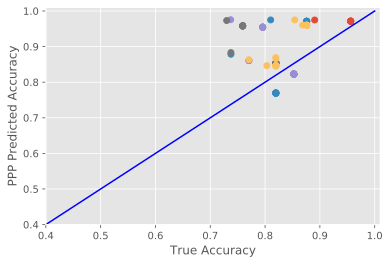

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cleaner_ppp = np.vstack(df_results['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results['cleaner_results_true'])
plt.plot(cleaner_true, cleaner_ppp, 'o')
# plt.legend(ac.cleaners, loc='lower left')
plt.plot([0,1],[0,1],'b-')
plt.ylim([.4,1.01])
plt.xlim([.4,1.01])
plt.xlabel('True Accuracy')
plt.ylabel('PPP Predicted Accuracy')

## How Useful are the Data Cleaning Options Tested?

Not very useful it seems - the red dots falling on the iso-performance line indicate that the best cleaning accuracy (y-axis) is just as good as the accuarcy when not doing any cleaning (x-axis).

As a sanity check, the blue crosses show, in slight abuse of the same axis, that the corruptions applied to the data indeed to lead to worse performance. 

Text(0, 0.5, 'Cleaning')

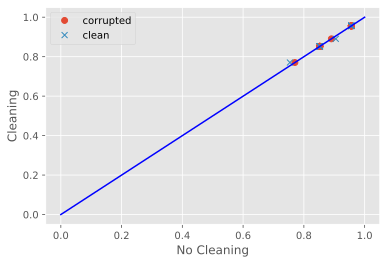

In [12]:
cleaner_ppp = np.vstack(df_results['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results['cleaner_results_true'])
plt.plot(df_results['corrupted_data_test_score'], cleaner_true.max(axis=1), 'o',
         df_results['clean_data_test_score'], cleaner_true.max(axis=1),'x')
plt.legend(['corrupted', 'clean'], loc='upper left')
plt.plot([0,1],[0,1],'b-')
plt.xlabel('No Cleaning')
plt.ylabel('Cleaning')

## For non-linear black-box models, it seems to be even worse ... 

It seems that PPP consistently overestimates the true predictive performance for nonlinear black box models. 

In [9]:
cleaner_ppp = np.vstack(df_results_nonlinear['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results_nonlinear['cleaner_results_true'])
plt.plot(cleaner_true, cleaner_ppp, 'o')
plt.legend(ac.cleaners, loc='lower left')
plt.plot([0,1],[0,1],'b-')
plt.ylim([.6,1.01])
plt.xlim([.6,1.01])
plt.xlabel('True Accuracy')
plt.ylabel('PPP Predicted Accuracy')

NameError: name 'df_results_nonlinear' is not defined

## Also for non-linear black-box models, cleaning doesn't seem to help

Same plot as for linear models above, in most cases cleaning corrupted data does not improve predictive performance 

(0.6, 1.01)

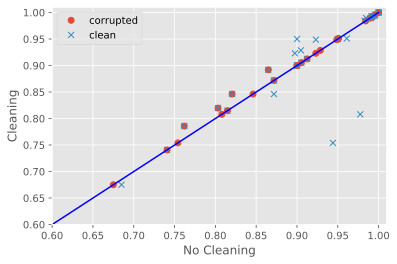

In [72]:
cleaner_ppp = np.vstack(df_results_nonlinear['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results_nonlinear['cleaner_results_true'])
plt.plot(df_results_nonlinear['corrupted_data_test_score'], cleaner_true.max(axis=1), 'o',
         df_results_nonlinear['clean_data_test_score'], cleaner_true.max(axis=1),'x')
plt.legend(['corrupted', 'clean'], loc='upper left')
plt.plot([0,1],[0,1],'b-')
plt.xlabel('No Cleaning')
plt.ylabel('Cleaning')
plt.ylim([.6,1.01])
plt.xlim([.6,1.01])

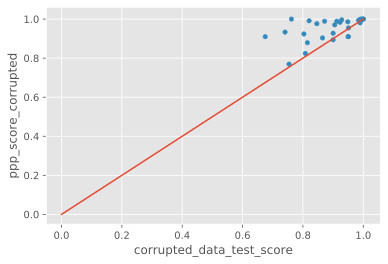

In [66]:
df_results_nonlinear.plot.scatter('corrupted_data_test_score','ppp_score_corrupted')
plt.plot([0,1],[0,1],'-')